In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
Wgamma_fidcross  = 110.02191836496351
Wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 5.23820

ttjets_fidcross  = 22.388
zjets_fidcross   = 3.5025615
wz_fidcross      = 2.2074
zz_fidcross      = 0.2848
ww_fidcross      = 4.197
tj_fidcross      = 0.9348
tb_fidcross      = 1.293
tw_fidcross      = 2.1975

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

260.6030389669158

In [9]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [10]:
Wgamma_expected  = 11002.191836496351
Wjets_expected   = 10833.785910195227
ttgamma_expected = 523.820

ttjets_expected  = 2238.5992598
zjets_expected   = 350.25615
wz_expected      = 220.74
zz_expected      = 28.481
ww_expected      = 419.71
tj_expected      = 93.489
tb_expected      = 129.372
tw_expected      = 219.75

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

26060.19515649158


In [11]:
sample = 60_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

25331
24943
1206
5155
806
508
66
966
215
298
506


In [12]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_6.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_6.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_6.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_6.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_6.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_6.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_6.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_6.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_6.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_6.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_6.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_6.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_6.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_6.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_6.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_6.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_6.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_6.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_6.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_6.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_6.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_6.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_6.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_6.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_6.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_6.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_6.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_6.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_6.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_6.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_6.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_6.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_6.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_6.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_6.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_6.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_6.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_6.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_6.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_6.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_6.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_6.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_6.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_6.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_6.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_6.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_6.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_6.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_6.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_6.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_6.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_6.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_6.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_6.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_6.dat', delimiter=' ')

In [13]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [14]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [15]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

22179
21840
1056
4513
706
445
57
846
188
261
506


In [16]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [17]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [18]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(46783, 4)
(568366, 4)
(673720, 4)
(11533, 4)
(1576, 4)
(3028, 4)
(844, 4)
(7330, 4)
(568, 4)
(670, 4)
(3050, 4)


### Other variables

In [19]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [20]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [21]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [22]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [23]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [24]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [25]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [26]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [0.81425212 2.05771304 3.43901743 0.49356859 1.1242718  1.79475315
 0.31681198 0.64513953 0.97066177 0.20263041 0.3811103  0.56045857
 0.12166327 0.22147437 0.32054438]
Events expected:  [ 81.42521191 205.77130384 343.90174266  49.3568592  112.42718012
 179.47531491  31.68119755  64.51395271  97.0661765   20.26304062
  38.11102998  56.04585686  12.16632666  22.14743731  32.05443842]


In [27]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [28]:
print(photon_SM.shape)
print(photon_SM_pool.shape)
print(photon_NP[0].shape)

(60000, 4)
(52534, 4)
(210768, 4)


# Analysis

## training

In [29]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(60000, 4)
(60000, 3)
(60000, 5)
(60000, 3)
(60000, 3)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)


In [30]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 0

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(210768, 4)
(210768, 3)
(210768, 5)
(210768, 3)
(210768, 3)
(210768,)
(210768,)
(210768,)
(210768,)
(210768,)
(210768,)


In [31]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

60000

In [32]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,36.50,1.923,-0.244,1.0,539.70,-0.019,2.878,17.49,0.793,-0.113,...,714.33,660.34,3.0,593.69,22.191830,27.327786,1127.645194,32.151817,1.0,0.0
1,18.55,1.243,1.185,1.0,295.91,-0.560,2.948,52.02,-1.100,0.234,...,394.84,324.27,2.0,366.48,13.617619,91.985624,565.850125,54.326751,2.0,0.0
2,89.12,-1.135,-2.221,1.0,184.17,-1.681,1.744,73.17,0.303,-1.657,...,554.20,391.91,4.0,346.46,8.886028,118.164779,392.312000,40.764357,2.0,0.0
3,51.88,-0.039,0.451,1.0,158.25,-0.813,-2.932,38.36,0.582,0.121,...,402.50,312.26,2.0,248.49,10.003787,36.737392,340.331650,59.513967,2.0,0.0
4,12.62,0.841,-2.120,1.0,243.27,1.296,2.195,71.41,-0.759,-1.547,...,667.18,583.15,6.0,327.30,8.574196,44.797240,459.070735,37.834872,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,31.48,-0.105,-1.770,1.0,438.38,-0.487,0.832,27.70,-1.064,3.113,...,790.56,731.38,5.0,497.56,14.069119,106.118006,811.737037,42.534668,0.0,1.0
119996,13.78,-2.308,-0.107,1.0,273.87,0.193,-1.831,24.76,0.039,1.639,...,398.47,359.93,3.0,312.41,14.673590,97.404683,558.794188,0.085161,0.0,1.0
119997,43.88,2.113,2.795,1.0,497.09,0.976,0.119,40.86,1.097,2.654,...,791.49,706.75,2.0,581.83,17.167475,17.458966,965.374563,36.561236,0.0,1.0
119998,78.61,0.201,0.716,1.0,301.13,0.678,-2.027,12.18,-0.189,-0.252,...,484.29,393.50,4.0,391.92,11.352509,58.152866,548.540698,70.481236,0.0,1.0


In [33]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,12.39,1.792,2.672,1.0,353.76,-0.603,0.654,69.65,-1.569,-1.920,...,701.32,619.28,2.0,435.80,10.051941,98.681363,546.695920,50.896876,2.0,0.0
1,13.30,0.558,2.299,1.0,430.08,1.237,-0.482,60.25,0.604,2.282,...,697.49,623.94,3.0,503.63,8.441488,17.296870,619.162575,38.758499,4.0,0.0
2,28.46,-0.455,0.907,1.0,281.63,-1.985,-0.757,41.68,-2.171,-3.004,...,658.83,588.69,4.0,351.77,8.222012,70.611334,470.464416,122.707426,4.0,0.0
3,11.41,0.397,2.898,1.0,942.18,-0.751,-1.079,122.32,0.381,2.899,...,1876.11,1666.07,6.0,1075.91,5.126970,50.328439,909.718100,164.928364,4.0,0.0
4,15.61,-0.056,1.909,1.0,267.70,0.153,-1.943,24.12,-0.389,0.720,...,307.43,267.70,1.0,307.43,13.452394,46.755487,502.155053,29.822076,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203297,28.89,0.302,-0.456,1.0,300.14,1.735,2.141,33.65,-0.073,-1.630,...,362.68,300.14,1.0,362.68,11.685998,46.395140,516.782857,50.071575,0.0,1.0
203298,98.86,-1.447,1.858,1.0,484.24,0.015,-0.730,41.28,-0.587,-2.335,...,695.97,555.83,3.0,624.38,13.740065,111.703532,837.703656,165.971074,0.0,1.0
203299,41.88,-0.527,1.158,1.0,328.35,-1.107,-0.449,71.36,0.818,-2.868,...,479.93,366.69,2.0,441.59,13.736971,158.066475,628.633737,99.836002,0.0,1.0
203300,136.06,-1.625,-1.174,1.0,466.47,-0.644,3.120,86.92,0.721,1.155,...,822.35,599.37,4.0,689.45,14.584342,296.454855,879.459305,180.806702,0.0,1.0


In [34]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [35]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [36]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [37]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [38]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [39]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [40]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

There are less Wgamma events 4996 than expected 11002.191836496351
There are less ttgamma events 245 than expected 523.82
There are less Wjets events 5043 than expected 10833.785910195227
There are less ttjets events 1012 than expected 2238.5992598
There are less zjets events 162 than expected 350.25615
There are less wz events 109 than expected 220.74
There are less zz events 14 than expected 28.481
There are less ww events 198 than expected 419.71
There are less tj events 40 than expected 93.489
There are less tb events 54 than expected 129.372
There are less tw events 99 than expected 219.75


In [41]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [42]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
fit = True
if fit:
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  =True)
    classifier.save_model('BP-' + str(bp+1) + '_MET200.json')
else:
    classifier.load_model('BP-' + str(bp+1) + '_MET200.json')

[0]	validation_0-logloss:0.65784	validation_1-logloss:0.65837
[1]	validation_0-logloss:0.62842	validation_1-logloss:0.62953
[2]	validation_0-logloss:0.60360	validation_1-logloss:0.60513
[3]	validation_0-logloss:0.58281	validation_1-logloss:0.58466
[4]	validation_0-logloss:0.56430	validation_1-logloss:0.56642
[5]	validation_0-logloss:0.54841	validation_1-logloss:0.55103
[6]	validation_0-logloss:0.53457	validation_1-logloss:0.53737
[7]	validation_0-logloss:0.52212	validation_1-logloss:0.52513
[8]	validation_0-logloss:0.51134	validation_1-logloss:0.51459
[9]	validation_0-logloss:0.50180	validation_1-logloss:0.50529
[10]	validation_0-logloss:0.49298	validation_1-logloss:0.49659
[11]	validation_0-logloss:0.48542	validation_1-logloss:0.48939
[12]	validation_0-logloss:0.47810	validation_1-logloss:0.48239
[13]	validation_0-logloss:0.47201	validation_1-logloss:0.47655
[14]	validation_0-logloss:0.46634	validation_1-logloss:0.47130
[15]	validation_0-logloss:0.46124	validation_1-logloss:0.46642
[1

In [43]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [44]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (203302, 22)
y_mon_test :  (203302,)



In [45]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

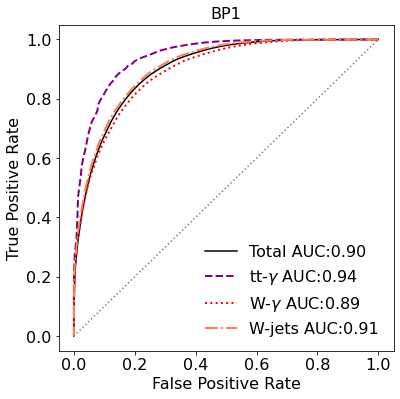

In [46]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches='tight')

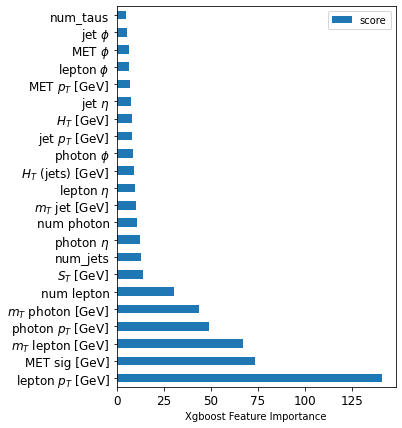

In [47]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All_MET200_new.png', bbox_inches='tight')

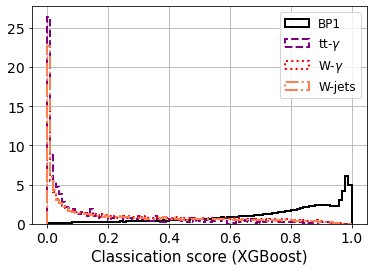

In [48]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches="tight")

In [49]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [50]:
len(np.where(bkg_flag_test != 0)[0])

52534

In [51]:
len(np.where(bkg_flag_test == 0)[0])

150768

In [52]:
S_expected[bp]

81.42521191306237

In [53]:
S_expected[bp] / np.sqrt(B_expected)

0.5043941787085761

In [54]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_392462/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [65]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
  

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

jet $\phi$ <= 3.142; Z = 0.5015024580945258
lepton $p_T$ [GeV] <= 184.92888888888888; Z = 0.5287798329355432
$H_T$ (jets) [GeV] <= 1460.7233333333334; Z = 0.5306488215443341
$H_T$ [GeV] <= 1885.6166666666666; Z = 0.5307969187940363
$m_T$ jet [GeV] >= 309.51592402834876; Z = 0.5320384972922035
lepton $\eta$ <= 2.5; Z = 0.5320384972922035
$m_T$ photon [GeV] <= 704.5140591374243; Z = 0.5331834601725303
photon $p_T$ [GeV] <= 178.73; Z = 0.5391227197397538
num_jets <= 5.888888888888889; Z = 0.541841863117784
jet $p_T$ [GeV] <= 1004.8433333333332; Z = 0.5421103723947178
lepton $\phi$ <= 3.142; Z = 0.5421103723947178
$S_T$ [GeV] <= 1171.2055555555555; Z = 0.5421775621148107
num lepton <= 2.0; Z = 0.5422313318722
MET $p_T$ [GeV] <= 1083.69; Z = 0.5422313318722
MET $\phi$ <= 3.142; Z = 0.5422313318722
jet $\eta$ <= 3.968; Z = 0.5422313318722
photon $\phi$ <= 3.142; Z = 0.5422313318722
MET sig [GeV] >= 10.377505423937784; Z = 0.5895834130524826
num photon <= 2.111111111111111; Z = 0.589583413052

In [67]:
sup_cuts

{'jet $\\phi$': 3.141,
 'lepton $p_T$ [GeV]': 48.51,
 '$H_T$ (jets) [GeV]': 839.0377777777778,
 '$H_T$ [GeV]': 1038.2044444444446,
 '$m_T$ jet [GeV]': 1379.3430548585216,
 'lepton $\\eta$': 2.499,
 '$m_T$ photon [GeV]': 171.40645475720046,
 'photon $p_T$ [GeV]': 161.88,
 'num_jets': 5.0,
 'jet $p_T$ [GeV]': 782.4177777777777,
 'lepton $\\phi$': 3.141,
 '$S_T$ [GeV]': 933.52,
 'num lepton': 1.0,
 'MET $p_T$ [GeV]': 1083.69,
 'MET $\\phi$': 3.141,
 'jet $\\eta$': 3.0524444444444443,
 'photon $\\phi$': 3.142,
 'MET sig [GeV]': 29.378304397739598,
 'num photon': 1.0,
 'photon $\\eta$': 2.367,
 'num_taus': 1.0,
 '$m_T$ lepton [GeV]': 173.3940303824013}

In [68]:
inf_cuts

{'jet $\\phi$': -999999,
 'lepton $p_T$ [GeV]': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 '$H_T$ [GeV]': -999999,
 '$m_T$ jet [GeV]': 309.51592402834876,
 'lepton $\\eta$': -999999,
 '$m_T$ photon [GeV]': -999999,
 'photon $p_T$ [GeV]': 28.756666666666668,
 'num_jets': -999999,
 'jet $p_T$ [GeV]': -999999,
 'lepton $\\phi$': -999999,
 '$S_T$ [GeV]': -999999,
 'num lepton': 0.2222222222222222,
 'MET $p_T$ [GeV]': -999999,
 'MET $\\phi$': -999999,
 'jet $\\eta$': -999999,
 'photon $\\phi$': -999999,
 'MET sig [GeV]': 10.377505423937784,
 'num photon': -999999,
 'photon $\\eta$': -999999,
 'num_taus': -999999,
 '$m_T$ lepton [GeV]': 98.59276971998975}

In [69]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200_new.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200_new.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [86]:
SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

SM_indices = np.random.choice(SM_test_pool, size = int(B_expected), replace = False)
NP_indices = np.random.choice(NP_test_pool, size = int(S_expected[bp]), replace = False)
indices_aux = np.concatenate((NP_indices, SM_indices))

n_np0  = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

#indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [87]:

n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(n_ttgamma + n_wjets + n_wgamma + n_ttjets + \
                     n_zjets + n_wz + n_zz + n_ww + \
                     n_tj + n_tb + n_tw)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  1.455265118722162
Expected Background = 44
Expected Signal = 10


In [88]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])
    
    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
    n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
    n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
    n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
    n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
    n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
    n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
    n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
    n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                           n_ttjets + n_zjets + n_wz + \
                           n_zz + n_ww + n_tj + \
                           n_tb + n_tw
        
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                 n_ttjets + n_zjets + n_wz + \
                 n_zz + n_ww + n_tj + \
                 n_tb + n_tw
    
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.20it/s]


(array([  2.,   0.,  68., 174., 337., 639., 444., 270.,  46.,  20.]),
 array([26. , 29.4, 32.8, 36.2, 39.6, 43. , 46.4, 49.8, 53.2, 56.6, 60. ]),
 <BarContainer object of 10 artists>)

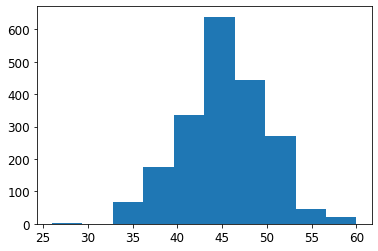

In [89]:
plt.hist(B_observed_exp)

(array([ 23., 144., 166., 529., 305., 498., 224.,  60.,  47.,   4.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

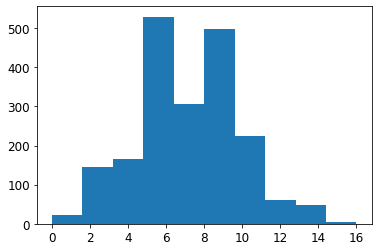

In [90]:
plt.hist(S_observed_exp)

In [91]:
np.mean(S_observed_exp /np.sqrt(B_observed_exp))

1.051228489175747

In [92]:
N_observed = S_observed_exp + B_observed_exp
-2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)


array([0.35309219, 0.35309219, 0.08956216, ..., 0.08956216, 3.01015036,
       2.54579064])

In [93]:
q0_exp

array([0.35309219, 0.35309219, 0.08956216, ..., 0.08956216, 3.01015036,
       2.54579064])

(array([1041.,  434.,  297.,  151.,   40.,   21.,   10.,    2.,    2.,
           2.]),
 array([ 0.        ,  1.49166139,  2.98332277,  4.47498416,  5.96664554,
         7.45830693,  8.94996831, 10.4416297 , 11.93329108, 13.42495247,
        14.91661385]),
 <BarContainer object of 10 artists>)

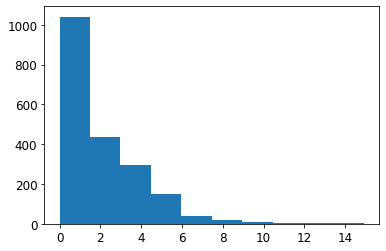

In [94]:
plt.hist(q0_exp)

In [95]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 1
 
Z = 1.1720174081340624; Z_std = 0.832208155232639
B_exp = 45.089; B_exp_std = 4.6803930390513155
S_exp = 7.028; S_exp_std = 2.6302501782149927


In [78]:
np.asarray(lst)[np.argsort(values)[::-1]][:4]

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [226]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
imp_vars = np.array(['lepton $p_T$ [GeV]', 'MET sig [GeV]','$m_T$ lepton [GeV]', '$m_T$ photon [GeV]'])


In [227]:
imp_vars

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [228]:
imp_vars_labels = ['$p_T^{\ell_{1}}$', '$E_T^{miss}/\sqrt{H_T}$',
                   '$m_T^{\ell_1}$','$m_T^{\gamma_1}$']

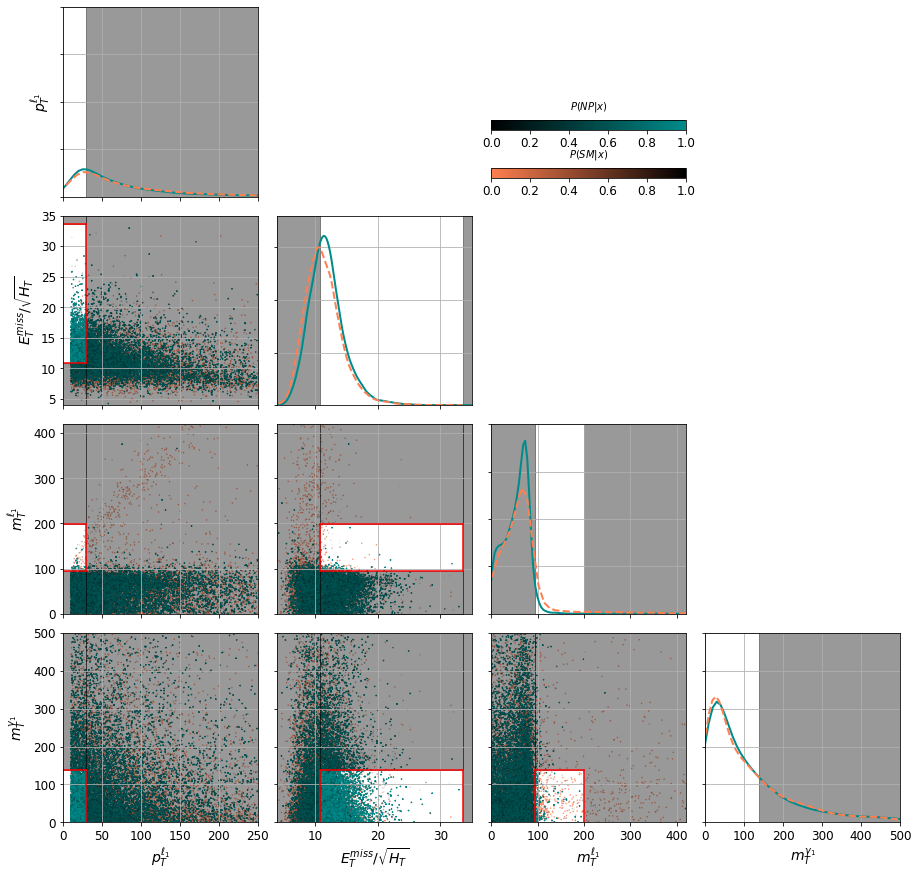

In [229]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  10000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  10000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[0,250], [4,35], [0,420], [0,500]]
ylimites = [[0,0.08], [0,0.18], [0,0.02], [0,0.01]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars_labels[0], fontsize = 14)
ax[3,1].set_xlabel(imp_vars_labels[1], fontsize = 14)
ax[3,2].set_xlabel(imp_vars_labels[2], fontsize = 14)
ax[3,3].set_xlabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_ylabel(imp_vars_labels[0], fontsize = 14)
ax[1,0].set_ylabel(imp_vars_labels[1], fontsize = 14)
ax[2,0].set_ylabel(imp_vars_labels[2], fontsize = 14)
ax[3,0].set_ylabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_MET200_new.pdf')

## BinnedLikelihood

In [267]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(52534,)
(150768,)


In [268]:
B_expected = int(B_expected)

In [269]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  170 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  170
range of our data:  [[0, 1]]


In [270]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP1:

[1.9802754647825263]


B_expected:  26060
S_expected:  81.42521191306237

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


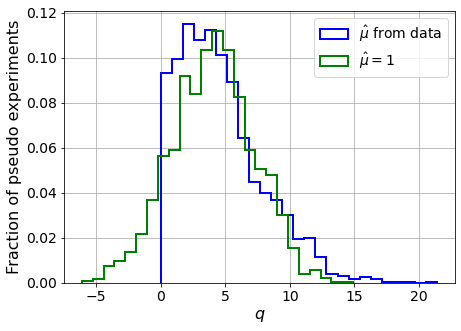

muhat mean:  1.035525
Z_bins:  2.021457591429074
std Z_bins:  0.8033443877974019
Z_bins mu=0:  2.021509496942973
std Z_bins mu=0:  0.7839002703248458

--------


 FINAL RESULT:

[[2.021457591429074, 0.8033443877974019, 1.035525, 2.021509496942973, 0.7839002703248458]]


In [271]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  26060
S_expected:  81.42521191306237

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


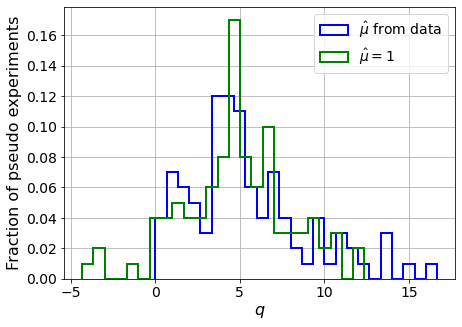

muhat mean:  1.1138028615043836
Z_bins:  2.1693719915624183
std Z_bins:  0.814109052769821
Z_bins mu=0:  2.1628347342081597
std Z_bins mu=0:  0.7458362692443263

--------


 FINAL RESULT:

[[2.1693719915624183, 0.814109052769821, 1.1138028615043836, 2.1628347342081597, 0.7458362692443263]]


In [272]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  2711.37220722
  2605.76672645  2471.96687306  2306.72883689  2125.62295396
  1898.01806677  1601.62075194  1251.22505673   832.27001277
   322.35403716  -285.61482491 -1023.87015973 -2093.690537  ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf


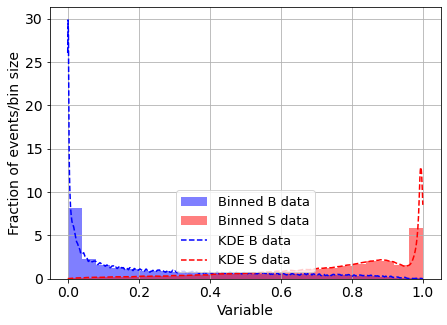

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.008287452507534925


In [175]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

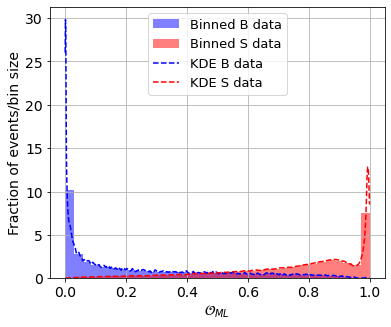

In [176]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '_MET200.pdf')

In [177]:
print(norm_factor_SM)
print(norm_factor_NP)

266.14753662758187
100.28423277903755


In [178]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [179]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([58814., 60445.,  2955.,  2069.,  1720.,  1353.,  1268.,  3061.,
         5951., 13132.]),
 array([ 0.01698118,  1.30242448,  2.58786778,  3.87331107,  5.15875437,
         6.44419767,  7.72964097,  9.01508427, 10.30052756, 11.58597086,
        12.87141416]),
 [<matplotlib.patches.Polygon at 0x7efd5342bd60>])

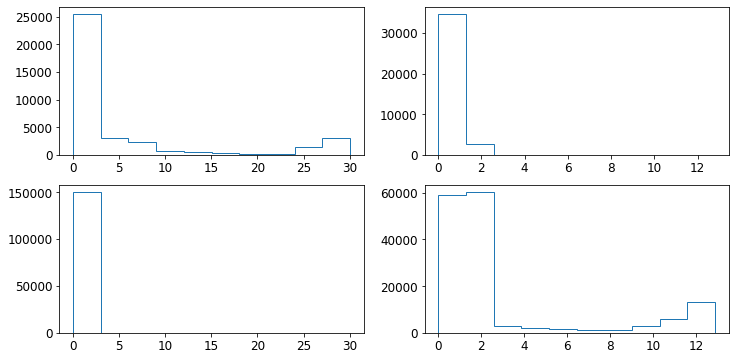

In [180]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [181]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [182]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(3): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

0


  4%|██▋                                                                 | 8/200 [00:02<00:52,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3720336407504086
<p_{s}(Sdata)> = 2.964722663540827
<p_{b}(Bdata)> = 5.592528319237187
<p_{s}(Bdata)> = 0.40504091570382283


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.42it/s]


1


100%|██████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


2


 48%|████████████████████████████████▏                                  | 96/200 [00:27<00:28,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5363417464870184
<p_{s}(Sdata)> = 2.1614090995550552
<p_{b}(Bdata)> = 5.595212159875739
<p_{s}(Bdata)> = 0.4057559256839425


 50%|█████████████████████████████████▏                                 | 99/200 [00:28<00:27,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5139697625411936
<p_{s}(Sdata)> = 2.532399185603165
<p_{b}(Bdata)> = 5.623472240825144
<p_{s}(Bdata)> = 0.4034399653275438


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


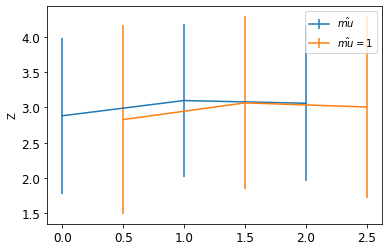

In [185]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP' + str(bp+1) + '_KDEfijo_MET200.pdf')

In [192]:
print('Z_MLL BP' + str(bp+1) + ': ' + str(np.mean(Z_MLL)) + ' +/- ' + str(np.std(Z_MLL))+
      ' +/- ' + str(np.mean(Z_MLL_std)))

Z_MLL BP1: 3.013632929980421 +/- 0.09409184220745251 +/- 1.098003789029043


## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable__MET200.pdf')

## loop varying ML

In [55]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.9015568543773459
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


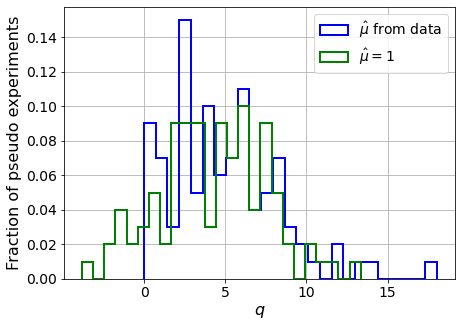

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6551.22173718  6383.67762372
  6162.40379529  5861.40475675  5484.19670477  5028.41093563
  4457.15589513  3749.46787801  2888.59384313  1851.8475639
   598.45037596  -897.20181075 -2691.09034606 -5291.16885951]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4212.11353985  4219.22180693
 

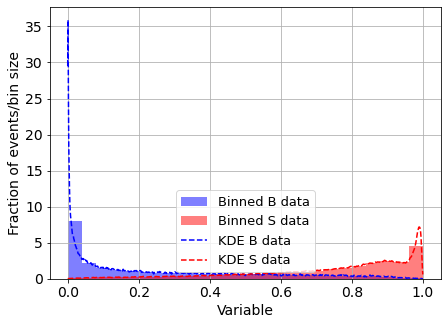

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.014361576896042269
0.014361576896042269
3 done
4 done
0.0
0.000180763117080147


  1%|▉                                                                 | 28/2000 [00:09<13:35,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4378584509636248
<p_{s}(Sdata)> = 1.9846527098714553
<p_{b}(Bdata)> = 5.664252620652413
<p_{s}(Bdata)> = 0.4230678685888308


  2%|█▍                                                                | 44/2000 [00:14<10:18,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42241559516118865
<p_{s}(Sdata)> = 1.8812311604098853
<p_{b}(Bdata)> = 5.7436449316176725
<p_{s}(Bdata)> = 0.42308620627122884


  3%|█▋                                                                | 52/2000 [00:17<08:50,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45987213129194093
<p_{s}(Sdata)> = 2.0331950423460605
<p_{b}(Bdata)> = 5.748947679496658
<p_{s}(Bdata)> = 0.42342955791616027


  3%|█▊                                                                | 54/2000 [00:17<07:20,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4068009710142817
<p_{s}(Sdata)> = 2.089095174882105
<p_{b}(Bdata)> = 5.754443738662477
<p_{s}(Bdata)> = 0.42238487578821865


  4%|██▉                                                               | 89/2000 [00:28<09:20,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43171333738197587
<p_{s}(Sdata)> = 2.0087123566015075
<p_{b}(Bdata)> = 5.680485438552625
<p_{s}(Bdata)> = 0.4301248154965337


  5%|███▍                                                             | 104/2000 [00:33<11:02,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7744282366162879
<p_{s}(Sdata)> = 1.7417497399781652
<p_{b}(Bdata)> = 5.811628244891388
<p_{s}(Bdata)> = 0.4218426099223111


  5%|███▍                                                             | 107/2000 [00:33<07:02,  4.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.49229139521536486
<p_{s}(Sdata)> = 2.058728095732953
<p_{b}(Bdata)> = 5.65371282604281
<p_{s}(Bdata)> = 0.4349547463526718
muhat = -0.1
<p_{b}(Sdata)> = 0.4567333977916707
<p_{s}(Sdata)> = 2.0570708615669373
<p_{b}(Bdata)> = 5.764693339597882
<p_{s}(Bdata)> = 0.4189636551719023


  6%|███▋                                                             | 114/2000 [00:35<08:22,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41339065468866903
<p_{s}(Sdata)> = 1.9956322784569283
<p_{b}(Bdata)> = 5.705453684473218
<p_{s}(Bdata)> = 0.4184852328747992


  7%|████▋                                                            | 145/2000 [00:44<08:07,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45339910132018835
<p_{s}(Sdata)> = 1.772490750526568
<p_{b}(Bdata)> = 5.664500191260138
<p_{s}(Bdata)> = 0.42222330415999554


  8%|████▉                                                            | 153/2000 [00:47<10:48,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45671664697492637
<p_{s}(Sdata)> = 1.7093582602805644
<p_{b}(Bdata)> = 5.724959993656323
<p_{s}(Bdata)> = 0.4202011720402851


  9%|█████▌                                                           | 173/2000 [00:52<06:35,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45631790122175653
<p_{s}(Sdata)> = 1.8918716696683924
<p_{b}(Bdata)> = 5.812742255691386
<p_{s}(Bdata)> = 0.4215028602737356


 10%|██████▏                                                          | 191/2000 [00:57<07:31,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.391423985631254
<p_{s}(Sdata)> = 1.9790074644406237
<p_{b}(Bdata)> = 5.755928727015571
<p_{s}(Bdata)> = 0.417685745383537


 10%|██████▍                                                          | 199/2000 [00:59<06:38,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4769656386357656
<p_{s}(Sdata)> = 2.0226569925122035
<p_{b}(Bdata)> = 5.655817882868659
<p_{s}(Bdata)> = 0.4277068290470825


 10%|██████▊                                                          | 210/2000 [01:03<10:35,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4476960908103878
<p_{s}(Sdata)> = 1.807319991327392
<p_{b}(Bdata)> = 5.766607350028612
<p_{s}(Bdata)> = 0.4188229132484559


 11%|███████▍                                                         | 229/2000 [01:09<10:47,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4535393731223836
<p_{s}(Sdata)> = 1.902984706712065
<p_{b}(Bdata)> = 5.677751727921199
<p_{s}(Bdata)> = 0.4185057679999055


 12%|███████▋                                                         | 237/2000 [01:11<08:04,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41644823203560416
<p_{s}(Sdata)> = 1.9655992537945606
<p_{b}(Bdata)> = 5.698687709797181
<p_{s}(Bdata)> = 0.42438899270515557


 12%|████████                                                         | 248/2000 [01:14<07:52,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45493156384465583
<p_{s}(Sdata)> = 1.7676480615769814
<p_{b}(Bdata)> = 5.7330703469384225
<p_{s}(Bdata)> = 0.4245182398568528


 13%|████████▏                                                        | 252/2000 [01:15<08:24,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45483215102390434
<p_{s}(Sdata)> = 1.916016005298481
<p_{b}(Bdata)> = 5.758991553255898
<p_{s}(Bdata)> = 0.4224090022753535


 15%|█████████▉                                                       | 306/2000 [01:32<08:15,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39657040357376916
<p_{s}(Sdata)> = 2.162652343814472
<p_{b}(Bdata)> = 5.706663323719168
<p_{s}(Bdata)> = 0.42504200400277203


 16%|██████████▏                                                      | 312/2000 [01:34<08:41,  3.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37078194582453095
<p_{s}(Sdata)> = 2.514915623646188
<p_{b}(Bdata)> = 5.705023713380606
<p_{s}(Bdata)> = 0.43174386975848134


 17%|██████████▉                                                      | 338/2000 [01:43<09:01,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4790097367938902
<p_{s}(Sdata)> = 1.6849412531207604
<p_{b}(Bdata)> = 5.875194054996739
<p_{s}(Bdata)> = 0.4241922958407498


 17%|███████████                                                      | 340/2000 [01:43<07:38,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4182597690643314
<p_{s}(Sdata)> = 2.1100461036219316
<p_{b}(Bdata)> = 5.738485035052825
<p_{s}(Bdata)> = 0.42027253117196023


 19%|████████████▌                                                    | 386/2000 [01:57<05:46,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38854427446061224
<p_{s}(Sdata)> = 2.193996249054228
<p_{b}(Bdata)> = 5.735387640335994
<p_{s}(Bdata)> = 0.4191942100352697
muhat = -0.1
<p_{b}(Sdata)> = 0.4575386544097337
<p_{s}(Sdata)> = 1.9156398822205418
<p_{b}(Bdata)> = 5.777335901543759
<p_{s}(Bdata)> = 0.4209690567997886


 20%|████████████▋                                                    | 392/2000 [02:00<11:55,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4337587184753155
<p_{s}(Sdata)> = 2.092383204761841
<p_{b}(Bdata)> = 5.8113521429135755
<p_{s}(Bdata)> = 0.4205504767222454


 21%|█████████████▍                                                   | 415/2000 [02:06<08:15,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4088892242991307
<p_{s}(Sdata)> = 1.9586213174330551
<p_{b}(Bdata)> = 5.77417109315455
<p_{s}(Bdata)> = 0.4207960066949367


 24%|███████████████▋                                                 | 481/2000 [02:25<05:42,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4155268502029623
<p_{s}(Sdata)> = 1.8958138608573671
<p_{b}(Bdata)> = 5.723138302448541
<p_{s}(Bdata)> = 0.41725176177694523


 25%|████████████████                                                 | 493/2000 [02:28<06:54,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42836161634814485
<p_{s}(Sdata)> = 2.0410692812822626
<p_{b}(Bdata)> = 5.745393524114734
<p_{s}(Bdata)> = 0.4229576294602559


 26%|████████████████▉                                                | 520/2000 [02:37<05:10,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4611309614761556
<p_{s}(Sdata)> = 2.1320916449989236
<p_{b}(Bdata)> = 5.7708922609306885
<p_{s}(Bdata)> = 0.420989700011472
muhat = -0.1
<p_{b}(Sdata)> = 0.4606582047895884
<p_{s}(Sdata)> = 2.052812106876175
<p_{b}(Bdata)> = 5.769556602148683
<p_{s}(Bdata)> = 0.4192714467985938


 27%|█████████████████▍                                               | 538/2000 [02:42<06:50,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39561833874911784
<p_{s}(Sdata)> = 2.0698191238906163
<p_{b}(Bdata)> = 5.63345993741935
<p_{s}(Bdata)> = 0.4260386194664315


 27%|█████████████████▋                                               | 546/2000 [02:44<05:57,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42387700240547505
<p_{s}(Sdata)> = 1.9320517105270036
<p_{b}(Bdata)> = 5.681450611500909
<p_{s}(Bdata)> = 0.4191036294777666


 28%|██████████████████                                               | 555/2000 [02:47<07:47,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4854854734493985
<p_{s}(Sdata)> = 1.7180843401591421
<p_{b}(Bdata)> = 5.693093002169695
<p_{s}(Bdata)> = 0.4283505787728128


 29%|██████████████████▊                                              | 579/2000 [02:54<05:16,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.387903398545392
<p_{s}(Sdata)> = 2.224018796313287
<p_{b}(Bdata)> = 5.830668283926405
<p_{s}(Bdata)> = 0.42035274518834437
muhat = -0.1
<p_{b}(Sdata)> = 0.5175070371980405
<p_{s}(Sdata)> = 1.8156659002375302
<p_{b}(Bdata)> = 5.698932553823373
<p_{s}(Bdata)> = 0.42351040367153325


 30%|███████████████████▍                                             | 599/2000 [03:00<04:31,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40526833210135726
<p_{s}(Sdata)> = 2.1654821148390915
<p_{b}(Bdata)> = 5.749385671705928
<p_{s}(Bdata)> = 0.4210864539681079


 30%|███████████████████▊                                             | 608/2000 [03:02<05:14,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38329956182164515
<p_{s}(Sdata)> = 2.160405364646417
<p_{b}(Bdata)> = 5.728378587766309
<p_{s}(Bdata)> = 0.42074788887603215
muhat = -0.1
<p_{b}(Sdata)> = 0.4389130894599098
<p_{s}(Sdata)> = 2.0254531601319368
<p_{b}(Bdata)> = 5.791627831982701
<p_{s}(Bdata)> = 0.42143188931683656


 31%|████████████████████▍                                            | 628/2000 [03:08<06:51,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42965718231646344
<p_{s}(Sdata)> = 1.9063142947019374
<p_{b}(Bdata)> = 5.774223857967142
<p_{s}(Bdata)> = 0.4221934782932642


 33%|█████████████████████▏                                           | 652/2000 [03:15<06:54,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41626833385137296
<p_{s}(Sdata)> = 1.9707737612407594
<p_{b}(Bdata)> = 5.758314883013324
<p_{s}(Bdata)> = 0.4228461211480656


 33%|█████████████████████▌                                           | 662/2000 [03:18<04:21,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44855874844358684
<p_{s}(Sdata)> = 2.2120579438761006
<p_{b}(Bdata)> = 5.672769435308832
<p_{s}(Bdata)> = 0.4234432508762502


 42%|███████████████████████████▌                                     | 847/2000 [04:13<05:10,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3152483746273081
<p_{s}(Sdata)> = 2.3128006483566352
<p_{b}(Bdata)> = 5.645435231064119
<p_{s}(Bdata)> = 0.42812504885488345


 44%|████████████████████████████▌                                    | 877/2000 [04:22<04:25,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3702838178422226
<p_{s}(Sdata)> = 2.5046797738693347
<p_{b}(Bdata)> = 5.706322393369655
<p_{s}(Bdata)> = 0.43239010830816704


 47%|██████████████████████████████▊                                  | 947/2000 [04:43<04:27,  3.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.42479926612778546
<p_{s}(Sdata)> = 2.2725184929157245
<p_{b}(Bdata)> = 5.662948020934463
<p_{s}(Bdata)> = 0.4318895313583553


 48%|███████████████████████████████                                  | 954/2000 [04:45<05:33,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4688132305376823
<p_{s}(Sdata)> = 2.1178553237004856
<p_{b}(Bdata)> = 5.763883294618963
<p_{s}(Bdata)> = 0.4189499486551973


 48%|███████████████████████████████▍                                 | 967/2000 [04:49<06:04,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43022894678463414
<p_{s}(Sdata)> = 1.9801129620015796
<p_{b}(Bdata)> = 5.7647442798670285
<p_{s}(Bdata)> = 0.42122077950238923


 50%|████████████████████████████████▎                                | 995/2000 [04:57<04:53,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42869720478155987
<p_{s}(Sdata)> = 2.092685746961697
<p_{b}(Bdata)> = 5.781491191549891
<p_{s}(Bdata)> = 0.41702299274015614


 50%|████████████████████████████████                                | 1003/2000 [05:00<04:39,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44655981552898405
<p_{s}(Sdata)> = 2.0131277822538545
<p_{b}(Bdata)> = 5.780344678888416
<p_{s}(Bdata)> = 0.4188453660886464


 51%|████████████████████████████████▊                               | 1024/2000 [05:07<05:05,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4873917801867175
<p_{s}(Sdata)> = 1.8174206053000879
<p_{b}(Bdata)> = 5.694632734647253
<p_{s}(Bdata)> = 0.42561491915709604


 51%|████████████████████████████████▉                               | 1029/2000 [05:08<05:15,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40509909663934845
<p_{s}(Sdata)> = 2.2676967764948115
<p_{b}(Bdata)> = 5.635679730854809
<p_{s}(Bdata)> = 0.4257177786263527


 52%|█████████████████████████████████▎                              | 1042/2000 [05:12<05:17,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4686753652236147
<p_{s}(Sdata)> = 1.9327933547581566
<p_{b}(Bdata)> = 5.712403073074209
<p_{s}(Bdata)> = 0.4260888212509197


 52%|█████████████████████████████████▌                              | 1047/2000 [05:13<05:21,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46066825579469883
<p_{s}(Sdata)> = 1.7067291650241678
<p_{b}(Bdata)> = 5.732256395206106
<p_{s}(Bdata)> = 0.42479309895181516


 53%|██████████████████████████████████                              | 1063/2000 [05:18<05:05,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4361181250285545
<p_{s}(Sdata)> = 2.011089654022394
<p_{b}(Bdata)> = 5.675563636355225
<p_{s}(Bdata)> = 0.42324578816437625


 54%|██████████████████████████████████▎                             | 1072/2000 [05:21<05:10,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4027158763764436
<p_{s}(Sdata)> = 2.0179549267401553
<p_{b}(Bdata)> = 5.805745732951852
<p_{s}(Bdata)> = 0.4195199976698383


 55%|███████████████████████████████████                             | 1094/2000 [05:28<03:37,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39247693210093765
<p_{s}(Sdata)> = 2.1868822561237375
<p_{b}(Bdata)> = 5.754164152880613
<p_{s}(Bdata)> = 0.41969175140613474


 56%|███████████████████████████████████▌                            | 1112/2000 [05:33<04:39,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42682820164484697
<p_{s}(Sdata)> = 2.008530468029921
<p_{b}(Bdata)> = 5.654557833705661
<p_{s}(Bdata)> = 0.4228111237757123


 58%|█████████████████████████████████████▎                          | 1166/2000 [05:51<03:53,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45976731122044
<p_{s}(Sdata)> = 1.6317377715128902
<p_{b}(Bdata)> = 5.780860320089206
<p_{s}(Bdata)> = 0.4254303357452722


 59%|█████████████████████████████████████▌                          | 1173/2000 [05:53<02:36,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45695653661763963
<p_{s}(Sdata)> = 1.7885220006025013
<p_{b}(Bdata)> = 5.766842744053413
<p_{s}(Bdata)> = 0.4246511174558164
muhat = -0.1
<p_{b}(Sdata)> = 0.43659630501187696
<p_{s}(Sdata)> = 1.8650631153862929
<p_{b}(Bdata)> = 5.758987813572471
<p_{s}(Bdata)> = 0.42568702116900803


 60%|██████████████████████████████████████                          | 1190/2000 [05:58<04:02,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4764913221717454
<p_{s}(Sdata)> = 1.9872715958412719
<p_{b}(Bdata)> = 5.789475284900761
<p_{s}(Bdata)> = 0.41786700750213857


 60%|██████████████████████████████████████▌                         | 1207/2000 [06:03<04:25,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4911391064469789
<p_{s}(Sdata)> = 1.8701681188259185
<p_{b}(Bdata)> = 5.726740592254046
<p_{s}(Bdata)> = 0.4225612320901516


 61%|██████████████████████████████████████▉                         | 1217/2000 [06:07<04:42,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4825454680335217
<p_{s}(Sdata)> = 1.824030208525973
<p_{b}(Bdata)> = 5.696773335748549
<p_{s}(Bdata)> = 0.4220830943290484


 61%|███████████████████████████████████████▎                        | 1227/2000 [06:10<03:08,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38876225286468474
<p_{s}(Sdata)> = 2.1513385250521586
<p_{b}(Bdata)> = 5.685992710623794
<p_{s}(Bdata)> = 0.41851744190917695


 62%|███████████████████████████████████████▊                        | 1243/2000 [06:14<02:45,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4169137309290886
<p_{s}(Sdata)> = 1.953573761929373
<p_{b}(Bdata)> = 5.690927351560534
<p_{s}(Bdata)> = 0.42259423817558767


 62%|███████████████████████████████████████▉                        | 1248/2000 [06:16<02:35,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4561120735772151
<p_{s}(Sdata)> = 1.7639076092813177
<p_{b}(Bdata)> = 5.68580721525299
<p_{s}(Bdata)> = 0.42609465803778257
muhat = -0.1
<p_{b}(Sdata)> = 0.44297051025275885
<p_{s}(Sdata)> = 1.9151960677448916
<p_{b}(Bdata)> = 5.820043993997835
<p_{s}(Bdata)> = 0.4208616971772596


 63%|████████████████████████████████████████▎                       | 1259/2000 [06:19<03:24,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.755059728137953
<p_{s}(Sdata)> = 1.6378284127429914
<p_{b}(Bdata)> = 5.684930262405757
<p_{s}(Bdata)> = 0.42265746582832026


 64%|████████████████████████████████████████▋                       | 1272/2000 [06:23<02:44,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4255058424995734
<p_{s}(Sdata)> = 2.1596812107522276
<p_{b}(Bdata)> = 5.851148736868317
<p_{s}(Bdata)> = 0.4215952025751445
muhat = -0.1
<p_{b}(Sdata)> = 0.46384928322857116
<p_{s}(Sdata)> = 1.8103349694420379
<p_{b}(Bdata)> = 5.837923031950909
<p_{s}(Bdata)> = 0.4169560835773851


 64%|█████████████████████████████████████████▏                      | 1288/2000 [06:28<03:43,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39545966162739166
<p_{s}(Sdata)> = 2.487005082455718
<p_{b}(Bdata)> = 5.75523534706968
<p_{s}(Bdata)> = 0.4175975600948345


 66%|██████████████████████████████████████████                      | 1315/2000 [06:35<03:04,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43311610001426265
<p_{s}(Sdata)> = 1.8343348294626252
<p_{b}(Bdata)> = 5.746412172522377
<p_{s}(Bdata)> = 0.4186204694373377


 66%|██████████████████████████████████████████▌                     | 1329/2000 [06:39<03:13,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44962505203956216
<p_{s}(Sdata)> = 1.8628396842777455
<p_{b}(Bdata)> = 5.690425249890716
<p_{s}(Bdata)> = 0.42416640611011924


 67%|███████████████████████████████████████████                     | 1344/2000 [06:44<02:24,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42886096994097617
<p_{s}(Sdata)> = 2.016058965619334
<p_{b}(Bdata)> = 5.763253172574073
<p_{s}(Bdata)> = 0.4210576381108236


 68%|███████████████████████████████████████████▎                    | 1354/2000 [06:47<03:30,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4240402618492306
<p_{s}(Sdata)> = 1.8636734673598923
<p_{b}(Bdata)> = 5.770715850812276
<p_{s}(Bdata)> = 0.4205108673711186


 70%|████████████████████████████████████████████▋                   | 1395/2000 [07:00<03:12,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5040847833727267
<p_{s}(Sdata)> = 1.915986127978853
<p_{b}(Bdata)> = 5.823505117899279
<p_{s}(Bdata)> = 0.41936636248571224


 70%|████████████████████████████████████████████▊                   | 1402/2000 [07:03<03:38,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4156349621680566
<p_{s}(Sdata)> = 1.9646157356843237
<p_{b}(Bdata)> = 5.7500100671236645
<p_{s}(Bdata)> = 0.42518951747051537


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [07:06<03:16,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5479553166278153
<p_{s}(Sdata)> = 1.629120500993537
<p_{b}(Bdata)> = 5.825704451853974
<p_{s}(Bdata)> = 0.42483008978057935


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [07:08<02:51,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3669813415410436
<p_{s}(Sdata)> = 2.142513998233436
<p_{b}(Bdata)> = 5.818920181488511
<p_{s}(Bdata)> = 0.423096219787558


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [07:08<02:12,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4473081381599785
<p_{s}(Sdata)> = 1.8883463188369944
<p_{b}(Bdata)> = 5.721877769826906
<p_{s}(Bdata)> = 0.42139897214668787


 72%|█████████████████████████████████████████████▉                  | 1437/2000 [07:12<02:56,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42443803402053515
<p_{s}(Sdata)> = 2.2312229827880357
<p_{b}(Bdata)> = 5.772347711418204
<p_{s}(Bdata)> = 0.420259456115264


 72%|██████████████████████████████████████████████▏                 | 1445/2000 [07:15<02:50,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4214355487116587
<p_{s}(Sdata)> = 1.9226390678742395
<p_{b}(Bdata)> = 5.838032742721688
<p_{s}(Bdata)> = 0.4178234745104039


 73%|██████████████████████████████████████████████▉                 | 1466/2000 [07:21<03:12,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4496830851963799
<p_{s}(Sdata)> = 2.014621163670904
<p_{b}(Bdata)> = 5.759586254000909
<p_{s}(Bdata)> = 0.42513921310298114


 74%|███████████████████████████████████████████████▏                | 1476/2000 [07:24<02:02,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40462588439662955
<p_{s}(Sdata)> = 2.00272284610276
<p_{b}(Bdata)> = 5.707322055783936
<p_{s}(Bdata)> = 0.4273059520849268


 75%|███████████████████████████████████████████████▋                | 1491/2000 [07:28<02:30,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47415853673537844
<p_{s}(Sdata)> = 1.6315292804260242
<p_{b}(Bdata)> = 5.681714585439379
<p_{s}(Bdata)> = 0.4232335793298996


 75%|███████████████████████████████████████████████▊                | 1493/2000 [07:28<01:54,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4618982905103429
<p_{s}(Sdata)> = 2.194546831409182
<p_{b}(Bdata)> = 5.759992305090751
<p_{s}(Bdata)> = 0.4206378848778962


 77%|█████████████████████████████████████████████████               | 1535/2000 [07:41<02:52,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5286450875730525
<p_{s}(Sdata)> = 1.9352013034743298
<p_{b}(Bdata)> = 5.665938084876729
<p_{s}(Bdata)> = 0.4244135698820629


 77%|█████████████████████████████████████████████████▏              | 1538/2000 [07:42<02:10,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4791053152357686
<p_{s}(Sdata)> = 2.028547109867125
<p_{b}(Bdata)> = 5.73916729453021
<p_{s}(Bdata)> = 0.42317596278026437


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [07:45<02:52,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5425668123081852
<p_{s}(Sdata)> = 1.7279544844358807
<p_{b}(Bdata)> = 5.808258996973647
<p_{s}(Bdata)> = 0.42019821100322124


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [07:46<02:14,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46236275843793273
<p_{s}(Sdata)> = 1.8540513180980973
<p_{b}(Bdata)> = 5.779040139472586
<p_{s}(Bdata)> = 0.4226801693387754


 78%|█████████████████████████████████████████████████▊              | 1557/2000 [07:48<02:15,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4630506024406594
<p_{s}(Sdata)> = 1.7118465465513064
<p_{b}(Bdata)> = 5.6964293740695995
<p_{s}(Bdata)> = 0.4227773230197605


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [07:51<02:05,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4180347552751754
<p_{s}(Sdata)> = 2.20871242104818
<p_{b}(Bdata)> = 5.803554611721986
<p_{s}(Bdata)> = 0.4222696014917453


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [07:52<02:06,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41601141314335166
<p_{s}(Sdata)> = 1.9367492531966688
<p_{b}(Bdata)> = 5.81435289847623
<p_{s}(Bdata)> = 0.42136697748046503


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [07:56<02:47,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4876004719464503
<p_{s}(Sdata)> = 2.052041692023432
<p_{b}(Bdata)> = 5.796188665992561
<p_{s}(Bdata)> = 0.41962074220745094


 80%|███████████████████████████████████████████████████▏            | 1598/2000 [08:00<02:13,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4096900178875045
<p_{s}(Sdata)> = 2.034395947279005
<p_{b}(Bdata)> = 5.619367409916625
<p_{s}(Bdata)> = 0.4216627582933862


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [08:01<02:03,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41427987162187496
<p_{s}(Sdata)> = 2.0653342756248096
<p_{b}(Bdata)> = 5.741018001465339
<p_{s}(Bdata)> = 0.4206899783347946


 81%|████████████████████████████████████████████████████            | 1628/2000 [08:09<01:50,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3723322459779789
<p_{s}(Sdata)> = 2.280667344624996
<p_{b}(Bdata)> = 5.684831992719077
<p_{s}(Bdata)> = 0.42181920233404846


 84%|█████████████████████████████████████████████████████▉          | 1685/2000 [08:28<01:44,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4284821058648076
<p_{s}(Sdata)> = 1.8391084582015407
<p_{b}(Bdata)> = 5.718037921918125
<p_{s}(Bdata)> = 0.4198291945439352


 85%|██████████████████████████████████████████████████████▌         | 1705/2000 [08:33<01:16,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3920028649279819
<p_{s}(Sdata)> = 2.102409465728214
<p_{b}(Bdata)> = 5.7304949265743375
<p_{s}(Bdata)> = 0.4194344642814506


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [08:36<00:56,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4130077264571767
<p_{s}(Sdata)> = 2.084482072501554
<p_{b}(Bdata)> = 5.772867603361449
<p_{s}(Bdata)> = 0.4186477896612378


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [08:41<01:31,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48466396943318246
<p_{s}(Sdata)> = 1.8930890155256817
<p_{b}(Bdata)> = 5.7986797745834044
<p_{s}(Bdata)> = 0.4194806998815073


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [08:43<01:22,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4528966807698521
<p_{s}(Sdata)> = 1.9912186420548144
<p_{b}(Bdata)> = 5.77507661044108
<p_{s}(Bdata)> = 0.4190905109692273


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [08:50<01:11,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41530572279833927
<p_{s}(Sdata)> = 1.917842545567221
<p_{b}(Bdata)> = 5.742654587581011
<p_{s}(Bdata)> = 0.4248655589893818


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [08:55<01:14,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4898285518977455
<p_{s}(Sdata)> = 1.8550831912151065
<p_{b}(Bdata)> = 5.743760553542749
<p_{s}(Bdata)> = 0.4191797996489347


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [08:57<00:43,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41280162397909953
<p_{s}(Sdata)> = 2.162811366396992
<p_{b}(Bdata)> = 5.704291159090143
<p_{s}(Bdata)> = 0.4204219479818723


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [08:58<00:48,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4733976410545907
<p_{s}(Sdata)> = 1.9154181238597277
<p_{b}(Bdata)> = 5.697533868161698
<p_{s}(Bdata)> = 0.42161961899273986


 90%|█████████████████████████████████████████████████████████▌      | 1797/2000 [08:59<00:56,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5686788259201215
<p_{s}(Sdata)> = 1.7537843067496197
<p_{b}(Bdata)> = 5.800577510854716
<p_{s}(Bdata)> = 0.4199652072655585


 91%|██████████████████████████████████████████████████████████▎     | 1821/2000 [09:07<00:51,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4704001224593413
<p_{s}(Sdata)> = 1.7007827846490517
<p_{b}(Bdata)> = 5.799606654963867
<p_{s}(Bdata)> = 0.41855341201156837


 93%|███████████████████████████████████████████████████████████▊    | 1869/2000 [09:21<00:34,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38006474836927684
<p_{s}(Sdata)> = 2.1587335688853737
<p_{b}(Bdata)> = 5.741556827139135
<p_{s}(Bdata)> = 0.42637651220946965


 94%|███████████████████████████████████████████████████████████▉    | 1874/2000 [09:23<00:39,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4093916573240458
<p_{s}(Sdata)> = 1.9473516717603252
<p_{b}(Bdata)> = 5.756173332732972
<p_{s}(Bdata)> = 0.4227130246727136


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [09:25<00:35,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3979971069199363
<p_{s}(Sdata)> = 1.9083400353599544
<p_{b}(Bdata)> = 5.754452380079671
<p_{s}(Bdata)> = 0.4207722671375034


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [09:31<00:25,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4968072362880986
<p_{s}(Sdata)> = 1.9471319251511687
<p_{b}(Bdata)> = 5.737996720909772
<p_{s}(Bdata)> = 0.4234861457625245


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [09:34<00:22,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3709799578664341
<p_{s}(Sdata)> = 2.5085572035613386
<p_{b}(Bdata)> = 5.747377216911304
<p_{s}(Bdata)> = 0.4223169888958066


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [09:37<00:24,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44886143098869713
<p_{s}(Sdata)> = 1.898043681720562
<p_{b}(Bdata)> = 5.758933888947657
<p_{s}(Bdata)> = 0.4227196796354654


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [09:46<00:16,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4339650890288346
<p_{s}(Sdata)> = 1.9809009299198643
<p_{b}(Bdata)> = 5.711768930769771
<p_{s}(Bdata)> = 0.4231892237848089


 99%|███████████████████████████████████████████████████████████████▏| 1973/2000 [09:53<00:09,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40141422231410484
<p_{s}(Sdata)> = 2.1113741185667916
<p_{b}(Bdata)> = 5.731228616747643
<p_{s}(Bdata)> = 0.4207452942626716


 99%|███████████████████████████████████████████████████████████████▏| 1975/2000 [09:53<00:06,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46573195513653803
<p_{s}(Sdata)> = 1.8567175661843298
<p_{b}(Bdata)> = 5.7230881624451655
<p_{s}(Bdata)> = 0.42065420672084464


 99%|███████████████████████████████████████████████████████████████▍| 1983/2000 [09:55<00:05,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.537678837179478
<p_{s}(Sdata)> = 1.8833980347114643
<p_{b}(Bdata)> = 5.847663887733923
<p_{s}(Bdata)> = 0.42324431192619755


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [09:56<00:03,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36451947738027973
<p_{s}(Sdata)> = 2.422633314968766
<p_{b}(Bdata)> = 5.733955346820805
<p_{s}(Bdata)> = 0.43204219857424137


100%|████████████████████████████████████████████████████████████████| 2000/2000 [10:00<00:00,  3.33it/s]


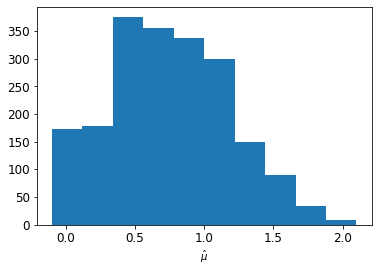

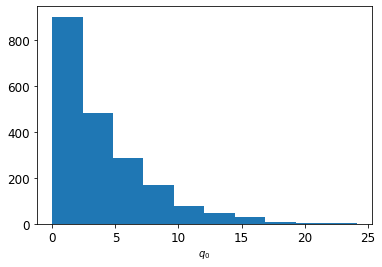

Z BL:(2.134849898926594, 0.7929223692369836, 1.0450000000000002, 2.133360580623875, 0.7648952144605897)
Z:1.6812389993079102
Z_std:1.130147968194191
Z_1:1.5590299879572014
Z_std_1:1.5392420106257343
1
AUC:0.9014372104109232
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

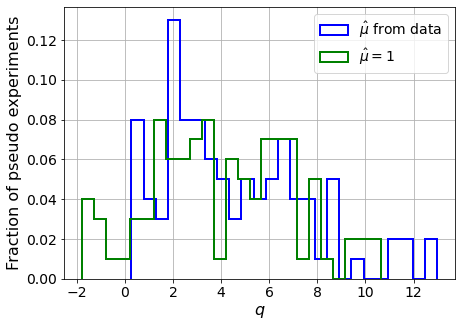

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  6772.96867425  6627.2619732   6431.37032756
  6183.91657849  5870.43833044  5467.24265242  4991.79436027
  4423.83034479  3720.92591781  2873.40334004  1845.75014202
   606.67580077  -884.64012577 -2684.71490176 -5287.64825864]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4121.36313711  4130.2704631
 

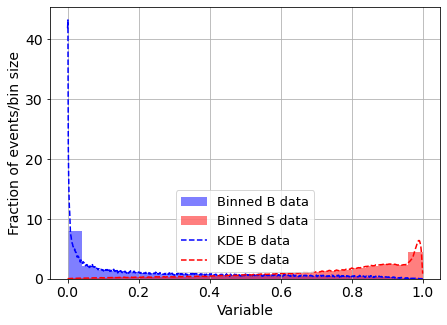

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.014334416738429527
0.014334416738429527
3 done
4 done
0.0
4.9538156765977755e-05


  2%|█                                                                 | 31/2000 [00:10<10:53,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44516092540249214
<p_{s}(Sdata)> = 2.1121500392640016
<p_{b}(Bdata)> = 6.684751671728808
<p_{s}(Bdata)> = 0.4210523326672487


  4%|██▍                                                               | 73/2000 [00:22<07:28,  4.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4711884664545262
<p_{s}(Sdata)> = 2.0655134168309877
<p_{b}(Bdata)> = 6.572880765325298
<p_{s}(Bdata)> = 0.43072132401996094


  4%|██▋                                                               | 82/2000 [00:25<12:04,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3670729603588076
<p_{s}(Sdata)> = 2.0705451906625876
<p_{b}(Bdata)> = 6.649656893641449
<p_{s}(Bdata)> = 0.42656685512611664


  4%|██▊                                                               | 85/2000 [00:26<09:03,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5233556121988877
<p_{s}(Sdata)> = 1.8619333213344793
<p_{b}(Bdata)> = 6.652725773415777
<p_{s}(Bdata)> = 0.42236591950034225


  6%|████                                                             | 124/2000 [00:39<10:52,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4461124348755871
<p_{s}(Sdata)> = 1.9455657539666134
<p_{b}(Bdata)> = 6.688596333182399
<p_{s}(Bdata)> = 0.4250749255742369


  7%|████▍                                                            | 135/2000 [00:43<11:41,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46229559121277825
<p_{s}(Sdata)> = 1.9790201687610838
<p_{b}(Bdata)> = 6.709108723759492
<p_{s}(Bdata)> = 0.418736464409193


  8%|█████                                                            | 157/2000 [00:49<08:54,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41975354060873116
<p_{s}(Sdata)> = 1.8393363835881924
<p_{b}(Bdata)> = 6.666683481990011
<p_{s}(Bdata)> = 0.42430658886417955


  9%|█████▋                                                           | 176/2000 [00:55<08:21,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.430809081432671
<p_{s}(Sdata)> = 1.9114561370729781
<p_{b}(Bdata)> = 6.873138224811636
<p_{s}(Bdata)> = 0.4222030104944038


 10%|██████▎                                                          | 193/2000 [01:00<06:40,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44821976888242104
<p_{s}(Sdata)> = 1.979652711358632
<p_{b}(Bdata)> = 6.8018159780585865
<p_{s}(Bdata)> = 0.4182674627229228
muhat = -0.1
<p_{b}(Sdata)> = 0.47560812929711566
<p_{s}(Sdata)> = 1.5502045972151108
<p_{b}(Bdata)> = 6.756988626688611
<p_{s}(Bdata)> = 0.4219982636370198
muhat = -0.1
<p_{b}(Sdata)> = 0.4482850835315032
<p_{s}(Sdata)> = 2.096725297980833
<p_{b}(Bdata)> = 6.756783743387094
<p_{s}(Bdata)> = 0.4225791704845433


 10%|██████▍                                                          | 197/2000 [01:01<05:48,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44902149259676016
<p_{s}(Sdata)> = 1.7607867949796496
<p_{b}(Bdata)> = 6.87740678538963
<p_{s}(Bdata)> = 0.4215992947549798


 10%|██████▌                                                          | 203/2000 [01:03<09:47,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3923507050084229
<p_{s}(Sdata)> = 2.123544333833038
<p_{b}(Bdata)> = 6.7495067886412
<p_{s}(Bdata)> = 0.42582218378426695


 11%|██████▉                                                          | 213/2000 [01:06<08:03,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5643608825659854
<p_{s}(Sdata)> = 1.9516620039255745
<p_{b}(Bdata)> = 6.566718375945661
<p_{s}(Bdata)> = 0.42436068959201123


 11%|███████                                                          | 218/2000 [01:07<06:58,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4717131908078709
<p_{s}(Sdata)> = 1.7451399097525933
<p_{b}(Bdata)> = 6.785386509720398
<p_{s}(Bdata)> = 0.42030434478732115


 14%|█████████                                                        | 278/2000 [01:25<06:32,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42930932645235076
<p_{s}(Sdata)> = 2.0243449862576037
<p_{b}(Bdata)> = 6.87970381833314
<p_{s}(Bdata)> = 0.4209580169955453


 18%|███████████▉                                                     | 367/2000 [01:54<08:54,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4391192815269893
<p_{s}(Sdata)> = 1.8599498111155783
<p_{b}(Bdata)> = 6.7474767139156295
<p_{s}(Bdata)> = 0.4187085105410281


 22%|██████████████▌                                                  | 447/2000 [02:19<09:53,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4047424113421923
<p_{s}(Sdata)> = 2.1218225302722282
<p_{b}(Bdata)> = 6.845887721303301
<p_{s}(Bdata)> = 0.42040125427821645


 24%|███████████████▊                                                 | 486/2000 [02:33<06:42,  3.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3894101869653793
<p_{s}(Sdata)> = 2.215901826693701
<p_{b}(Bdata)> = 6.770537233064485
<p_{s}(Bdata)> = 0.4306036154317986


 25%|████████████████▎                                                | 500/2000 [02:37<09:15,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4254531626411259
<p_{s}(Sdata)> = 1.988255343086554
<p_{b}(Bdata)> = 6.77858896090088
<p_{s}(Bdata)> = 0.42065843021917576


 26%|████████████████▊                                                | 519/2000 [02:44<08:47,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38191917777300033
<p_{s}(Sdata)> = 2.1161094272403993
<p_{b}(Bdata)> = 6.790318926486215
<p_{s}(Bdata)> = 0.41975262507161515


 26%|█████████████████                                                | 526/2000 [02:46<07:33,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46291710231842553
<p_{s}(Sdata)> = 1.8985684101520206
<p_{b}(Bdata)> = 6.719189127761881
<p_{s}(Bdata)> = 0.42336019258490126


 27%|█████████████████▍                                               | 538/2000 [02:50<07:31,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3909976756510492
<p_{s}(Sdata)> = 2.1121095442396594
<p_{b}(Bdata)> = 6.713996592249315
<p_{s}(Bdata)> = 0.42339185685060615


 28%|██████████████████                                               | 557/2000 [02:55<07:25,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4046521093484792
<p_{s}(Sdata)> = 1.9970450431540498
<p_{b}(Bdata)> = 6.653790295849309
<p_{s}(Bdata)> = 0.4266920877494046


 29%|██████████████████▌                                              | 573/2000 [03:00<08:01,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37184333272854503
<p_{s}(Sdata)> = 2.346893832474144
<p_{b}(Bdata)> = 6.711249740364504
<p_{s}(Bdata)> = 0.4253364722413625


 30%|███████████████████▌                                             | 600/2000 [03:08<06:50,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39809135908266685
<p_{s}(Sdata)> = 2.179663269326836
<p_{b}(Bdata)> = 6.7746417856549
<p_{s}(Bdata)> = 0.4239834996338466


 32%|████████████████████▉                                            | 643/2000 [03:21<04:40,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3950999923070488
<p_{s}(Sdata)> = 2.0918028460742635
<p_{b}(Bdata)> = 6.693321633881402
<p_{s}(Bdata)> = 0.4251504762325639


 34%|█████████████████████▉                                           | 675/2000 [03:31<07:41,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5010048949931449
<p_{s}(Sdata)> = 1.9461424391006963
<p_{b}(Bdata)> = 6.677184933646613
<p_{s}(Bdata)> = 0.4227125629579814


 35%|██████████████████████▌                                          | 696/2000 [03:37<05:41,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4724005882797029
<p_{s}(Sdata)> = 1.7761153460898484
<p_{b}(Bdata)> = 6.7388453151193035
<p_{s}(Bdata)> = 0.4293717634355896


 37%|███████████████████████▊                                         | 732/2000 [03:48<07:58,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141641228618411
<p_{s}(Sdata)> = 1.8852691683496183
<p_{b}(Bdata)> = 6.689512114411168
<p_{s}(Bdata)> = 0.4219415831545239


 37%|████████████████████████▎                                        | 747/2000 [03:53<06:39,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4515677549827457
<p_{s}(Sdata)> = 2.1148435623819473
<p_{b}(Bdata)> = 6.623284451510635
<p_{s}(Bdata)> = 0.4239004022586904


 38%|█████████████████████████                                        | 770/2000 [03:59<06:53,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5330945400211332
<p_{s}(Sdata)> = 1.8688606421775342
<p_{b}(Bdata)> = 6.830462902450744
<p_{s}(Bdata)> = 0.4203051977578214


 39%|█████████████████████████                                        | 773/2000 [04:00<05:55,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4257228846825759
<p_{s}(Sdata)> = 1.722407102109015
<p_{b}(Bdata)> = 6.70606042236462
<p_{s}(Bdata)> = 0.42751944842632955


 40%|█████████████████████████▊                                       | 794/2000 [04:06<05:26,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3891516509757844
<p_{s}(Sdata)> = 2.092211423587847
<p_{b}(Bdata)> = 6.6682864249131075
<p_{s}(Bdata)> = 0.4187673262397878


 41%|██████████████████████████▌                                      | 819/2000 [04:15<08:23,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44112910226714896
<p_{s}(Sdata)> = 2.070981906750736
<p_{b}(Bdata)> = 6.735425660574292
<p_{s}(Bdata)> = 0.41821299907732107


 41%|██████████████████████████▋                                      | 822/2000 [04:15<05:27,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4790148720423851
<p_{s}(Sdata)> = 1.760369521431796
<p_{b}(Bdata)> = 6.666457927699283
<p_{s}(Bdata)> = 0.4203207328982966


 41%|██████████████████████████▉                                      | 829/2000 [04:17<05:00,  3.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4455916355009911
<p_{s}(Sdata)> = 2.0066267853392086
<p_{b}(Bdata)> = 6.625734341301402
<p_{s}(Bdata)> = 0.42852128326498784


 42%|███████████████████████████▍                                     | 846/2000 [04:22<03:52,  4.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3801748910140646
<p_{s}(Sdata)> = 2.2151845090171722
<p_{b}(Bdata)> = 6.721123815727763
<p_{s}(Bdata)> = 0.43015381844740563


 43%|████████████████████████████▏                                    | 867/2000 [04:29<06:11,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43150841884337454
<p_{s}(Sdata)> = 1.7902339232849216
<p_{b}(Bdata)> = 6.781063463898478
<p_{s}(Bdata)> = 0.41932866907759253


 47%|██████████████████████████████▌                                  | 942/2000 [04:54<05:24,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4159875995451705
<p_{s}(Sdata)> = 1.8436571244429536
<p_{b}(Bdata)> = 6.687159817033449
<p_{s}(Bdata)> = 0.4232884839326594


 49%|████████████████████████████████                                 | 986/2000 [05:08<04:37,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45157076803586765
<p_{s}(Sdata)> = 1.7295760568517797
<p_{b}(Bdata)> = 6.587286059604918
<p_{s}(Bdata)> = 0.4260255485994999


 50%|████████████████████████████████▎                                | 995/2000 [05:10<05:37,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3687903952542169
<p_{s}(Sdata)> = 2.0668503506626563
<p_{b}(Bdata)> = 6.77415272474042
<p_{s}(Bdata)> = 0.4183064698237321


 53%|█████████████████████████████████▊                              | 1057/2000 [05:30<05:56,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4520306149617389
<p_{s}(Sdata)> = 1.7162120422110787
<p_{b}(Bdata)> = 6.742458912011207
<p_{s}(Bdata)> = 0.42049038363533375


 54%|██████████████████████████████████▊                             | 1087/2000 [05:39<04:43,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48296849947780757
<p_{s}(Sdata)> = 1.7061547503299583
<p_{b}(Bdata)> = 6.712243835354719
<p_{s}(Bdata)> = 0.4261956474414751


 56%|███████████████████████████████████▉                            | 1124/2000 [05:51<04:40,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4767652345241117
<p_{s}(Sdata)> = 1.604290551055763
<p_{b}(Bdata)> = 6.679130954212601
<p_{s}(Bdata)> = 0.42386880679680194


 56%|████████████████████████████████████▏                           | 1129/2000 [05:52<02:52,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5457595423572998
<p_{s}(Sdata)> = 1.6581195284712795
<p_{b}(Bdata)> = 6.756791505014448
<p_{s}(Bdata)> = 0.4259328023843836


 58%|█████████████████████████████████████▎                          | 1166/2000 [06:04<04:57,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47663994035147744
<p_{s}(Sdata)> = 1.874921988523721
<p_{b}(Bdata)> = 6.852367223711473
<p_{s}(Bdata)> = 0.417189784424229


 59%|█████████████████████████████████████▉                          | 1187/2000 [06:10<04:07,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3670889568187254
<p_{s}(Sdata)> = 2.0663395553584087
<p_{b}(Bdata)> = 6.802176522149099
<p_{s}(Bdata)> = 0.42190511491532445


 60%|██████████████████████████████████████▏                         | 1194/2000 [06:12<03:51,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4805791625621526
<p_{s}(Sdata)> = 1.9341096663924027
<p_{b}(Bdata)> = 6.680026047608387
<p_{s}(Bdata)> = 0.42359034963826536


 61%|███████████████████████████████████████▎                        | 1227/2000 [06:23<04:17,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47338067036115605
<p_{s}(Sdata)> = 1.7586262858392823
<p_{b}(Bdata)> = 6.852163674908956
<p_{s}(Bdata)> = 0.42231254117480804


 62%|███████████████████████████████████████▉                        | 1247/2000 [06:29<03:06,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5347346590476254
<p_{s}(Sdata)> = 1.8853642774098271
<p_{b}(Bdata)> = 6.782284752691749
<p_{s}(Bdata)> = 0.4178660936368127


 63%|████████████████████████████████████████▌                       | 1269/2000 [06:37<03:49,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4379276101007069
<p_{s}(Sdata)> = 1.7365568301466767
<p_{b}(Bdata)> = 6.6338571282954515
<p_{s}(Bdata)> = 0.42695017220732157


 64%|█████████████████████████████████████████                       | 1285/2000 [06:41<02:36,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4164007502110358
<p_{s}(Sdata)> = 1.9843980808726422
<p_{b}(Bdata)> = 6.802180921947063
<p_{s}(Bdata)> = 0.41420157353530385


 64%|█████████████████████████████████████████▏                      | 1289/2000 [06:42<02:53,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4628770504572067
<p_{s}(Sdata)> = 1.8624259136988117
<p_{b}(Bdata)> = 6.805966841620725
<p_{s}(Bdata)> = 0.42405598014281115


 65%|█████████████████████████████████████████▍                      | 1295/2000 [06:44<03:39,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38742154922229805
<p_{s}(Sdata)> = 1.9124871695161252
<p_{b}(Bdata)> = 6.745165111446243
<p_{s}(Bdata)> = 0.4235002925179168


 65%|█████████████████████████████████████████▊                      | 1308/2000 [06:47<02:26,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43458026003981604
<p_{s}(Sdata)> = 1.8326776567948533
<p_{b}(Bdata)> = 6.838862254958607
<p_{s}(Bdata)> = 0.41540966775214133


 67%|██████████████████████████████████████████▊                     | 1337/2000 [06:55<03:30,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4095646989049517
<p_{s}(Sdata)> = 1.9851372224752133
<p_{b}(Bdata)> = 6.821520022477613
<p_{s}(Bdata)> = 0.41949238505967285


 67%|███████████████████████████████████████████                     | 1347/2000 [06:59<04:08,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4719526955297577
<p_{s}(Sdata)> = 2.0163309846439437
<p_{b}(Bdata)> = 6.680744342828727
<p_{s}(Bdata)> = 0.4202023021407382


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [07:23<02:30,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3965373128867493
<p_{s}(Sdata)> = 2.1877546536221617
<p_{b}(Bdata)> = 6.801768869188355
<p_{s}(Bdata)> = 0.4222537629258444
muhat = -0.1
<p_{b}(Sdata)> = 0.4484618072327961
<p_{s}(Sdata)> = 1.8607479504920799
<p_{b}(Bdata)> = 6.862354048522982
<p_{s}(Bdata)> = 0.42195715648972515


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [07:29<02:53,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4718387736566325
<p_{s}(Sdata)> = 1.787508522940504
<p_{b}(Bdata)> = 6.715974020647655
<p_{s}(Bdata)> = 0.4267616668598148


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [07:31<02:43,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39685720248157635
<p_{s}(Sdata)> = 2.100210949039095
<p_{b}(Bdata)> = 6.651026317069909
<p_{s}(Bdata)> = 0.42520062077561793


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [07:32<02:29,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43659088752202546
<p_{s}(Sdata)> = 1.8622162358733902
<p_{b}(Bdata)> = 6.600640783909933
<p_{s}(Bdata)> = 0.42255718762820066


 73%|██████████████████████████████████████████████▊                 | 1463/2000 [07:34<02:35,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5755035107537224
<p_{s}(Sdata)> = 1.6795345825474464
<p_{b}(Bdata)> = 6.6674654513020855
<p_{s}(Bdata)> = 0.42476723583769416


 74%|███████████████████████████████████████████████▍                | 1484/2000 [07:41<02:09,  3.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3835694046015783
<p_{s}(Sdata)> = 2.209719748618303
<p_{b}(Bdata)> = 6.822486702668805
<p_{s}(Bdata)> = 0.43350787411484426


 75%|███████████████████████████████████████████████▊                | 1495/2000 [07:44<01:50,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37776805928807866
<p_{s}(Sdata)> = 1.8960288984418454
<p_{b}(Bdata)> = 6.703310274293404
<p_{s}(Bdata)> = 0.42619286860295635


 75%|███████████████████████████████████████████████▊                | 1496/2000 [07:44<02:20,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4915875855016559
<p_{s}(Sdata)> = 1.853275736258771
<p_{b}(Bdata)> = 6.714671874812034
<p_{s}(Bdata)> = 0.42346355244491696


 75%|████████████████████████████████████████████████                | 1501/2000 [07:46<02:21,  3.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38561250508715894
<p_{s}(Sdata)> = 2.179366888390717
<p_{b}(Bdata)> = 6.583279166400779
<p_{s}(Bdata)> = 0.43491946641177726


 78%|█████████████████████████████████████████████████▋              | 1551/2000 [08:03<02:35,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45012238125065324
<p_{s}(Sdata)> = 1.9374834090504354
<p_{b}(Bdata)> = 6.63785771727039
<p_{s}(Bdata)> = 0.41916330778079175


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [08:19<02:16,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5337691788765477
<p_{s}(Sdata)> = 1.8623827775403579
<p_{b}(Bdata)> = 6.754427087060676
<p_{s}(Bdata)> = 0.4238371924184559


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [08:41<01:14,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37975325059039994
<p_{s}(Sdata)> = 1.9806920149290257
<p_{b}(Bdata)> = 6.531256713074339
<p_{s}(Bdata)> = 0.4214651934085616


 88%|████████████████████████████████████████████████████████        | 1752/2000 [09:06<00:55,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5675352800574789
<p_{s}(Sdata)> = 1.903651500185404
<p_{b}(Bdata)> = 6.742306110885969
<p_{s}(Bdata)> = 0.42511420251195187


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [09:18<01:09,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5041298041920698
<p_{s}(Sdata)> = 2.090515144296491
<p_{b}(Bdata)> = 6.604164931833726
<p_{s}(Bdata)> = 0.41931422803244134


 91%|██████████████████████████████████████████████████████████▏     | 1819/2000 [09:28<01:04,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4301812468037907
<p_{s}(Sdata)> = 1.96805954516094
<p_{b}(Bdata)> = 6.807565176568115
<p_{s}(Bdata)> = 0.42720015378455617


 92%|███████████████████████████████████████████████████████████▏    | 1849/2000 [09:37<00:40,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43236704330617154
<p_{s}(Sdata)> = 2.123161444372852
<p_{b}(Bdata)> = 6.6943501884189525
<p_{s}(Bdata)> = 0.4208701218367034


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [09:52<00:37,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4012598404063907
<p_{s}(Sdata)> = 2.087513474808066
<p_{b}(Bdata)> = 6.629485190853064
<p_{s}(Bdata)> = 0.4171387032718842


 97%|██████████████████████████████████████████████████████████████▎ | 1949/2000 [10:09<00:19,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4148316865320487
<p_{s}(Sdata)> = 1.9686305739747763
<p_{b}(Bdata)> = 6.736719323303111
<p_{s}(Bdata)> = 0.4243298615403428


 98%|██████████████████████████████████████████████████████████████▍ | 1953/2000 [10:10<00:12,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4538899661243405
<p_{s}(Sdata)> = 2.110051784100191
<p_{b}(Bdata)> = 6.741534983632669
<p_{s}(Bdata)> = 0.4228756520815744


 99%|███████████████████████████████████████████████████████████████▌| 1987/2000 [10:21<00:03,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45793531771503965
<p_{s}(Sdata)> = 1.710555265575576
<p_{b}(Bdata)> = 6.8105393121749
<p_{s}(Bdata)> = 0.4224931971895716


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [10:24<00:00,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.50271301217964
<p_{s}(Sdata)> = 1.8868973261112163
<p_{b}(Bdata)> = 6.683115784886758
<p_{s}(Bdata)> = 0.4209066669955189


100%|████████████████████████████████████████████████████████████████| 2000/2000 [10:25<00:00,  3.20it/s]


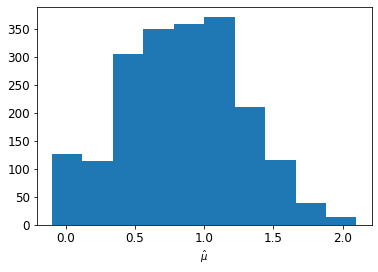

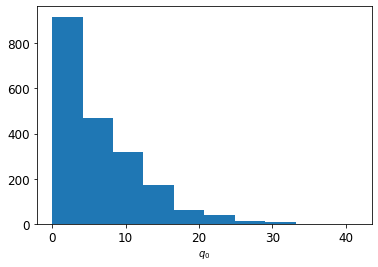

Z BL:(1.938879901244835, 0.7793089022008259, 1.0305000000000002, 1.9376297367944866, 0.7590389428510366)
Z:2.1806136568270347
Z_std:1.3449580913669792
Z_1:2.1358515919987484
Z_std_1:1.53365823445856
2
AUC:0.9020180790291324
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

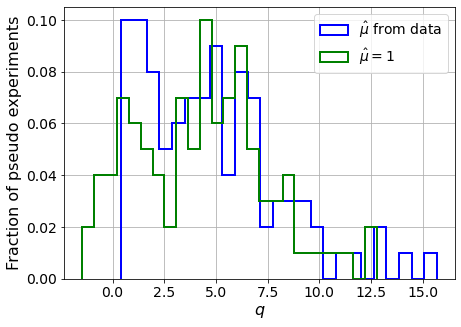

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  6829.37223784
  6556.59519941  6212.13306809  5792.00976584  5278.42930992
  4649.83073582  3885.71532172  2969.41980854  1896.43243901
   614.95641547  -909.05000017 -2735.96280974 -5309.82912101]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  4212.15167881  4252.80271972  4276.77135832  4288.66474293


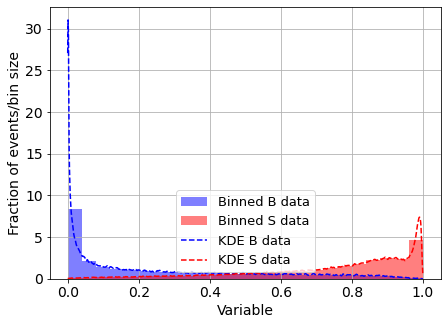

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.012179352137196469
0.012179352137196469
3 done
4 done
0.0042864713569786385
0.0042864713569786385


  0%|▏                                                                  | 4/2000 [00:01<09:57,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48953174701262453
<p_{s}(Sdata)> = 2.0277827736217597
<p_{b}(Bdata)> = 5.953343406969636
<p_{s}(Bdata)> = 0.4207579318213973


  0%|▏                                                                  | 7/2000 [00:01<08:10,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41415255231722276
<p_{s}(Sdata)> = 2.175140572915404
<p_{b}(Bdata)> = 5.953224107739247
<p_{s}(Bdata)> = 0.4188697636803621


  1%|▊                                                                 | 26/2000 [00:06<07:03,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5091803976127239
<p_{s}(Sdata)> = 1.7750042086227964
<p_{b}(Bdata)> = 6.061448787278761
<p_{s}(Bdata)> = 0.42075305895218823


  1%|▉                                                                 | 29/2000 [00:07<09:02,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4231243257090804
<p_{s}(Sdata)> = 1.986220063246201
<p_{b}(Bdata)> = 6.005181855541428
<p_{s}(Bdata)> = 0.4203253058407659


  2%|█▍                                                                | 42/2000 [00:10<10:26,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47395094787626146
<p_{s}(Sdata)> = 1.6347519918970708
<p_{b}(Bdata)> = 6.013857559103894
<p_{s}(Bdata)> = 0.4269740614283777


  3%|█▊                                                                | 55/2000 [00:14<09:01,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4770115168434439
<p_{s}(Sdata)> = 1.9849649195807721
<p_{b}(Bdata)> = 5.9747295366002815
<p_{s}(Bdata)> = 0.4237879364494457


  3%|█▉                                                                | 57/2000 [00:15<07:35,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37593663872891975
<p_{s}(Sdata)> = 2.3473685690236605
<p_{b}(Bdata)> = 6.033792863476162
<p_{s}(Bdata)> = 0.420856872092423


  7%|████▎                                                            | 131/2000 [00:33<06:08,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38500647654864883
<p_{s}(Sdata)> = 2.2893723853669177
<p_{b}(Bdata)> = 6.040151316051661
<p_{s}(Bdata)> = 0.4233092902735965


  7%|████▍                                                            | 135/2000 [00:33<05:05,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47732027920226483
<p_{s}(Sdata)> = 1.71797348991419
<p_{b}(Bdata)> = 5.991644583164372
<p_{s}(Bdata)> = 0.42136209818519055


  7%|████▌                                                            | 141/2000 [00:35<05:16,  5.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4406114199977139
<p_{s}(Sdata)> = 1.9389369038989122
<p_{b}(Bdata)> = 5.991066028263286
<p_{s}(Bdata)> = 0.4236476593085446


  7%|████▊                                                            | 149/2000 [00:36<04:35,  6.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4857992904118295
<p_{s}(Sdata)> = 1.9619291617855632
<p_{b}(Bdata)> = 6.062626628938874
<p_{s}(Bdata)> = 0.4207098388499193
muhat = -0.1
<p_{b}(Sdata)> = 0.45502637387038364
<p_{s}(Sdata)> = 1.9716049831922282
<p_{b}(Bdata)> = 6.063774083276958
<p_{s}(Bdata)> = 0.41733493075727035


  8%|████▉                                                            | 153/2000 [00:37<07:22,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.422471664373696
<p_{s}(Sdata)> = 2.2609930009230976
<p_{b}(Bdata)> = 5.940880673549517
<p_{s}(Bdata)> = 0.41731336825303517


  8%|█████                                                            | 157/2000 [00:38<07:35,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.427617481006577
<p_{s}(Sdata)> = 2.1009001038766586
<p_{b}(Bdata)> = 6.058720323407344
<p_{s}(Bdata)> = 0.42063750900790814


  8%|█████▍                                                           | 166/2000 [00:40<05:57,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4102501536106325
<p_{s}(Sdata)> = 2.313824001581907
<p_{b}(Bdata)> = 6.027635809866353
<p_{s}(Bdata)> = 0.4185987512316249


  9%|█████▋                                                           | 176/2000 [00:42<04:22,  6.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3859728684941987
<p_{s}(Sdata)> = 2.29336464470707
<p_{b}(Bdata)> = 5.971158617239853
<p_{s}(Bdata)> = 0.42223907263212457
muhat = -0.1
<p_{b}(Sdata)> = 0.4352434577892125
<p_{s}(Sdata)> = 2.075339410867978
<p_{b}(Bdata)> = 5.974816530818364
<p_{s}(Bdata)> = 0.41906432578562586


  9%|█████▊                                                           | 179/2000 [00:43<07:47,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4903300332845839
<p_{s}(Sdata)> = 2.0407668253204365
<p_{b}(Bdata)> = 5.985999512465397
<p_{s}(Bdata)> = 0.4226491959508077


  9%|██████                                                           | 185/2000 [00:45<06:31,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3714582702829202
<p_{s}(Sdata)> = 2.473071930660179
<p_{b}(Bdata)> = 6.010701417919141
<p_{s}(Bdata)> = 0.4236087636809934


 10%|██████▊                                                          | 209/2000 [00:50<05:19,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4535532166936923
<p_{s}(Sdata)> = 2.015557662858065
<p_{b}(Bdata)> = 6.027827122381174
<p_{s}(Bdata)> = 0.4213892140491317


 11%|██████▉                                                          | 212/2000 [00:51<06:57,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.379749485208238
<p_{s}(Sdata)> = 2.138911762927607
<p_{b}(Bdata)> = 5.958408341898274
<p_{s}(Bdata)> = 0.42016794049652556


 11%|███████                                                          | 217/2000 [00:51<04:53,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39758966640774496
<p_{s}(Sdata)> = 2.3883139850664397
<p_{b}(Bdata)> = 6.001745798014476
<p_{s}(Bdata)> = 0.42544102819823193


 11%|███████▏                                                         | 221/2000 [00:53<07:39,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46100337560274884
<p_{s}(Sdata)> = 1.795614995653209
<p_{b}(Bdata)> = 5.958988855718153
<p_{s}(Bdata)> = 0.42259753463861804


 11%|███████▍                                                         | 227/2000 [00:54<07:11,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3755385209331908
<p_{s}(Sdata)> = 2.1866174096154736
<p_{b}(Bdata)> = 5.9963971511278675
<p_{s}(Bdata)> = 0.4221289788495583


 12%|████████▏                                                        | 250/2000 [01:00<07:16,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4037503535126
<p_{s}(Sdata)> = 2.185025689176142
<p_{b}(Bdata)> = 5.977381763297109
<p_{s}(Bdata)> = 0.42112968022804786


 13%|████████▎                                                        | 255/2000 [01:02<08:01,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47408900510364527
<p_{s}(Sdata)> = 1.967861943393166
<p_{b}(Bdata)> = 5.881761378429647
<p_{s}(Bdata)> = 0.42553079349909045


 13%|████████▌                                                        | 264/2000 [01:03<04:51,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4973434863270799
<p_{s}(Sdata)> = 2.0230164606539875
<p_{b}(Bdata)> = 5.924841206138568
<p_{s}(Bdata)> = 0.417899008396177


 13%|████████▋                                                        | 266/2000 [01:04<06:25,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3996824409080838
<p_{s}(Sdata)> = 1.921061305338438
<p_{b}(Bdata)> = 6.120756385842745
<p_{s}(Bdata)> = 0.4239821399526786


 14%|████████▊                                                        | 271/2000 [01:05<04:29,  6.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4854341912191178
<p_{s}(Sdata)> = 1.7673995205145503
<p_{b}(Bdata)> = 5.987512248910496
<p_{s}(Bdata)> = 0.4237632981525348
muhat = -0.1
<p_{b}(Sdata)> = 0.45564458356889714
<p_{s}(Sdata)> = 1.9767439899983719
<p_{b}(Bdata)> = 6.018830804211698
<p_{s}(Bdata)> = 0.4212226964972402


 14%|█████████                                                        | 278/2000 [01:06<05:27,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4203324017348816
<p_{s}(Sdata)> = 2.1463378827438793
<p_{b}(Bdata)> = 6.067319946409204
<p_{s}(Bdata)> = 0.42072586291253733
muhat = -0.1
<p_{b}(Sdata)> = 0.486743692997455
<p_{s}(Sdata)> = 1.8461232529554186
<p_{b}(Bdata)> = 6.022581096627382
<p_{s}(Bdata)> = 0.4206694362615129


 15%|█████████▍                                                       | 292/2000 [01:10<07:45,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40804569809643676
<p_{s}(Sdata)> = 2.4003066051608144
<p_{b}(Bdata)> = 6.041948654643509
<p_{s}(Bdata)> = 0.4315004748882044


 15%|█████████▌                                                       | 294/2000 [01:10<07:32,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4445375562852644
<p_{s}(Sdata)> = 1.7669709486269467
<p_{b}(Bdata)> = 6.069757497237179
<p_{s}(Bdata)> = 0.41949203028332466


 15%|█████████▋                                                       | 297/2000 [01:11<07:24,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5476314146483527
<p_{s}(Sdata)> = 1.8117752704081926
<p_{b}(Bdata)> = 6.016916024984723
<p_{s}(Bdata)> = 0.4244586219947494


 15%|█████████▉                                                       | 307/2000 [01:14<09:51,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4349214457592034
<p_{s}(Sdata)> = 2.142168356967997
<p_{b}(Bdata)> = 5.9789152275164845
<p_{s}(Bdata)> = 0.42041368599650547


 16%|██████████▏                                                      | 313/2000 [01:15<06:01,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42722363932026625
<p_{s}(Sdata)> = 1.9716305007665065
<p_{b}(Bdata)> = 5.9312504087842965
<p_{s}(Bdata)> = 0.4214353734534304
muhat = -0.1
<p_{b}(Sdata)> = 0.545022849289554
<p_{s}(Sdata)> = 1.876370418757244
<p_{b}(Bdata)> = 6.0749762928194215
<p_{s}(Bdata)> = 0.42013091533709157


 16%|██████████▎                                                      | 317/2000 [01:16<05:38,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5156360024653527
<p_{s}(Sdata)> = 1.9737173182781744
<p_{b}(Bdata)> = 6.008184423937946
<p_{s}(Bdata)> = 0.4211169585018518


 17%|██████████▊                                                      | 331/2000 [01:19<07:09,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3931215102201019
<p_{s}(Sdata)> = 2.3013854236426927
<p_{b}(Bdata)> = 5.946513664455767
<p_{s}(Bdata)> = 0.4194283227052268


 18%|███████████▌                                                     | 356/2000 [01:24<04:14,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4299706031649254
<p_{s}(Sdata)> = 2.0717400582920478
<p_{b}(Bdata)> = 5.948107410558325
<p_{s}(Bdata)> = 0.42228170384450575
muhat = -0.1
<p_{b}(Sdata)> = 0.41110967848659663
<p_{s}(Sdata)> = 2.0897369726161417
<p_{b}(Bdata)> = 5.970061000030315
<p_{s}(Bdata)> = 0.42029338404236305
muhat = -0.1
<p_{b}(Sdata)> = 0.43502487937862727
<p_{s}(Sdata)> = 1.9476112411757396
<p_{b}(Bdata)> = 6.064775215197921
<p_{s}(Bdata)> = 0.42557187095869004


 18%|███████████▋                                                     | 360/2000 [01:25<04:55,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4143405718680639
<p_{s}(Sdata)> = 2.237982328220154
<p_{b}(Bdata)> = 5.9737113605406185
<p_{s}(Bdata)> = 0.4169143845490559


 18%|███████████▉                                                     | 368/2000 [01:27<04:42,  5.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43282074911572277
<p_{s}(Sdata)> = 2.050560396267075
<p_{b}(Bdata)> = 6.035251414634799
<p_{s}(Bdata)> = 0.4193957535099914
muhat = -0.1
<p_{b}(Sdata)> = 0.4630220054611953
<p_{s}(Sdata)> = 2.0950084026361164
<p_{b}(Bdata)> = 5.968883671004893
<p_{s}(Bdata)> = 0.4190447038275079


 19%|████████████▎                                                    | 379/2000 [01:30<08:22,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5694084385580679
<p_{s}(Sdata)> = 1.9338976365729381
<p_{b}(Bdata)> = 5.993553085589419
<p_{s}(Bdata)> = 0.4235665324232836


 19%|████████████▍                                                    | 383/2000 [01:31<07:01,  3.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36349738814165333
<p_{s}(Sdata)> = 2.5501318689457944
<p_{b}(Bdata)> = 5.970597890590529
<p_{s}(Bdata)> = 0.4320566484836133


 20%|█████████████▎                                                   | 410/2000 [01:37<06:53,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43813215605386574
<p_{s}(Sdata)> = 2.2918395711713524
<p_{b}(Bdata)> = 5.9754508418850225
<p_{s}(Bdata)> = 0.41784938183697684


 21%|█████████████▌                                                   | 419/2000 [01:39<05:33,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3987552552034228
<p_{s}(Sdata)> = 2.233091224992487
<p_{b}(Bdata)> = 5.952921631083496
<p_{s}(Bdata)> = 0.421697799789552


 21%|█████████████▊                                                   | 426/2000 [01:41<07:37,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47143007020664135
<p_{s}(Sdata)> = 1.8739695257937024
<p_{b}(Bdata)> = 6.062821217079807
<p_{s}(Bdata)> = 0.4219037201014767


 22%|██████████████                                                   | 433/2000 [01:43<07:56,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4654456074477552
<p_{s}(Sdata)> = 2.40776319599053
<p_{b}(Bdata)> = 6.085196186027823
<p_{s}(Bdata)> = 0.4192106201320466


 22%|██████████████▎                                                  | 441/2000 [01:45<05:24,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4288720262450415
<p_{s}(Sdata)> = 2.0181343182436637
<p_{b}(Bdata)> = 6.015174705120722
<p_{s}(Bdata)> = 0.42025880617975353


 22%|██████████████▍                                                  | 446/2000 [01:46<07:45,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.384638831879148
<p_{s}(Sdata)> = 2.182895151268286
<p_{b}(Bdata)> = 5.992625169590284
<p_{s}(Bdata)> = 0.4148249078715322


 23%|██████████████▉                                                  | 460/2000 [01:49<04:07,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44254044322514696
<p_{s}(Sdata)> = 1.921444770111102
<p_{b}(Bdata)> = 5.913555101178419
<p_{s}(Bdata)> = 0.4249023444392092
muhat = -0.1
<p_{b}(Sdata)> = 0.4960860295021744
<p_{s}(Sdata)> = 1.8816843266926515
<p_{b}(Bdata)> = 6.035632527763414
<p_{s}(Bdata)> = 0.4184473253345703


 23%|███████████████▏                                                 | 466/2000 [01:51<05:41,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46908252464127714
<p_{s}(Sdata)> = 1.6661721766609798
<p_{b}(Bdata)> = 5.957931106164486
<p_{s}(Bdata)> = 0.4215622308857519


 24%|███████████████▋                                                 | 482/2000 [01:54<04:15,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49281935257603254
<p_{s}(Sdata)> = 2.034395116032991
<p_{b}(Bdata)> = 6.091902365595409
<p_{s}(Bdata)> = 0.41668596735692254


 24%|███████████████▊                                                 | 486/2000 [01:55<06:48,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4176866245545428
<p_{s}(Sdata)> = 1.892115954792357
<p_{b}(Bdata)> = 6.014497929581186
<p_{s}(Bdata)> = 0.42070202214014657


 25%|████████████████                                                 | 496/2000 [01:57<05:03,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4386667935407797
<p_{s}(Sdata)> = 2.0315505366996556
<p_{b}(Bdata)> = 5.916231586712578
<p_{s}(Bdata)> = 0.4241364096209242


 25%|████████████████▍                                                | 504/2000 [01:59<03:57,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3991542899413739
<p_{s}(Sdata)> = 2.3891066395721565
<p_{b}(Bdata)> = 6.078284695728693
<p_{s}(Bdata)> = 0.41772096871068165
muhat = -0.1
<p_{b}(Sdata)> = 0.41864643794412326
<p_{s}(Sdata)> = 2.042428762176009
<p_{b}(Bdata)> = 6.011635831559031
<p_{s}(Bdata)> = 0.4195662149994528


 25%|████████████████▍                                                | 507/2000 [02:00<06:27,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4384972178912003
<p_{s}(Sdata)> = 2.2961892313064913
<p_{b}(Bdata)> = 6.032856080282325
<p_{s}(Bdata)> = 0.42263507156889957


 26%|████████████████▊                                                | 516/2000 [02:01<03:41,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40992646010812805
<p_{s}(Sdata)> = 2.1808486580275557
<p_{b}(Bdata)> = 5.902302385318422
<p_{s}(Bdata)> = 0.425072756681833
muhat = -0.1
<p_{b}(Sdata)> = 0.4808898123708377
<p_{s}(Sdata)> = 1.8515308978517058
<p_{b}(Bdata)> = 5.965711990715925
<p_{s}(Bdata)> = 0.42072664749483


 26%|████████████████▊                                                | 518/2000 [02:02<04:28,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44160987005943636
<p_{s}(Sdata)> = 2.134712204294387
<p_{b}(Bdata)> = 6.008422551963441
<p_{s}(Bdata)> = 0.420418105496758


 26%|█████████████████▏                                               | 530/2000 [02:05<05:43,  4.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39311524143904086
<p_{s}(Sdata)> = 2.4319439508936096
<p_{b}(Bdata)> = 5.9088265637232915
<p_{s}(Bdata)> = 0.43188239321403993


 27%|█████████████████▍                                               | 538/2000 [02:06<05:29,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40832906343071196
<p_{s}(Sdata)> = 2.1060818443088407
<p_{b}(Bdata)> = 5.96636583208926
<p_{s}(Bdata)> = 0.4267423181511799


 28%|█████████████████▉                                               | 551/2000 [02:09<04:52,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4686633812122457
<p_{s}(Sdata)> = 1.9150514500782725
<p_{b}(Bdata)> = 6.027823493795125
<p_{s}(Bdata)> = 0.42000203240791234
muhat = -0.1
<p_{b}(Sdata)> = 0.4409928001456345
<p_{s}(Sdata)> = 2.079408544039267
<p_{b}(Bdata)> = 6.003293437833062
<p_{s}(Bdata)> = 0.41981598681514015


 28%|██████████████████▎                                              | 563/2000 [02:12<04:31,  5.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.44601954403864935
<p_{s}(Sdata)> = 2.3641439382386777
<p_{b}(Bdata)> = 5.827522303290108
<p_{s}(Bdata)> = 0.43657815637818387


 28%|██████████████████▎                                              | 564/2000 [02:12<05:17,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43032163481095237
<p_{s}(Sdata)> = 1.8857469810265335
<p_{b}(Bdata)> = 6.0202295375442505
<p_{s}(Bdata)> = 0.4240246287867999


 29%|███████████████████▏                                             | 589/2000 [02:18<03:46,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4189321306073712
<p_{s}(Sdata)> = 2.0266552199498173
<p_{b}(Bdata)> = 6.067487129419844
<p_{s}(Bdata)> = 0.42089523778628674
muhat = -0.1
<p_{b}(Sdata)> = 0.4698202194330804
<p_{s}(Sdata)> = 1.8760999754407748
<p_{b}(Bdata)> = 5.941272177844233
<p_{s}(Bdata)> = 0.4242963332464441


 30%|███████████████████▎                                             | 594/2000 [02:20<05:16,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41759746823676674
<p_{s}(Sdata)> = 2.281888831174938
<p_{b}(Bdata)> = 6.036756171634463
<p_{s}(Bdata)> = 0.42261078781230593


 31%|████████████████████                                             | 617/2000 [02:26<04:42,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44158715534958126
<p_{s}(Sdata)> = 1.9573674574310094
<p_{b}(Bdata)> = 6.020551769857833
<p_{s}(Bdata)> = 0.4202481622534525


 32%|████████████████████▌                                            | 632/2000 [02:29<05:23,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46812658663828144
<p_{s}(Sdata)> = 2.0405541062460464
<p_{b}(Bdata)> = 6.125142773087079
<p_{s}(Bdata)> = 0.42149478472037444


 32%|████████████████████▊                                            | 639/2000 [02:31<06:29,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46891595439860295
<p_{s}(Sdata)> = 1.7774595333616083
<p_{b}(Bdata)> = 5.894544111751786
<p_{s}(Bdata)> = 0.42102302934145686


 33%|█████████████████████▌                                           | 662/2000 [02:36<03:38,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4650586494163266
<p_{s}(Sdata)> = 1.6333756711032705
<p_{b}(Bdata)> = 5.970361404637282
<p_{s}(Bdata)> = 0.4253529609220277
muhat = -0.1
<p_{b}(Sdata)> = 0.37355458439279327
<p_{s}(Sdata)> = 2.3865826458608694
<p_{b}(Bdata)> = 5.928765740400072
<p_{s}(Bdata)> = 0.4221116455854411


 33%|█████████████████████▋                                           | 667/2000 [02:37<05:15,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4828923788892537
<p_{s}(Sdata)> = 1.847389450358361
<p_{b}(Bdata)> = 5.980543824374352
<p_{s}(Bdata)> = 0.4255455287035057


 34%|█████████████████████▊                                           | 672/2000 [02:38<04:11,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46157520572616695
<p_{s}(Sdata)> = 2.046103556181574
<p_{b}(Bdata)> = 6.050614503105842
<p_{s}(Bdata)> = 0.42289787888869024


 34%|██████████████████████                                           | 680/2000 [02:40<07:17,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4135478064633231
<p_{s}(Sdata)> = 2.1123418852076
<p_{b}(Bdata)> = 6.033860701471441
<p_{s}(Bdata)> = 0.4210407584419235


 35%|██████████████████████▌                                          | 693/2000 [02:43<04:16,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47053417365232025
<p_{s}(Sdata)> = 1.8687931665792157
<p_{b}(Bdata)> = 5.978867047347305
<p_{s}(Bdata)> = 0.4270912049678764


 35%|██████████████████████▊                                          | 700/2000 [02:45<04:22,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4025702915872112
<p_{s}(Sdata)> = 2.3120265832194073
<p_{b}(Bdata)> = 6.005618685009306
<p_{s}(Bdata)> = 0.4234723433378728


 36%|███████████████████████                                          | 710/2000 [02:48<05:55,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38486084593740394
<p_{s}(Sdata)> = 2.344317494382977
<p_{b}(Bdata)> = 6.003063902695481
<p_{s}(Bdata)> = 0.4213627452851336


 36%|███████████████████████▋                                         | 727/2000 [02:52<03:52,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.463063625242006
<p_{s}(Sdata)> = 1.9930528021886402
<p_{b}(Bdata)> = 5.987647230945778
<p_{s}(Bdata)> = 0.4230270322306763


 37%|███████████████████████▊                                         | 734/2000 [02:53<03:14,  6.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42554138400684416
<p_{s}(Sdata)> = 2.093213401127499
<p_{b}(Bdata)> = 5.949839713891988
<p_{s}(Bdata)> = 0.4209701539636728


 37%|████████████████████████▏                                        | 746/2000 [02:56<05:37,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5515590513114761
<p_{s}(Sdata)> = 1.8286951809229428
<p_{b}(Bdata)> = 6.05281597885714
<p_{s}(Bdata)> = 0.42424366662024016


 38%|████████████████████████▋                                        | 759/2000 [03:00<04:24,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4496049086955094
<p_{s}(Sdata)> = 1.884636058868594
<p_{b}(Bdata)> = 6.002124792147341
<p_{s}(Bdata)> = 0.41894780461047193


 38%|████████████████████████▊                                        | 763/2000 [03:01<04:56,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4494520820194743
<p_{s}(Sdata)> = 1.9916342741572532
<p_{b}(Bdata)> = 6.003312171412724
<p_{s}(Bdata)> = 0.41874470861765667


 38%|████████████████████████▉                                        | 766/2000 [03:01<04:44,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4307490658429928
<p_{s}(Sdata)> = 1.9156614629682245
<p_{b}(Bdata)> = 5.993195127886946
<p_{s}(Bdata)> = 0.422743470790642


 39%|█████████████████████████                                        | 771/2000 [03:03<05:11,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4692146096387913
<p_{s}(Sdata)> = 1.8379876931926349
<p_{b}(Bdata)> = 5.909893539077862
<p_{s}(Bdata)> = 0.4220116067987408


 39%|█████████████████████████▏                                       | 775/2000 [03:03<04:28,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4234777220857349
<p_{s}(Sdata)> = 2.084014549106398
<p_{b}(Bdata)> = 5.9500331542902165
<p_{s}(Bdata)> = 0.4215409352041384


 39%|█████████████████████████▌                                       | 788/2000 [03:06<05:24,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44004311857605555
<p_{s}(Sdata)> = 2.1129363255106663
<p_{b}(Bdata)> = 5.929726686775303
<p_{s}(Bdata)> = 0.42633360860194974


 40%|█████████████████████████▊                                       | 795/2000 [03:08<04:21,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37721236204308556
<p_{s}(Sdata)> = 2.184782094607725
<p_{b}(Bdata)> = 5.973142308814249
<p_{s}(Bdata)> = 0.4191128704510822


 40%|██████████████████████████▏                                      | 804/2000 [03:10<05:54,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41498798907473433
<p_{s}(Sdata)> = 2.203246647119324
<p_{b}(Bdata)> = 5.98984910146932
<p_{s}(Bdata)> = 0.41689491359868475


 40%|██████████████████████████▎                                      | 808/2000 [03:11<05:42,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44325715155962814
<p_{s}(Sdata)> = 1.9713580800575052
<p_{b}(Bdata)> = 6.051529105158801
<p_{s}(Bdata)> = 0.42217248770691435


 41%|██████████████████████████▍                                      | 815/2000 [03:13<05:02,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37844450648983624
<p_{s}(Sdata)> = 1.9480222882916904
<p_{b}(Bdata)> = 5.965375619354049
<p_{s}(Bdata)> = 0.4178354592091652


 42%|███████████████████████████▎                                     | 841/2000 [03:19<03:11,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4127086239489664
<p_{s}(Sdata)> = 2.113966694003435
<p_{b}(Bdata)> = 6.0545838919808395
<p_{s}(Bdata)> = 0.4185163355423947


 43%|███████████████████████████▊                                     | 857/2000 [03:23<04:57,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44364191479994686
<p_{s}(Sdata)> = 2.1116876905467925
<p_{b}(Bdata)> = 6.08903072217012
<p_{s}(Bdata)> = 0.4265402820537002


 43%|████████████████████████████                                     | 862/2000 [03:24<03:27,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4617146177639731
<p_{s}(Sdata)> = 1.8751430410202505
<p_{b}(Bdata)> = 6.122982306288493
<p_{s}(Bdata)> = 0.41967979872875677
muhat = -0.1
<p_{b}(Sdata)> = 0.4337983095842703
<p_{s}(Sdata)> = 1.8992643053464902
<p_{b}(Bdata)> = 5.9842472993404865
<p_{s}(Bdata)> = 0.4240264809524521


 44%|████████████████████████████▌                                    | 879/2000 [03:29<03:55,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48526345302886315
<p_{s}(Sdata)> = 1.8982444747066425
<p_{b}(Bdata)> = 5.975756578737203
<p_{s}(Bdata)> = 0.42040216648482814
muhat = -0.1
<p_{b}(Sdata)> = 0.4001118895762892
<p_{s}(Sdata)> = 2.402365642248213
<p_{b}(Bdata)> = 5.987698534243976
<p_{s}(Bdata)> = 0.41992255455790506


 44%|████████████████████████████▋                                    | 884/2000 [03:30<05:24,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5238565355480637
<p_{s}(Sdata)> = 1.9166665127179914
<p_{b}(Bdata)> = 6.040404209507801
<p_{s}(Bdata)> = 0.4192803549154139


 45%|█████████████████████████████                                    | 893/2000 [03:32<05:02,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3786158381400504
<p_{s}(Sdata)> = 2.098496818721316
<p_{b}(Bdata)> = 6.0115806085404495
<p_{s}(Bdata)> = 0.42594307733535236


 45%|█████████████████████████████▏                                   | 898/2000 [03:33<03:04,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41164795014971944
<p_{s}(Sdata)> = 2.1463690558666557
<p_{b}(Bdata)> = 6.049244738296353
<p_{s}(Bdata)> = 0.4219158249981729


 46%|█████████████████████████████▉                                   | 923/2000 [03:39<03:50,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4011970629095796
<p_{s}(Sdata)> = 2.2527215311210607
<p_{b}(Bdata)> = 6.0610168781922376
<p_{s}(Bdata)> = 0.41905254895044175


 47%|██████████████████████████████▎                                  | 931/2000 [03:41<03:10,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48289040307788716
<p_{s}(Sdata)> = 2.1047606797605654
<p_{b}(Bdata)> = 6.007506155705808
<p_{s}(Bdata)> = 0.41974890301547796
muhat = -0.1
<p_{b}(Sdata)> = 0.4233542185635825
<p_{s}(Sdata)> = 1.9914396889934134
<p_{b}(Bdata)> = 5.992955928817328
<p_{s}(Bdata)> = 0.42610584910944277


 47%|██████████████████████████████▍                                  | 935/2000 [03:42<03:55,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42847798881608623
<p_{s}(Sdata)> = 2.00117711003266
<p_{b}(Bdata)> = 5.931696678213626
<p_{s}(Bdata)> = 0.4228784330593281


 47%|██████████████████████████████▌                                  | 941/2000 [03:43<03:28,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45446900393029166
<p_{s}(Sdata)> = 2.0738170240653027
<p_{b}(Bdata)> = 6.128412801184108
<p_{s}(Bdata)> = 0.4164279967441919


 48%|███████████████████████████████                                  | 956/2000 [03:46<02:41,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5347514295842689
<p_{s}(Sdata)> = 1.6931211362310177
<p_{b}(Bdata)> = 5.930382068578724
<p_{s}(Bdata)> = 0.42855975878691543
muhat = -0.1
<p_{b}(Sdata)> = 0.4547425448298749
<p_{s}(Sdata)> = 1.982080155146142
<p_{b}(Bdata)> = 6.042345087787546
<p_{s}(Bdata)> = 0.4215068739402888


 48%|███████████████████████████████▍                                 | 969/2000 [03:49<02:53,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.548456945972421
<p_{s}(Sdata)> = 2.0259286889248753
<p_{b}(Bdata)> = 6.017482390032637
<p_{s}(Bdata)> = 0.4198811226354223


 49%|███████████████████████████████▌                                 | 971/2000 [03:49<02:34,  6.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47852090966208294
<p_{s}(Sdata)> = 1.8431734889013625
<p_{b}(Bdata)> = 6.053978452849406
<p_{s}(Bdata)> = 0.41683955742067924


 49%|███████████████████████████████▊                                 | 977/2000 [03:51<04:33,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4276072330293678
<p_{s}(Sdata)> = 2.1648021703195677
<p_{b}(Bdata)> = 6.005891751774517
<p_{s}(Bdata)> = 0.4207169599054423


 50%|████████████████████████████████▎                                | 996/2000 [03:55<03:43,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4608070627483599
<p_{s}(Sdata)> = 1.9340851562693029
<p_{b}(Bdata)> = 5.970915223128609
<p_{s}(Bdata)> = 0.4238748528164271


 50%|████████████████████████████████▍                                | 999/2000 [03:56<03:14,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3896144289716883
<p_{s}(Sdata)> = 2.3621163867887165
<p_{b}(Bdata)> = 5.9339508041026505
<p_{s}(Bdata)> = 0.42154928462835445


 51%|████████████████████████████████▉                               | 1028/2000 [04:04<04:42,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40609371311881026
<p_{s}(Sdata)> = 2.1094373165886493
<p_{b}(Bdata)> = 6.00886855876511
<p_{s}(Bdata)> = 0.42257178253109473


 52%|█████████████████████████████████                               | 1034/2000 [04:05<03:08,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39048322118634476
<p_{s}(Sdata)> = 2.221999485401642
<p_{b}(Bdata)> = 6.099013470645487
<p_{s}(Bdata)> = 0.4195228258193032


 52%|█████████████████████████████████▌                              | 1048/2000 [04:09<04:14,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4163508583126733
<p_{s}(Sdata)> = 2.03375992829978
<p_{b}(Bdata)> = 5.893991473912722
<p_{s}(Bdata)> = 0.42676887296684735


 53%|██████████████████████████████████                              | 1063/2000 [04:13<02:38,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37138100395542634
<p_{s}(Sdata)> = 2.522651355411571
<p_{b}(Bdata)> = 6.0640302464293665
<p_{s}(Bdata)> = 0.4225817329208837
muhat = -0.1
<p_{b}(Sdata)> = 0.5628512272158744
<p_{s}(Sdata)> = 1.66041742253215
<p_{b}(Bdata)> = 6.056820396621294
<p_{s}(Bdata)> = 0.4220576964193807


 53%|██████████████████████████████████▏                             | 1068/2000 [04:14<03:26,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6029661984445637
<p_{s}(Sdata)> = 1.7011639993849292
<p_{b}(Bdata)> = 6.182363960619722
<p_{s}(Bdata)> = 0.4177697363628838


 54%|██████████████████████████████████▎                             | 1071/2000 [04:15<03:07,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4202940442814968
<p_{s}(Sdata)> = 2.2535797855183777
<p_{b}(Bdata)> = 5.969783033706707
<p_{s}(Bdata)> = 0.42453067101876324


 54%|██████████████████████████████████▌                             | 1080/2000 [04:17<04:22,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39292661241159127
<p_{s}(Sdata)> = 2.0706678867781516
<p_{b}(Bdata)> = 5.98255475686059
<p_{s}(Bdata)> = 0.4198409331571061


 54%|██████████████████████████████████▊                             | 1087/2000 [04:19<03:44,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41986632790630096
<p_{s}(Sdata)> = 2.1763512765874657
<p_{b}(Bdata)> = 6.058381708579181
<p_{s}(Bdata)> = 0.41668641800978073


 55%|███████████████████████████████████                             | 1097/2000 [04:22<03:42,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.420697429777099
<p_{s}(Sdata)> = 2.016503269749534
<p_{b}(Bdata)> = 5.992856236748164
<p_{s}(Bdata)> = 0.4287020819058679


 55%|███████████████████████████████████▏                            | 1099/2000 [04:22<03:13,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42625855833134096
<p_{s}(Sdata)> = 2.0488997449031876
<p_{b}(Bdata)> = 5.93293416991502
<p_{s}(Bdata)> = 0.424675681284733


 55%|███████████████████████████████████▍                            | 1107/2000 [04:24<03:15,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5060498497294915
<p_{s}(Sdata)> = 1.9563465346613027
<p_{b}(Bdata)> = 5.932709563227795
<p_{s}(Bdata)> = 0.42233541303556016


 56%|████████████████████████████████████                            | 1126/2000 [04:29<03:28,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8858379270467215
<p_{s}(Sdata)> = 1.9033074036232267
<p_{b}(Bdata)> = 5.998918567716834
<p_{s}(Bdata)> = 0.4198976765578087


 57%|████████████████████████████████████▎                           | 1136/2000 [04:31<02:34,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.411363812785213
<p_{s}(Sdata)> = 2.2098627403088162
<p_{b}(Bdata)> = 5.984367758924278
<p_{s}(Bdata)> = 0.42086091859285757
muhat = -0.1
<p_{b}(Sdata)> = 0.41866720002604174
<p_{s}(Sdata)> = 1.9104783179663158
<p_{b}(Bdata)> = 5.996736054852886
<p_{s}(Bdata)> = 0.41937561589742095


 58%|█████████████████████████████████████                           | 1160/2000 [04:38<02:55,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.463811191351117
<p_{s}(Sdata)> = 1.8102393022089451
<p_{b}(Bdata)> = 5.944821609973362
<p_{s}(Bdata)> = 0.42752522346649346


 58%|█████████████████████████████████████▍                          | 1168/2000 [04:39<02:04,  6.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4071385181209428
<p_{s}(Sdata)> = 2.0521557787805276
<p_{b}(Bdata)> = 5.8813173377310175
<p_{s}(Bdata)> = 0.42474839187325114
muhat = -0.1
<p_{b}(Sdata)> = 0.42771332823213903
<p_{s}(Sdata)> = 1.9760182468255236
<p_{b}(Bdata)> = 5.920598340001525
<p_{s}(Bdata)> = 0.4264994870595149


 59%|█████████████████████████████████████▌                          | 1172/2000 [04:40<03:10,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4081444589310576
<p_{s}(Sdata)> = 2.149129103615511
<p_{b}(Bdata)> = 5.99083771763131
<p_{s}(Bdata)> = 0.42497703616827065


 59%|█████████████████████████████████████▋                          | 1177/2000 [04:41<02:49,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41511435487535475
<p_{s}(Sdata)> = 2.13054678352208
<p_{b}(Bdata)> = 6.0610354532554656
<p_{s}(Bdata)> = 0.4197751568010415


 59%|█████████████████████████████████████▊                          | 1180/2000 [04:42<02:12,  6.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4157043446329989
<p_{s}(Sdata)> = 2.1203808502219768
<p_{b}(Bdata)> = 5.951127366256262
<p_{s}(Bdata)> = 0.4281560621461183
muhat = -0.1
<p_{b}(Sdata)> = 0.3912803659681562
<p_{s}(Sdata)> = 2.1204047867570948
<p_{b}(Bdata)> = 5.9672338699107925
<p_{s}(Bdata)> = 0.4237283880305071


 60%|██████████████████████████████████████▋                         | 1208/2000 [04:49<03:02,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.403255229691381
<p_{s}(Sdata)> = 2.1668852513551378
<p_{b}(Bdata)> = 5.937233779592847
<p_{s}(Bdata)> = 0.4218132893173519


 61%|██████████████████████████████████████▉                         | 1216/2000 [04:50<02:27,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5864447235915307
<p_{s}(Sdata)> = 1.5721038391525166
<p_{b}(Bdata)> = 5.976475327451107
<p_{s}(Bdata)> = 0.42454177775034724


 62%|███████████████████████████████████████▊                        | 1244/2000 [04:58<04:21,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.391191853714813
<p_{s}(Sdata)> = 2.0580761814045267
<p_{b}(Bdata)> = 5.987063230674338
<p_{s}(Bdata)> = 0.4184065001993261


 63%|████████████████████████████████████████▎                       | 1259/2000 [05:02<03:21,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.499887594145036
<p_{s}(Sdata)> = 2.0455872586742734
<p_{b}(Bdata)> = 6.019439166329751
<p_{s}(Bdata)> = 0.4245303145432275


 63%|████████████████████████████████████████▎                       | 1261/2000 [05:02<02:35,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37133916527603683
<p_{s}(Sdata)> = 2.377077509317067
<p_{b}(Bdata)> = 5.909004223931626
<p_{s}(Bdata)> = 0.4199051383412057


 63%|████████████████████████████████████████▌                       | 1266/2000 [05:03<02:42,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.432961159297144
<p_{s}(Sdata)> = 1.9575247923625199
<p_{b}(Bdata)> = 6.08639702869117
<p_{s}(Bdata)> = 0.4270356904630609


 64%|████████████████████████████████████████▊                       | 1275/2000 [05:06<03:32,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47284696897074646
<p_{s}(Sdata)> = 2.138714141144188
<p_{b}(Bdata)> = 5.971998507949652
<p_{s}(Bdata)> = 0.42251436132640424


 64%|████████████████████████████████████████▉                       | 1280/2000 [05:07<02:48,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8102896511374658
<p_{s}(Sdata)> = 1.9488144662181865
<p_{b}(Bdata)> = 6.012869290960514
<p_{s}(Bdata)> = 0.4206844891525936


 64%|█████████████████████████████████████████                       | 1285/2000 [05:08<02:12,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5692893315764428
<p_{s}(Sdata)> = 2.2187858307795283
<p_{b}(Bdata)> = 5.966293679410895
<p_{s}(Bdata)> = 0.41580747508455995


 64%|█████████████████████████████████████████▏                      | 1289/2000 [05:09<02:15,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43524542450165415
<p_{s}(Sdata)> = 1.9024429626796273
<p_{b}(Bdata)> = 5.944712139377304
<p_{s}(Bdata)> = 0.42466640276086326


 65%|█████████████████████████████████████████▍                      | 1293/2000 [05:10<02:29,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4302215322952425
<p_{s}(Sdata)> = 2.0834413743911324
<p_{b}(Bdata)> = 6.072096884331262
<p_{s}(Bdata)> = 0.4150757416968486


 65%|█████████████████████████████████████████▌                      | 1299/2000 [05:11<03:24,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4394710660103036
<p_{s}(Sdata)> = 1.9665162715206619
<p_{b}(Bdata)> = 6.001277399627282
<p_{s}(Bdata)> = 0.42518408523320833


 65%|█████████████████████████████████████████▋                      | 1301/2000 [05:12<03:07,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4824637374449864
<p_{s}(Sdata)> = 1.9779791091254049
<p_{b}(Bdata)> = 5.9994739378150514
<p_{s}(Bdata)> = 0.4191672925603836


 66%|██████████████████████████████████████████                      | 1314/2000 [05:14<01:52,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43314686520725
<p_{s}(Sdata)> = 2.1733526791935773
<p_{b}(Bdata)> = 5.965795771666642
<p_{s}(Bdata)> = 0.41622223560323607
muhat = -0.1
<p_{b}(Sdata)> = 0.45285905588066744
<p_{s}(Sdata)> = 2.061066831735777
<p_{b}(Bdata)> = 5.997179627759251
<p_{s}(Bdata)> = 0.4204313615269458


 66%|██████████████████████████████████████████▍                     | 1325/2000 [05:17<02:02,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46982898821778984
<p_{s}(Sdata)> = 1.9946063159602332
<p_{b}(Bdata)> = 5.92184834979759
<p_{s}(Bdata)> = 0.42220515439765927
muhat = -0.1
<p_{b}(Sdata)> = 0.5446579981400363
<p_{s}(Sdata)> = 1.863271030452133
<p_{b}(Bdata)> = 5.986224737037213
<p_{s}(Bdata)> = 0.41854278800628764


 67%|██████████████████████████████████████████▉                     | 1342/2000 [05:21<03:07,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4306292200974692
<p_{s}(Sdata)> = 2.0940228478638168
<p_{b}(Bdata)> = 5.970549098548626
<p_{s}(Bdata)> = 0.42194376668134154


 68%|███████████████████████████████████████████▎                    | 1354/2000 [05:24<02:55,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43509705371387225
<p_{s}(Sdata)> = 1.8505607245431166
<p_{b}(Bdata)> = 5.9492901340011075
<p_{s}(Bdata)> = 0.42599739913649787


 68%|███████████████████████████████████████████▍                    | 1357/2000 [05:25<02:38,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4219659208243995
<p_{s}(Sdata)> = 2.1696939612767157
<p_{b}(Bdata)> = 6.012795632604327
<p_{s}(Bdata)> = 0.42025431353925885


 69%|████████████████████████████████████████████                    | 1375/2000 [05:29<01:46,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4676545955511732
<p_{s}(Sdata)> = 2.1228464568385066
<p_{b}(Bdata)> = 6.030275710640576
<p_{s}(Bdata)> = 0.42100455442341117


 69%|████████████████████████████████████████████▏                   | 1380/2000 [05:30<01:58,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4695240704432806
<p_{s}(Sdata)> = 1.8900414316349183
<p_{b}(Bdata)> = 6.035560158211924
<p_{s}(Bdata)> = 0.4210807276272336


 69%|████████████████████████████████████████████▎                   | 1386/2000 [05:31<01:58,  5.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4234080617703928
<p_{s}(Sdata)> = 2.4775509556620285
<p_{b}(Bdata)> = 5.998211469355751
<p_{s}(Bdata)> = 0.43205436087543153


 70%|████████████████████████████████████████████▌                   | 1392/2000 [05:33<02:24,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3782111459642349
<p_{s}(Sdata)> = 2.274474200035924
<p_{b}(Bdata)> = 6.003071057589483
<p_{s}(Bdata)> = 0.4185827734049492


 70%|████████████████████████████████████████████▋                   | 1398/2000 [05:34<01:50,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35095148132177056
<p_{s}(Sdata)> = 2.4781362415152905
<p_{b}(Bdata)> = 5.91624105011172
<p_{s}(Bdata)> = 0.4202681886371622


 70%|████████████████████████████████████████████▊                   | 1400/2000 [05:35<02:03,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5283265171542133
<p_{s}(Sdata)> = 1.919062161872076
<p_{b}(Bdata)> = 6.011661605340196
<p_{s}(Bdata)> = 0.4163996782991277


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [05:38<02:27,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44389355840795525
<p_{s}(Sdata)> = 2.0739659147596954
<p_{b}(Bdata)> = 6.073163501718114
<p_{s}(Bdata)> = 0.4239476130394435


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [05:38<01:43,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4642183836717494
<p_{s}(Sdata)> = 1.8854024995795997
<p_{b}(Bdata)> = 6.1022075216661555
<p_{s}(Bdata)> = 0.42026657099397363


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [05:39<01:24,  6.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4634829769343968
<p_{s}(Sdata)> = 1.7713104466033236
<p_{b}(Bdata)> = 5.989512875243713
<p_{s}(Bdata)> = 0.4225511836051046
muhat = -0.1
<p_{b}(Sdata)> = 0.4438846169511411
<p_{s}(Sdata)> = 1.94027348895339
<p_{b}(Bdata)> = 5.945650493004488
<p_{s}(Bdata)> = 0.4236169036552825


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [05:40<01:43,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42204500620435803
<p_{s}(Sdata)> = 2.098551801240966
<p_{b}(Bdata)> = 6.100982788501388
<p_{s}(Bdata)> = 0.4187783861697652


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [05:42<02:22,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4019438661350663
<p_{s}(Sdata)> = 2.184556796984809
<p_{b}(Bdata)> = 5.849245725851887
<p_{s}(Bdata)> = 0.42283286627966965


 72%|██████████████████████████████████████████████                  | 1439/2000 [05:43<02:08,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282554981810139
<p_{s}(Sdata)> = 2.1155424859958094
<p_{b}(Bdata)> = 6.081991560366684
<p_{s}(Bdata)> = 0.4200259934031752


 73%|██████████████████████████████████████████████▊                 | 1462/2000 [05:49<01:48,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41370740954463775
<p_{s}(Sdata)> = 2.2420871748257247
<p_{b}(Bdata)> = 5.8810730993598686
<p_{s}(Bdata)> = 0.426363671397432


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [05:49<01:51,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41816519079864317
<p_{s}(Sdata)> = 2.179194859368356
<p_{b}(Bdata)> = 5.983409935839592
<p_{s}(Bdata)> = 0.42376826841746873


 74%|███████████████████████████████████████████████▏                | 1475/2000 [05:52<01:44,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4868968394941868
<p_{s}(Sdata)> = 2.0217949898862155
<p_{b}(Bdata)> = 5.9278251702603075
<p_{s}(Bdata)> = 0.4279482461695602
muhat = -0.1
<p_{b}(Sdata)> = 0.4204634282892423
<p_{s}(Sdata)> = 2.0202123895508075
<p_{b}(Bdata)> = 6.018295575851877
<p_{s}(Bdata)> = 0.42409013822415376


 74%|███████████████████████████████████████████████▍                | 1482/2000 [05:54<02:02,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39322139254476346
<p_{s}(Sdata)> = 2.1936520498808734
<p_{b}(Bdata)> = 6.003937024289018
<p_{s}(Bdata)> = 0.4260947115242108


 75%|███████████████████████████████████████████████▉                | 1499/2000 [05:58<01:38,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47492294967147897
<p_{s}(Sdata)> = 2.0029554242503806
<p_{b}(Bdata)> = 5.903544605445448
<p_{s}(Bdata)> = 0.42580577254990853
muhat = -0.1
<p_{b}(Sdata)> = 0.4864551050827035
<p_{s}(Sdata)> = 2.0546477632058076
<p_{b}(Bdata)> = 5.949311655670986
<p_{s}(Bdata)> = 0.42315250519129544


 76%|████████████████████████████████████████████████▍               | 1515/2000 [06:02<02:01,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4456466440071587
<p_{s}(Sdata)> = 1.8475387602024624
<p_{b}(Bdata)> = 6.029549588256573
<p_{s}(Bdata)> = 0.4224857204984951


 76%|████████████████████████████████████████████████▌               | 1517/2000 [06:03<02:10,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4563009229708494
<p_{s}(Sdata)> = 1.8429937564294958
<p_{b}(Bdata)> = 6.062920283153184
<p_{s}(Bdata)> = 0.42211194693399073


 76%|████████████████████████████████████████████████▋               | 1521/2000 [06:04<01:39,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43778795694830636
<p_{s}(Sdata)> = 2.1687317019955175
<p_{b}(Bdata)> = 5.991061744203422
<p_{s}(Bdata)> = 0.4213692641951994


 77%|█████████████████████████████████████████████████▏              | 1537/2000 [06:09<02:07,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4454023119187414
<p_{s}(Sdata)> = 2.0460724295124306
<p_{b}(Bdata)> = 6.1622290564596955
<p_{s}(Bdata)> = 0.41787878869745426


 78%|█████████████████████████████████████████████████▋              | 1554/2000 [06:12<01:43,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47552194442353074
<p_{s}(Sdata)> = 2.17740892064647
<p_{b}(Bdata)> = 5.992500187013563
<p_{s}(Bdata)> = 0.4196728333837022


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [06:16<01:21,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48321662653794745
<p_{s}(Sdata)> = 1.9007767209659263
<p_{b}(Bdata)> = 5.949880257295582
<p_{s}(Bdata)> = 0.42211922184624695


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [06:17<01:05,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6773115412692092
<p_{s}(Sdata)> = 1.7310447356467025
<p_{b}(Bdata)> = 5.948909546637394
<p_{s}(Bdata)> = 0.4204012621572447
muhat = -0.1
<p_{b}(Sdata)> = 0.5708632065174758
<p_{s}(Sdata)> = 1.881920295570843
<p_{b}(Bdata)> = 5.828865223645601
<p_{s}(Bdata)> = 0.42788397156529995


 79%|██████████████████████████████████████████████████▊             | 1587/2000 [06:20<01:52,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46926013106617726
<p_{s}(Sdata)> = 1.8253291583866487
<p_{b}(Bdata)> = 5.995172816718133
<p_{s}(Bdata)> = 0.4247132648780613


 80%|███████████████████████████████████████████████████             | 1597/2000 [06:23<01:53,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3335666668070854
<p_{s}(Sdata)> = 2.724186955549414
<p_{b}(Bdata)> = 6.015105431308191
<p_{s}(Bdata)> = 0.41696424943375915


 80%|███████████████████████████████████████████████████▌            | 1610/2000 [06:26<01:50,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5535657371963162
<p_{s}(Sdata)> = 1.7909686662963797
<p_{b}(Bdata)> = 5.951715502551815
<p_{s}(Bdata)> = 0.42847805366516944


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [06:27<01:27,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41537080232496537
<p_{s}(Sdata)> = 2.119609743890082
<p_{b}(Bdata)> = 6.008300657944859
<p_{s}(Bdata)> = 0.4259171179704402


 82%|████████████████████████████████████████████████████▎           | 1634/2000 [06:32<01:30,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42764335969195827
<p_{s}(Sdata)> = 2.112231496953369
<p_{b}(Bdata)> = 5.9589684475268525
<p_{s}(Bdata)> = 0.4201412188792668


 83%|█████████████████████████████████████████████████████           | 1658/2000 [06:38<01:09,  4.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4364945177702629
<p_{s}(Sdata)> = 1.9856769173189388
<p_{b}(Bdata)> = 6.064398625561465
<p_{s}(Bdata)> = 0.42722676668729553


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [06:39<01:00,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4330740627395318
<p_{s}(Sdata)> = 1.992699131589141
<p_{b}(Bdata)> = 6.019501958047359
<p_{s}(Bdata)> = 0.41989993024551064


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [06:40<00:57,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45540126595552627
<p_{s}(Sdata)> = 1.7429834156147952
<p_{b}(Bdata)> = 5.975067768514737
<p_{s}(Bdata)> = 0.4269742461461986


 84%|█████████████████████████████████████████████████████▌          | 1672/2000 [06:40<00:51,  6.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4549841725817391
<p_{s}(Sdata)> = 2.047799788431136
<p_{b}(Bdata)> = 6.022940403513462
<p_{s}(Bdata)> = 0.42114334645365975
muhat = -0.1
<p_{b}(Sdata)> = 0.4454641168203679
<p_{s}(Sdata)> = 1.948360222823864
<p_{b}(Bdata)> = 5.974459379540313
<p_{s}(Bdata)> = 0.41908394884016886


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [06:41<00:45,  7.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5227099076334093
<p_{s}(Sdata)> = 1.6724454297882674
<p_{b}(Bdata)> = 6.075319788374361
<p_{s}(Bdata)> = 0.42217487370949447
muhat = -0.1
<p_{b}(Sdata)> = 0.42543726271661053
<p_{s}(Sdata)> = 2.07256101976001
<p_{b}(Bdata)> = 5.989707850435805
<p_{s}(Bdata)> = 0.4197826889306547


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [06:43<01:25,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4509728612496349
<p_{s}(Sdata)> = 1.8252086036072541
<p_{b}(Bdata)> = 6.024470861142874
<p_{s}(Bdata)> = 0.42104708595224166


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [06:45<01:05,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39694815190875293
<p_{s}(Sdata)> = 2.105944541924171
<p_{b}(Bdata)> = 5.891776361032079
<p_{s}(Bdata)> = 0.4242216310839816


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [06:48<01:15,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4655638644736002
<p_{s}(Sdata)> = 1.833685169039976
<p_{b}(Bdata)> = 6.06470608353479
<p_{s}(Bdata)> = 0.42079241616754914


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [06:48<01:04,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5034439746860159
<p_{s}(Sdata)> = 1.8575872143284478
<p_{b}(Bdata)> = 5.96438343216962
<p_{s}(Bdata)> = 0.4195346389004555


 86%|██████████████████████████████████████████████████████▉         | 1715/2000 [06:51<00:58,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48547271353942023
<p_{s}(Sdata)> = 1.8939060740306926
<p_{b}(Bdata)> = 5.9560106637635135
<p_{s}(Bdata)> = 0.42092007425170075


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [06:53<01:00,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47800233069684456
<p_{s}(Sdata)> = 1.840029031867903
<p_{b}(Bdata)> = 6.005604309417602
<p_{s}(Bdata)> = 0.42177433014902677


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [07:03<00:56,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4683845588848953
<p_{s}(Sdata)> = 1.879536431377648
<p_{b}(Bdata)> = 6.1065716441388425
<p_{s}(Bdata)> = 0.41844295008412563


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [07:04<00:45,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39698102413470376
<p_{s}(Sdata)> = 2.305939730718209
<p_{b}(Bdata)> = 5.907066344792713
<p_{s}(Bdata)> = 0.4227648052358482


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [07:06<01:01,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4752478860921913
<p_{s}(Sdata)> = 1.7521552159885905
<p_{b}(Bdata)> = 6.003522355173749
<p_{s}(Bdata)> = 0.4197313952993197


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [07:09<00:47,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4284665957888231
<p_{s}(Sdata)> = 2.1519180637809945
<p_{b}(Bdata)> = 5.9572008541242365
<p_{s}(Bdata)> = 0.42290492790380335


 90%|█████████████████████████████████████████████████████████▌      | 1800/2000 [07:11<00:54,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4276082903543288
<p_{s}(Sdata)> = 2.027334383854945
<p_{b}(Bdata)> = 6.055310561158164
<p_{s}(Bdata)> = 0.4260417669600259


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [07:17<00:33,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7497802927563565
<p_{s}(Sdata)> = 2.143352562105051
<p_{b}(Bdata)> = 5.987852120181042
<p_{s}(Bdata)> = 0.41889005606116636
muhat = -0.1
<p_{b}(Sdata)> = 0.4729876112401107
<p_{s}(Sdata)> = 1.9974708612245695
<p_{b}(Bdata)> = 6.170645590175349
<p_{s}(Bdata)> = 0.417372972760276


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [07:18<00:35,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.455999652068765
<p_{s}(Sdata)> = 1.9270988860673355
<p_{b}(Bdata)> = 6.023077756265442
<p_{s}(Bdata)> = 0.42358464396198847


 93%|███████████████████████████████████████████████████████████▎    | 1852/2000 [07:22<00:35,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4379735196925793
<p_{s}(Sdata)> = 2.1468140930206117
<p_{b}(Bdata)> = 5.924440515989439
<p_{s}(Bdata)> = 0.42156619020580144


 93%|███████████████████████████████████████████████████████████▌    | 1861/2000 [07:25<00:36,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4206395758639754
<p_{s}(Sdata)> = 2.2287894651556788
<p_{b}(Bdata)> = 6.084354025586143
<p_{s}(Bdata)> = 0.4200369830663808


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [07:29<00:33,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4053586872522154
<p_{s}(Sdata)> = 2.0935351556849775
<p_{b}(Bdata)> = 6.068489302958903
<p_{s}(Bdata)> = 0.41898667237091997


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [07:30<00:31,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.391844103813645
<p_{s}(Sdata)> = 2.496729454142424
<p_{b}(Bdata)> = 5.940036642957669
<p_{s}(Bdata)> = 0.4241120259263518


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [07:31<00:35,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45551821329527503
<p_{s}(Sdata)> = 1.9836739086204531
<p_{b}(Bdata)> = 5.958916805953465
<p_{s}(Bdata)> = 0.4186431405691963


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [07:36<00:16,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4569283978411587
<p_{s}(Sdata)> = 1.9546178797675673
<p_{b}(Bdata)> = 5.980935137748266
<p_{s}(Bdata)> = 0.4229431604834669
muhat = -0.1
<p_{b}(Sdata)> = 0.5232195359778432
<p_{s}(Sdata)> = 1.928514341610698
<p_{b}(Bdata)> = 5.910609092200197
<p_{s}(Bdata)> = 0.4245066131002402


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [07:38<00:21,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47706018414915896
<p_{s}(Sdata)> = 1.98517805724722
<p_{b}(Bdata)> = 5.991427743616299
<p_{s}(Bdata)> = 0.41886623034942877


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:41<00:15,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6211894657384596
<p_{s}(Sdata)> = 1.9824124900695135
<p_{b}(Bdata)> = 6.09090280820323
<p_{s}(Bdata)> = 0.4210517590834969
muhat = -0.1
<p_{b}(Sdata)> = 0.5747436788747823
<p_{s}(Sdata)> = 1.9984717289275977
<p_{b}(Bdata)> = 5.891956508060594
<p_{s}(Bdata)> = 0.42767181686677264


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [07:41<00:13,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4977545863851378
<p_{s}(Sdata)> = 1.9904294265742648
<p_{b}(Bdata)> = 5.999834334888929
<p_{s}(Bdata)> = 0.41991850340368064


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [07:45<00:10,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4129357946702649
<p_{s}(Sdata)> = 2.582489517503453
<p_{b}(Bdata)> = 6.020720521248218
<p_{s}(Bdata)> = 0.4166220950126443


 98%|██████████████████████████████████████████████████████████████▋ | 1959/2000 [07:48<00:08,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41687494193041685
<p_{s}(Sdata)> = 2.08749489122548
<p_{b}(Bdata)> = 5.990338659791068
<p_{s}(Bdata)> = 0.41998322324736026


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [07:53<00:03,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4415510157045633
<p_{s}(Sdata)> = 2.11365267608069
<p_{b}(Bdata)> = 5.879694718966144
<p_{s}(Bdata)> = 0.425272151970568
muhat = -0.1
<p_{b}(Sdata)> = 0.5280964227248905
<p_{s}(Sdata)> = 2.0345721258395875
<p_{b}(Bdata)> = 6.091363505141557
<p_{s}(Bdata)> = 0.4177567663598963


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [07:55<00:05,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4663215572694699
<p_{s}(Sdata)> = 2.252654901129132
<p_{b}(Bdata)> = 6.018725611419824
<p_{s}(Bdata)> = 0.4247266167192717


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [07:57<00:01,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41788038646904047
<p_{s}(Sdata)> = 2.0077385471207365
<p_{b}(Bdata)> = 5.975377303615564
<p_{s}(Bdata)> = 0.42392398397533776


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:58<00:00,  4.18it/s]


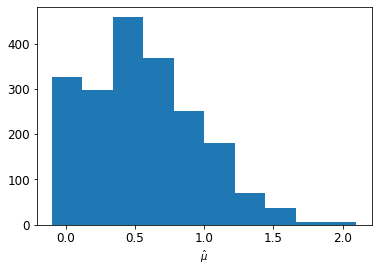

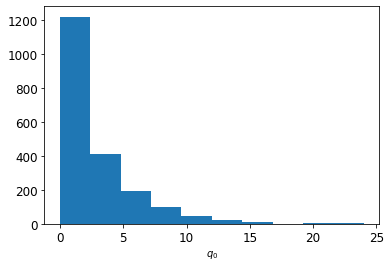

Z BL:(2.09831690599898, 0.7795200730241819, 1.0075, 2.0989948019091336, 0.7535820820819641)
Z:1.2706034225981728
Z_std:1.2308462657807597
Z_1:0.5525250209956913
Z_std_1:4.403428603487484
3
AUC:0.9019957392366562
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

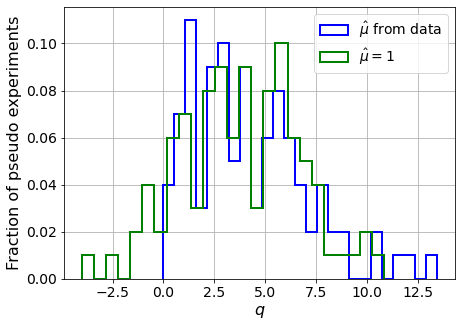

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6972.23780413  6744.6023763
  6460.86508442  6109.54490175  5677.17270208  5173.25403576
  4555.81927935  3810.74289562  2918.21637816  1856.67588376
   594.57444677  -914.55586771 -2734.11819412 -5311.01000403]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  4283.27588455  4323.51294907  4341.13073886  4343.27906589
 

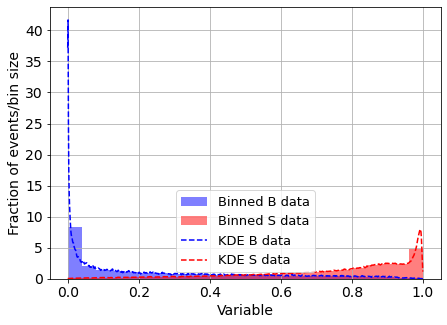

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.026773599148138923
0.026773599148138923
3 done
4 done
0.0
0.0005306705140617899


  0%|▏                                                                  | 6/2000 [00:01<06:45,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.430249215725075
<p_{s}(Sdata)> = 1.9855094473350685
<p_{b}(Bdata)> = 6.896132532206992
<p_{s}(Bdata)> = 0.4223333510940332


  2%|█▏                                                                | 36/2000 [00:10<09:30,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47359142665905124
<p_{s}(Sdata)> = 1.8987129105794465
<p_{b}(Bdata)> = 6.887256735218288
<p_{s}(Bdata)> = 0.41767755573652093


  2%|█▍                                                                | 44/2000 [00:12<08:34,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44769802548157805
<p_{s}(Sdata)> = 2.0078890541177614
<p_{b}(Bdata)> = 6.756794003524244
<p_{s}(Bdata)> = 0.42153433940478524


  4%|██▊                                                               | 84/2000 [00:21<04:58,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40160989991214296
<p_{s}(Sdata)> = 2.1310840754218003
<p_{b}(Bdata)> = 6.860221689851191
<p_{s}(Bdata)> = 0.4233360152276821
muhat = -0.1
<p_{b}(Sdata)> = 0.43590233826246916
<p_{s}(Sdata)> = 2.170976414670989
<p_{b}(Bdata)> = 6.718341348847208
<p_{s}(Bdata)> = 0.41896872518317496


  6%|███▊                                                             | 116/2000 [00:30<06:29,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3916320168487398
<p_{s}(Sdata)> = 2.1030947453325584
<p_{b}(Bdata)> = 6.833156867025165
<p_{s}(Bdata)> = 0.4237327294641636


  6%|████                                                             | 126/2000 [00:31<05:09,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41390699673429354
<p_{s}(Sdata)> = 2.100352470477225
<p_{b}(Bdata)> = 6.919141915663063
<p_{s}(Bdata)> = 0.4156835108110486


  7%|████▍                                                            | 138/2000 [00:34<06:05,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4736823482382325
<p_{s}(Sdata)> = 1.8838005685595414
<p_{b}(Bdata)> = 7.03578630733382
<p_{s}(Bdata)> = 0.4214796525823961


  7%|████▌                                                            | 141/2000 [00:35<07:57,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.444809162322283
<p_{s}(Sdata)> = 1.9512719652700818
<p_{b}(Bdata)> = 6.835117511635689
<p_{s}(Bdata)> = 0.4226583235383851


  7%|████▊                                                            | 147/2000 [00:36<05:17,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328583177952387
<p_{s}(Sdata)> = 2.126585152440236
<p_{b}(Bdata)> = 6.759081836056024
<p_{s}(Bdata)> = 0.41799480506574466
muhat = -0.1
<p_{b}(Sdata)> = 0.5052775644496263
<p_{s}(Sdata)> = 1.8704708869990265
<p_{b}(Bdata)> = 6.761617003679593
<p_{s}(Bdata)> = 0.42620334083993316


  8%|█████▍                                                           | 169/2000 [00:41<08:26,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.468675705957857
<p_{s}(Sdata)> = 1.8645596795954986
<p_{b}(Bdata)> = 6.841813773121227
<p_{s}(Bdata)> = 0.42153562419915225


  9%|█████▋                                                           | 174/2000 [00:42<06:15,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41204504458561725
<p_{s}(Sdata)> = 1.9735780062043058
<p_{b}(Bdata)> = 6.945670972539034
<p_{s}(Bdata)> = 0.42198094422241567


  9%|█████▉                                                           | 182/2000 [00:44<08:36,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4423011338480978
<p_{s}(Sdata)> = 1.9375471554481865
<p_{b}(Bdata)> = 6.862148399410943
<p_{s}(Bdata)> = 0.42717164722383166


 11%|██████▉                                                          | 213/2000 [00:53<05:49,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4544904619002024
<p_{s}(Sdata)> = 1.7737174902542707
<p_{b}(Bdata)> = 6.7885634885369255
<p_{s}(Bdata)> = 0.42095737712413034


 11%|███████                                                          | 219/2000 [00:54<06:28,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4256743193775346
<p_{s}(Sdata)> = 1.9679911723996704
<p_{b}(Bdata)> = 6.881839174706684
<p_{s}(Bdata)> = 0.418690936989919


 12%|███████▌                                                         | 233/2000 [00:57<07:02,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4257293844506142
<p_{s}(Sdata)> = 2.036050890609655
<p_{b}(Bdata)> = 6.794876863989535
<p_{s}(Bdata)> = 0.42541348522064043


 12%|███████▊                                                         | 239/2000 [00:59<08:26,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4506634476951452
<p_{s}(Sdata)> = 1.780997069252896
<p_{b}(Bdata)> = 7.025217557263164
<p_{s}(Bdata)> = 0.4186003318849921


 12%|████████                                                         | 247/2000 [01:01<07:51,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4445776696648241
<p_{s}(Sdata)> = 1.7261798658498024
<p_{b}(Bdata)> = 6.820500884259726
<p_{s}(Bdata)> = 0.41646337464583844


 14%|█████████                                                        | 280/2000 [01:10<08:24,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4461390215323951
<p_{s}(Sdata)> = 1.8565242759139697
<p_{b}(Bdata)> = 6.88990563420123
<p_{s}(Bdata)> = 0.42656416492917404


 15%|█████████▌                                                       | 296/2000 [01:15<09:10,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4138590341639891
<p_{s}(Sdata)> = 2.150775733546749
<p_{b}(Bdata)> = 6.749707934226703
<p_{s}(Bdata)> = 0.4215311547405546


 16%|██████████▏                                                      | 314/2000 [01:19<07:26,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4272724357345244
<p_{s}(Sdata)> = 2.039993551186153
<p_{b}(Bdata)> = 6.940445270441749
<p_{s}(Bdata)> = 0.4171847842204227


 17%|██████████▊                                                      | 334/2000 [01:24<07:44,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43176688027970017
<p_{s}(Sdata)> = 1.8805454785796938
<p_{b}(Bdata)> = 6.82095735856049
<p_{s}(Bdata)> = 0.42088751206695046


 17%|███████████                                                      | 339/2000 [01:26<08:15,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4687297037886175
<p_{s}(Sdata)> = 2.0995299203989983
<p_{b}(Bdata)> = 6.709751173720119
<p_{s}(Bdata)> = 0.42229711040681867


 18%|███████████▍                                                     | 351/2000 [01:29<07:05,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43987786203834944
<p_{s}(Sdata)> = 1.9533127796054754
<p_{b}(Bdata)> = 6.8493506428297115
<p_{s}(Bdata)> = 0.4264966170993617


 18%|███████████▉                                                     | 367/2000 [01:33<07:21,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4387701211502822
<p_{s}(Sdata)> = 2.0670078275909693
<p_{b}(Bdata)> = 6.803950850496713
<p_{s}(Bdata)> = 0.4248407385969759


 19%|████████████▍                                                    | 382/2000 [01:36<05:37,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4162103861778802
<p_{s}(Sdata)> = 1.9081759965212792
<p_{b}(Bdata)> = 6.8713385023201035
<p_{s}(Bdata)> = 0.4173900234675842


 19%|████████████▋                                                    | 389/2000 [01:38<04:24,  6.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4467495304303743
<p_{s}(Sdata)> = 1.763557967390595
<p_{b}(Bdata)> = 6.882934224787941
<p_{s}(Bdata)> = 0.4238835252055906
muhat = -0.1
<p_{b}(Sdata)> = 0.4500256983109869
<p_{s}(Sdata)> = 2.3198885150983717
<p_{b}(Bdata)> = 6.931871404678626
<p_{s}(Bdata)> = 0.4171648238094886


 20%|█████████████▎                                                   | 408/2000 [01:42<05:58,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43182118578920287
<p_{s}(Sdata)> = 1.7967046206995576
<p_{b}(Bdata)> = 6.918516154880524
<p_{s}(Bdata)> = 0.41467309171785666


 20%|█████████████▎                                                   | 410/2000 [01:43<06:49,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4714201625010154
<p_{s}(Sdata)> = 2.1023834641480006
<p_{b}(Bdata)> = 6.699518277406515
<p_{s}(Bdata)> = 0.42220015668939403


 21%|█████████████▍                                                   | 413/2000 [01:44<05:42,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4639228003667829
<p_{s}(Sdata)> = 1.8225934525261254
<p_{b}(Bdata)> = 6.8693177007501145
<p_{s}(Bdata)> = 0.42408421990128853


 21%|█████████████▌                                                   | 417/2000 [01:44<05:00,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3731086752045071
<p_{s}(Sdata)> = 2.1393186310895604
<p_{b}(Bdata)> = 6.858625931075449
<p_{s}(Bdata)> = 0.4222979827682331


 21%|█████████████▉                                                   | 429/2000 [01:47<07:03,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.445337348163908
<p_{s}(Sdata)> = 1.9743865265058385
<p_{b}(Bdata)> = 6.80240520664278
<p_{s}(Bdata)> = 0.4219873757520945


 22%|██████████████▎                                                  | 439/2000 [01:50<05:18,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4546081269397582
<p_{s}(Sdata)> = 2.057279050483548
<p_{b}(Bdata)> = 6.828191116870646
<p_{s}(Bdata)> = 0.42679507819103113


 23%|██████████████▋                                                  | 453/2000 [01:52<04:25,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.467437758633427
<p_{s}(Sdata)> = 1.7286683829764558
<p_{b}(Bdata)> = 6.749962670171575
<p_{s}(Bdata)> = 0.42416107478885107
muhat = -0.1
<p_{b}(Sdata)> = 0.40685688178295315
<p_{s}(Sdata)> = 1.9882987117032058
<p_{b}(Bdata)> = 6.910098531669223
<p_{s}(Bdata)> = 0.41968678930738973


 23%|███████████████▏                                                 | 468/2000 [01:57<08:13,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35716227089181
<p_{s}(Sdata)> = 2.3516684123574696
<p_{b}(Bdata)> = 6.855372724439421
<p_{s}(Bdata)> = 0.4196187570031888


 24%|███████████████▋                                                 | 481/2000 [02:00<07:11,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.452260162842181
<p_{s}(Sdata)> = 2.023150329862318
<p_{b}(Bdata)> = 6.812940356454159
<p_{s}(Bdata)> = 0.41881208357925426


 25%|███████████████▉                                                 | 491/2000 [02:02<04:44,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4733099416117652
<p_{s}(Sdata)> = 1.612038521853654
<p_{b}(Bdata)> = 6.963302380739428
<p_{s}(Bdata)> = 0.4229249941449128


 25%|████████████████▎                                                | 503/2000 [02:05<04:45,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4211701380773665
<p_{s}(Sdata)> = 2.052580655888849
<p_{b}(Bdata)> = 6.832959331129234
<p_{s}(Bdata)> = 0.4230632684571765


 25%|████████████████▍                                                | 505/2000 [02:05<03:54,  6.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43053259939237604
<p_{s}(Sdata)> = 1.9001041073824216
<p_{b}(Bdata)> = 6.837965360766979
<p_{s}(Bdata)> = 0.4191833963338964


 25%|████████████████▍                                                | 507/2000 [02:06<05:11,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3839331936596283
<p_{s}(Sdata)> = 2.099441550501682
<p_{b}(Bdata)> = 6.864382233394632
<p_{s}(Bdata)> = 0.4205831805067927


 26%|████████████████▋                                                | 515/2000 [02:08<06:38,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4421134214549217
<p_{s}(Sdata)> = 2.1532220330343828
<p_{b}(Bdata)> = 6.937814188147484
<p_{s}(Bdata)> = 0.42172111457378664


 27%|█████████████████▎                                               | 532/2000 [02:12<06:32,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44232172414550475
<p_{s}(Sdata)> = 2.0811583807282856
<p_{b}(Bdata)> = 6.826416569451154
<p_{s}(Bdata)> = 0.42004127232588273


 27%|█████████████████▍                                               | 536/2000 [02:13<05:33,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42492482650137403
<p_{s}(Sdata)> = 2.2063122920667064
<p_{b}(Bdata)> = 6.871885687827267
<p_{s}(Bdata)> = 0.4213857789845281


 28%|██████████████████                                               | 557/2000 [02:18<05:01,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47269417793014734
<p_{s}(Sdata)> = 2.1458700515038776
<p_{b}(Bdata)> = 6.689363634340543
<p_{s}(Bdata)> = 0.4200853283888106
muhat = -0.1
<p_{b}(Sdata)> = 0.4458474703548805
<p_{s}(Sdata)> = 2.0784708220791104
<p_{b}(Bdata)> = 6.884332208492662
<p_{s}(Bdata)> = 0.4208166937318261


 29%|██████████████████▉                                              | 581/2000 [02:24<05:59,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5112634963615694
<p_{s}(Sdata)> = 1.8180950144082573
<p_{b}(Bdata)> = 6.994561644300515
<p_{s}(Bdata)> = 0.417989658598546


 30%|███████████████████▌                                             | 600/2000 [02:29<04:54,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4505407474520461
<p_{s}(Sdata)> = 1.874369926304473
<p_{b}(Bdata)> = 6.850083362274786
<p_{s}(Bdata)> = 0.42613792026650604


 33%|█████████████████████▎                                           | 654/2000 [02:44<05:42,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4106310469448942
<p_{s}(Sdata)> = 2.0138120571991873
<p_{b}(Bdata)> = 6.899182472789759
<p_{s}(Bdata)> = 0.42044179771532664


 34%|██████████████████████▏                                          | 681/2000 [02:51<05:34,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322040750677047
<p_{s}(Sdata)> = 2.0152093278912955
<p_{b}(Bdata)> = 6.854780230070857
<p_{s}(Bdata)> = 0.41917121323827966


 34%|██████████████████████▎                                          | 688/2000 [02:52<04:08,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48840532794987945
<p_{s}(Sdata)> = 2.002099868720917
<p_{b}(Bdata)> = 6.865342942277547
<p_{s}(Bdata)> = 0.42106034422820116


 37%|████████████████████████▎                                        | 748/2000 [03:08<04:11,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3905665727192824
<p_{s}(Sdata)> = 2.1517411952025527
<p_{b}(Bdata)> = 6.889988688499451
<p_{s}(Bdata)> = 0.42089681077596525


 38%|████████████████████████▊                                        | 762/2000 [03:11<03:59,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4163979003407781
<p_{s}(Sdata)> = 1.979591146410631
<p_{b}(Bdata)> = 6.814758090250211
<p_{s}(Bdata)> = 0.4237452558343257
muhat = -0.1
<p_{b}(Sdata)> = 0.508405135118069
<p_{s}(Sdata)> = 2.0881869896479133
<p_{b}(Bdata)> = 6.751701282454506
<p_{s}(Bdata)> = 0.4202055657334299


 40%|█████████████████████████▋                                       | 790/2000 [03:18<04:32,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6794221018248104
<p_{s}(Sdata)> = 1.9150298163816994
<p_{b}(Bdata)> = 6.888156687761917
<p_{s}(Bdata)> = 0.4183930926532348


 41%|██████████████████████████▍                                      | 812/2000 [03:24<05:00,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.406616716378801
<p_{s}(Sdata)> = 2.1556701789194284
<p_{b}(Bdata)> = 6.913520245703979
<p_{s}(Bdata)> = 0.4213423043278083


 42%|███████████████████████████▎                                     | 839/2000 [03:31<05:23,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44252183315325866
<p_{s}(Sdata)> = 2.054375482310076
<p_{b}(Bdata)> = 6.8079032396336245
<p_{s}(Bdata)> = 0.423473269744947


 42%|███████████████████████████▍                                     | 844/2000 [03:32<04:29,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41682403946601765
<p_{s}(Sdata)> = 2.1270943249279815
<p_{b}(Bdata)> = 6.920222346672284
<p_{s}(Bdata)> = 0.4233082440395632


 44%|████████████████████████████▎                                    | 872/2000 [03:40<05:34,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5240053228860055
<p_{s}(Sdata)> = 1.673101778154988
<p_{b}(Bdata)> = 6.846853513534598
<p_{s}(Bdata)> = 0.4188902176808119


 44%|████████████████████████████▋                                    | 884/2000 [03:43<04:28,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44178137759787345
<p_{s}(Sdata)> = 2.076829258232488
<p_{b}(Bdata)> = 6.907191175771413
<p_{s}(Bdata)> = 0.42331016060932647


 44%|████████████████████████████▊                                    | 886/2000 [03:43<03:53,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4169658372086402
<p_{s}(Sdata)> = 2.0011622817124493
<p_{b}(Bdata)> = 6.8549171124899715
<p_{s}(Bdata)> = 0.4223607295819534


 45%|█████████████████████████████                                    | 894/2000 [03:45<04:03,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4263187624761515
<p_{s}(Sdata)> = 2.242307433786961
<p_{b}(Bdata)> = 6.847207924297475
<p_{s}(Bdata)> = 0.4196918724875882


 46%|█████████████████████████████▊                                   | 918/2000 [03:51<05:00,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4957484782741755
<p_{s}(Sdata)> = 1.6415818431182847
<p_{b}(Bdata)> = 6.7709726826614585
<p_{s}(Bdata)> = 0.4280530259204817


 46%|█████████████████████████████▉                                   | 921/2000 [03:52<04:49,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5072483718974403
<p_{s}(Sdata)> = 1.863902243668185
<p_{b}(Bdata)> = 6.828657726196601
<p_{s}(Bdata)> = 0.41990933311078615


 47%|██████████████████████████████▌                                  | 939/2000 [03:56<04:16,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43159793462508556
<p_{s}(Sdata)> = 2.0165467328689233
<p_{b}(Bdata)> = 6.83896078746707
<p_{s}(Bdata)> = 0.42325454380049976


 48%|██████████████████████████████▉                                  | 952/2000 [04:00<05:18,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4287703459071502
<p_{s}(Sdata)> = 2.147638164580707
<p_{b}(Bdata)> = 6.822888637149762
<p_{s}(Bdata)> = 0.42332573360399695


 48%|███████████████████████████████▍                                 | 969/2000 [04:04<03:53,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40194892806153015
<p_{s}(Sdata)> = 2.293526299669485
<p_{b}(Bdata)> = 6.88052495278124
<p_{s}(Bdata)> = 0.4232802053249745


 49%|███████████████████████████████▊                                 | 977/2000 [04:06<05:07,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45430545326984073
<p_{s}(Sdata)> = 1.9410625405853683
<p_{b}(Bdata)> = 6.887715227516728
<p_{s}(Bdata)> = 0.421726788569345


 49%|███████████████████████████████▉                                 | 981/2000 [04:07<04:24,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4067640406138297
<p_{s}(Sdata)> = 2.3815340171097383
<p_{b}(Bdata)> = 6.841273567135802
<p_{s}(Bdata)> = 0.4181089921957885


 50%|████████████████████████████████▎                                | 996/2000 [04:10<03:14,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4273421254542246
<p_{s}(Sdata)> = 1.999675130352186
<p_{b}(Bdata)> = 6.879769754296554
<p_{s}(Bdata)> = 0.42403504141241605


 51%|████████████████████████████████▍                               | 1013/2000 [04:14<04:36,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5060632032386151
<p_{s}(Sdata)> = 2.135429657336781
<p_{b}(Bdata)> = 6.891968971075214
<p_{s}(Bdata)> = 0.42015857910241916


 51%|████████████████████████████████▉                               | 1028/2000 [04:18<03:56,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42619014478545436
<p_{s}(Sdata)> = 2.221121800398336
<p_{b}(Bdata)> = 6.936190158572188
<p_{s}(Bdata)> = 0.42013436580428953


 53%|██████████████████████████████████                              | 1064/2000 [04:27<03:15,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4415919303205315
<p_{s}(Sdata)> = 2.022261500802331
<p_{b}(Bdata)> = 6.845823841293495
<p_{s}(Bdata)> = 0.422829270710621


 55%|███████████████████████████████████                             | 1095/2000 [04:35<03:55,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6012225560663849
<p_{s}(Sdata)> = 2.2547630515401718
<p_{b}(Bdata)> = 6.945236525046669
<p_{s}(Bdata)> = 0.4144092184479354


 55%|███████████████████████████████████▎                            | 1102/2000 [04:36<04:00,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43548756310690107
<p_{s}(Sdata)> = 2.0593185208695153
<p_{b}(Bdata)> = 6.927038469817881
<p_{s}(Bdata)> = 0.4214695292538128


 55%|███████████████████████████████████▍                            | 1106/2000 [04:37<03:12,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4213144150340112
<p_{s}(Sdata)> = 1.9999017187849273
<p_{b}(Bdata)> = 6.86103474078727
<p_{s}(Bdata)> = 0.41817813569543355


 55%|███████████████████████████████████▍                            | 1109/2000 [04:38<03:10,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47128576978988534
<p_{s}(Sdata)> = 1.7195072143535566
<p_{b}(Bdata)> = 6.726102828176844
<p_{s}(Bdata)> = 0.42435786839993617


 57%|████████████████████████████████████▎                           | 1133/2000 [04:44<03:03,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41496105399047006
<p_{s}(Sdata)> = 2.195588067952728
<p_{b}(Bdata)> = 6.794259617579604
<p_{s}(Bdata)> = 0.42097872646100526
muhat = -0.1
<p_{b}(Sdata)> = 0.47078479419185
<p_{s}(Sdata)> = 2.036475201338526
<p_{b}(Bdata)> = 6.7848111730391585
<p_{s}(Bdata)> = 0.4203811597890517


 58%|████████████████████████████████████▉                           | 1156/2000 [04:50<02:52,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42582551431400806
<p_{s}(Sdata)> = 1.9047609641466139
<p_{b}(Bdata)> = 6.890154999277749
<p_{s}(Bdata)> = 0.4172358894456476


 58%|█████████████████████████████████████                           | 1159/2000 [04:51<02:29,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4124546098625184
<p_{s}(Sdata)> = 1.9400027352088334
<p_{b}(Bdata)> = 6.794068124994768
<p_{s}(Bdata)> = 0.4233790010299226
muhat = -0.1
<p_{b}(Sdata)> = 0.4244805254625767
<p_{s}(Sdata)> = 2.1924245401993567
<p_{b}(Bdata)> = 6.989238097141736
<p_{s}(Bdata)> = 0.41698806772322916


 58%|█████████████████████████████████████▏                          | 1161/2000 [04:52<03:28,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141636043326637
<p_{s}(Sdata)> = 2.078338290324903
<p_{b}(Bdata)> = 6.789527634628476
<p_{s}(Bdata)> = 0.42687021916693463


 58%|█████████████████████████████████████▍                          | 1168/2000 [04:53<03:20,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45263014521385686
<p_{s}(Sdata)> = 2.083028165184923
<p_{b}(Bdata)> = 6.851673901534337
<p_{s}(Bdata)> = 0.4201948822252299


 59%|█████████████████████████████████████▋                          | 1177/2000 [04:56<02:20,  5.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4652558048096406
<p_{s}(Sdata)> = 2.053599433802485
<p_{b}(Bdata)> = 6.88485211018006
<p_{s}(Bdata)> = 0.41988665917327805
muhat = -0.1
<p_{b}(Sdata)> = 0.4484483970224274
<p_{s}(Sdata)> = 1.8293376938715817
<p_{b}(Bdata)> = 7.031928888862702
<p_{s}(Bdata)> = 0.41885595085632327


 59%|█████████████████████████████████████▊                          | 1183/2000 [04:57<03:09,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4736979509423564
<p_{s}(Sdata)> = 2.042576834336868
<p_{b}(Bdata)> = 6.8848221439196315
<p_{s}(Bdata)> = 0.42055013792612


 60%|██████████████████████████████████████▋                         | 1209/2000 [05:04<03:38,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4497648264636835
<p_{s}(Sdata)> = 2.0399554306304872
<p_{b}(Bdata)> = 6.835307905286767
<p_{s}(Bdata)> = 0.4281906288188435


 61%|██████████████████████████████████████▉                         | 1216/2000 [05:06<03:58,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3854240722855095
<p_{s}(Sdata)> = 2.3057674467672236
<p_{b}(Bdata)> = 6.927714574063438
<p_{s}(Bdata)> = 0.41711294471227345


 61%|███████████████████████████████████████                         | 1222/2000 [05:08<03:24,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.381928916717342
<p_{s}(Sdata)> = 2.364154600718133
<p_{b}(Bdata)> = 6.820956866363601
<p_{s}(Bdata)> = 0.42093243574157424


 61%|███████████████████████████████████████▏                        | 1225/2000 [05:08<03:07,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5186205294473871
<p_{s}(Sdata)> = 1.9266224151673614
<p_{b}(Bdata)> = 6.832059152968364
<p_{s}(Bdata)> = 0.42531551240878707


 62%|███████████████████████████████████████▌                        | 1236/2000 [05:11<03:38,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45175377155567187
<p_{s}(Sdata)> = 1.9119039103110578
<p_{b}(Bdata)> = 6.877396523325566
<p_{s}(Bdata)> = 0.4239932890186436


 62%|███████████████████████████████████████▌                        | 1238/2000 [05:11<03:01,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43616168458025917
<p_{s}(Sdata)> = 2.08014375331231
<p_{b}(Bdata)> = 6.861233702450257
<p_{s}(Bdata)> = 0.41757647848982093


 62%|███████████████████████████████████████▊                        | 1243/2000 [05:12<02:22,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6433831455696647
<p_{s}(Sdata)> = 2.0214154376064566
<p_{b}(Bdata)> = 6.972482958515176
<p_{s}(Bdata)> = 0.42016314872259364


 62%|███████████████████████████████████████▉                        | 1247/2000 [05:13<03:10,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4024512099457725
<p_{s}(Sdata)> = 2.246816762590781
<p_{b}(Bdata)> = 6.835213582404906
<p_{s}(Bdata)> = 0.41990045486369354


 62%|████████████████████████████████████████                        | 1250/2000 [05:14<02:59,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4044965753319264
<p_{s}(Sdata)> = 2.0952430079486457
<p_{b}(Bdata)> = 6.689529725483303
<p_{s}(Bdata)> = 0.42463123995757374


 64%|████████████████████████████████████████▊                       | 1276/2000 [05:21<02:50,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4001292525581252
<p_{s}(Sdata)> = 2.0270365122737086
<p_{b}(Bdata)> = 6.8954629088349995
<p_{s}(Bdata)> = 0.41887466273253093


 64%|████████████████████████████████████████▉                       | 1279/2000 [05:21<02:29,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46737130026653767
<p_{s}(Sdata)> = 1.634526078424699
<p_{b}(Bdata)> = 6.804256795967945
<p_{s}(Bdata)> = 0.42191648260417636


 64%|█████████████████████████████████████████                       | 1283/2000 [05:22<01:37,  7.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4271490852633761
<p_{s}(Sdata)> = 1.8106318658589222
<p_{b}(Bdata)> = 6.873953915781576
<p_{s}(Bdata)> = 0.4214129279639031
muhat = -0.1
<p_{b}(Sdata)> = 0.49163259003167264
<p_{s}(Sdata)> = 1.8425347895707787
<p_{b}(Bdata)> = 6.880083845928229
<p_{s}(Bdata)> = 0.4154044446759326


 64%|█████████████████████████████████████████                       | 1284/2000 [05:22<02:02,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5685390253901895
<p_{s}(Sdata)> = 2.10028211220935
<p_{b}(Bdata)> = 6.860950739901605
<p_{s}(Bdata)> = 0.4192339290459465


 64%|█████████████████████████████████████████▏                      | 1288/2000 [05:23<02:14,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47140175223886943
<p_{s}(Sdata)> = 2.162940951100727
<p_{b}(Bdata)> = 7.111980516937015
<p_{s}(Bdata)> = 0.41447767522766593


 65%|█████████████████████████████████████████▋                      | 1304/2000 [05:26<01:53,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3765734189054272
<p_{s}(Sdata)> = 2.4089446322802353
<p_{b}(Bdata)> = 6.815268614798648
<p_{s}(Bdata)> = 0.4179136749004126
muhat = -0.1
<p_{b}(Sdata)> = 0.42966680180407363
<p_{s}(Sdata)> = 2.0290148092845812
<p_{b}(Bdata)> = 6.846238663770118
<p_{s}(Bdata)> = 0.4193872296550982


 65%|█████████████████████████████████████████▊                      | 1306/2000 [05:27<02:37,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41086087592855974
<p_{s}(Sdata)> = 2.364935637437739
<p_{b}(Bdata)> = 6.813518773259042
<p_{s}(Bdata)> = 0.4217469685339573


 67%|██████████████████████████████████████████▋                     | 1335/2000 [05:35<03:27,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3904511471690273
<p_{s}(Sdata)> = 2.1140663297059175
<p_{b}(Bdata)> = 6.861727735570611
<p_{s}(Bdata)> = 0.4250036713044736


 69%|████████████████████████████████████████████▎                   | 1384/2000 [05:48<02:00,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4053673060856901
<p_{s}(Sdata)> = 2.1772210154801055
<p_{b}(Bdata)> = 6.752001961097331
<p_{s}(Bdata)> = 0.42348165948654964


 70%|████████████████████████████████████████████▋                   | 1395/2000 [05:51<02:12,  4.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4155368240056713
<p_{s}(Sdata)> = 2.546088816011349
<p_{b}(Bdata)> = 6.762064495672231
<p_{s}(Bdata)> = 0.4337411103509689


 70%|████████████████████████████████████████████▉                   | 1403/2000 [05:53<02:46,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43787986623252106
<p_{s}(Sdata)> = 1.9754100607363279
<p_{b}(Bdata)> = 6.833823565460146
<p_{s}(Bdata)> = 0.4262775954962793


 70%|█████████████████████████████████████████████                   | 1407/2000 [05:53<02:05,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5158451273318052
<p_{s}(Sdata)> = 1.9546363645335112
<p_{b}(Bdata)> = 6.792939082919137
<p_{s}(Bdata)> = 0.41849155107958474


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [05:56<01:38,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4335218401104528
<p_{s}(Sdata)> = 1.9932604995184409
<p_{b}(Bdata)> = 6.95639152063512
<p_{s}(Bdata)> = 0.4216528611507139


 72%|██████████████████████████████████████████████                  | 1438/2000 [06:01<02:33,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44154835677358256
<p_{s}(Sdata)> = 2.042311514083037
<p_{b}(Bdata)> = 7.0400392664363
<p_{s}(Bdata)> = 0.4153189327588162


 72%|██████████████████████████████████████████████                  | 1440/2000 [06:01<02:04,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44942758898500706
<p_{s}(Sdata)> = 1.858463229054516
<p_{b}(Bdata)> = 6.900810325827549
<p_{s}(Bdata)> = 0.4196463783072957


 72%|██████████████████████████████████████████████▏                 | 1445/2000 [06:02<01:20,  6.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4150641933933787
<p_{s}(Sdata)> = 2.072493791457583
<p_{b}(Bdata)> = 6.823336683850068
<p_{s}(Bdata)> = 0.42557794003813887
muhat = -0.1
<p_{b}(Sdata)> = 0.4401019389847803
<p_{s}(Sdata)> = 2.1963939059541797
<p_{b}(Bdata)> = 6.891648566736922
<p_{s}(Bdata)> = 0.4196870799456163


 73%|██████████████████████████████████████████████▌                 | 1457/2000 [06:04<01:27,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42337122923699777
<p_{s}(Sdata)> = 1.9845908225997229
<p_{b}(Bdata)> = 6.927489406035999
<p_{s}(Bdata)> = 0.41830608358732685


 74%|███████████████████████████████████████████████▏                | 1473/2000 [06:09<03:13,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4433122505251427
<p_{s}(Sdata)> = 1.9141305455909148
<p_{b}(Bdata)> = 6.782086284274587
<p_{s}(Bdata)> = 0.42900960596209775


 74%|███████████████████████████████████████████████▍                | 1482/2000 [06:11<01:56,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4372354076716809
<p_{s}(Sdata)> = 1.8201583598789899
<p_{b}(Bdata)> = 6.83537424834062
<p_{s}(Bdata)> = 0.41923709709283435


 74%|███████████████████████████████████████████████▌                | 1488/2000 [06:12<01:36,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4143387907024541
<p_{s}(Sdata)> = 2.0670103026993822
<p_{b}(Bdata)> = 6.654468470781537
<p_{s}(Bdata)> = 0.4260685833497743


 75%|███████████████████████████████████████████████▋                | 1491/2000 [06:13<01:47,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40169197142313473
<p_{s}(Sdata)> = 2.0844539820385912
<p_{b}(Bdata)> = 6.884822043476193
<p_{s}(Bdata)> = 0.42598735055308623


 75%|████████████████████████████████████████████████▏               | 1506/2000 [06:17<02:23,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.418915062089894
<p_{s}(Sdata)> = 1.9373852528662068
<p_{b}(Bdata)> = 6.781018444547882
<p_{s}(Bdata)> = 0.4230587382998365


 76%|████████████████████████████████████████████████▋               | 1522/2000 [06:21<02:29,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5172763334277408
<p_{s}(Sdata)> = 1.759187645804049
<p_{b}(Bdata)> = 6.825561623536246
<p_{s}(Bdata)> = 0.42145660301283894


 76%|████████████████████████████████████████████████▊               | 1525/2000 [06:22<02:05,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45802832235087687
<p_{s}(Sdata)> = 1.8665568096120917
<p_{b}(Bdata)> = 6.857841611964098
<p_{s}(Bdata)> = 0.4175304931703012


 77%|█████████████████████████████████████████████████               | 1532/2000 [06:23<01:49,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3599281658359697
<p_{s}(Sdata)> = 2.4958487606738937
<p_{b}(Bdata)> = 6.942440569881734
<p_{s}(Bdata)> = 0.41845569375024005


 78%|██████████████████████████████████████████████████              | 1565/2000 [06:32<01:37,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4128701557418455
<p_{s}(Sdata)> = 2.0450338828027204
<p_{b}(Bdata)> = 6.918646742339495
<p_{s}(Bdata)> = 0.4180642897433549


 78%|██████████████████████████████████████████████████▏             | 1568/2000 [06:32<01:30,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42779132444137197
<p_{s}(Sdata)> = 2.153995155207007
<p_{b}(Bdata)> = 6.8014626631954105
<p_{s}(Bdata)> = 0.42173377086725267


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [06:38<01:34,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4618465700917424
<p_{s}(Sdata)> = 2.0550229069471118
<p_{b}(Bdata)> = 6.877522062499864
<p_{s}(Bdata)> = 0.4217801196007545


 80%|███████████████████████████████████████████████████▍            | 1606/2000 [06:41<01:07,  5.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4241508993554659
<p_{s}(Sdata)> = 2.2132546532185993
<p_{b}(Bdata)> = 6.808330688153374
<p_{s}(Bdata)> = 0.4258221912020347


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [06:42<01:05,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3850669056251431
<p_{s}(Sdata)> = 2.2031193493361014
<p_{b}(Bdata)> = 6.841417751362274
<p_{s}(Bdata)> = 0.4270344460295491


 81%|███████████████████████████████████████████████████▊            | 1619/2000 [06:45<01:16,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5117144985101314
<p_{s}(Sdata)> = 1.8466387877653083
<p_{b}(Bdata)> = 6.885469117826011
<p_{s}(Bdata)> = 0.42358516046871697
muhat = -0.1
<p_{b}(Sdata)> = 0.3831028403202988
<p_{s}(Sdata)> = 2.154701740198464
<p_{b}(Bdata)> = 6.888396641659016
<p_{s}(Bdata)> = 0.41807091804388896


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [06:49<01:14,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41571334840507546
<p_{s}(Sdata)> = 2.1420476735745098
<p_{b}(Bdata)> = 7.0280235278290855
<p_{s}(Bdata)> = 0.41875274225207504


 83%|█████████████████████████████████████████████████████▍          | 1669/2000 [06:57<01:37,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42354623168850997
<p_{s}(Sdata)> = 2.0644061843124115
<p_{b}(Bdata)> = 6.865628697069066
<p_{s}(Bdata)> = 0.4235472307307615


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [06:58<00:55,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4109393834451351
<p_{s}(Sdata)> = 2.2399815941345116
<p_{b}(Bdata)> = 6.853587636386872
<p_{s}(Bdata)> = 0.42165808907005947
muhat = -0.1
<p_{b}(Sdata)> = 0.43921166096654585
<p_{s}(Sdata)> = 2.031494801926658
<p_{b}(Bdata)> = 7.042601032322803
<p_{s}(Bdata)> = 0.41580693240439803


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [06:59<01:02,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49453422253674484
<p_{s}(Sdata)> = 2.128277532092337
<p_{b}(Bdata)> = 6.850263755094243
<p_{s}(Bdata)> = 0.4253163439820052


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [07:00<01:19,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3915650320819584
<p_{s}(Sdata)> = 2.0215353573011248
<p_{b}(Bdata)> = 6.910851577171596
<p_{s}(Bdata)> = 0.4229224175343511


 84%|██████████████████████████████████████████████████████          | 1689/2000 [07:01<01:39,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4325324720191822
<p_{s}(Sdata)> = 1.897316455480636
<p_{b}(Bdata)> = 6.929956353754499
<p_{s}(Bdata)> = 0.4163383674556428


 85%|██████████████████████████████████████████████████████▍         | 1701/2000 [07:05<01:25,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5493224360337329
<p_{s}(Sdata)> = 1.7077946559145485
<p_{b}(Bdata)> = 6.86850141218518
<p_{s}(Bdata)> = 0.42132457979135973


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [07:13<01:16,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4275800676513218
<p_{s}(Sdata)> = 2.065980854874766
<p_{b}(Bdata)> = 6.726434410131078
<p_{s}(Bdata)> = 0.422291760986241


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [07:20<00:43,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.379747013128108
<p_{s}(Sdata)> = 2.47222290533704
<p_{b}(Bdata)> = 6.812501351859839
<p_{s}(Bdata)> = 0.42020394695258345
muhat = -0.1
<p_{b}(Sdata)> = 0.5078018734678541
<p_{s}(Sdata)> = 1.7377970996898195
<p_{b}(Bdata)> = 6.915976490610491
<p_{s}(Bdata)> = 0.4178601649866199


 89%|████████████████████████████████████████████████████████▊       | 1774/2000 [07:23<00:58,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4115384866707505
<p_{s}(Sdata)> = 2.1113328075882145
<p_{b}(Bdata)> = 6.877223804114849
<p_{s}(Bdata)> = 0.4232191645795856


 90%|█████████████████████████████████████████████████████████▋      | 1804/2000 [07:31<00:39,  4.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3733715542873757
<p_{s}(Sdata)> = 2.168393703049583
<p_{b}(Bdata)> = 6.803037120179573
<p_{s}(Bdata)> = 0.4192169717384867


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [07:40<00:44,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47020825723599285
<p_{s}(Sdata)> = 2.005370413229421
<p_{b}(Bdata)> = 6.866098897578464
<p_{s}(Bdata)> = 0.4206588569428438


 93%|███████████████████████████████████████████████████████████▋    | 1866/2000 [07:47<00:28,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49525525692432787
<p_{s}(Sdata)> = 1.9472815413453302
<p_{b}(Bdata)> = 6.858616162005873
<p_{s}(Bdata)> = 0.4247863538760403


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [07:52<00:23,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7268758560867807
<p_{s}(Sdata)> = 1.89568421309996
<p_{b}(Bdata)> = 6.920892444476244
<p_{s}(Bdata)> = 0.4183655152060368


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [07:54<00:20,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4487528347627984
<p_{s}(Sdata)> = 1.860080158991474
<p_{b}(Bdata)> = 6.84888855703464
<p_{s}(Bdata)> = 0.41920726388394564


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [07:55<00:20,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39410851420453374
<p_{s}(Sdata)> = 2.073555135952458
<p_{b}(Bdata)> = 6.93175688908095
<p_{s}(Bdata)> = 0.41860046064797474


 95%|████████████████████████████████████████████████████████████▉   | 1905/2000 [07:56<00:13,  6.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46554511357527906
<p_{s}(Sdata)> = 1.8147649455612525
<p_{b}(Bdata)> = 6.767835261199745
<p_{s}(Bdata)> = 0.4239920105794906
muhat = -0.1
<p_{b}(Sdata)> = 0.42218994938614357
<p_{s}(Sdata)> = 2.1429254254900916
<p_{b}(Bdata)> = 6.931369810983129
<p_{s}(Bdata)> = 0.4176638215504139


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [07:56<00:15,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49440294441072935
<p_{s}(Sdata)> = 1.6021112649885214
<p_{b}(Bdata)> = 6.822559860336924
<p_{s}(Bdata)> = 0.4208741131393298


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [07:59<00:18,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38873160361320025
<p_{s}(Sdata)> = 2.396500206695375
<p_{b}(Bdata)> = 6.847559834684052
<p_{s}(Bdata)> = 0.4218857347345224


 96%|█████████████████████████████████████████████████████████████▍  | 1921/2000 [08:00<00:14,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43933484817071156
<p_{s}(Sdata)> = 1.8600518386930065
<p_{b}(Bdata)> = 6.850128793054189
<p_{s}(Bdata)> = 0.41832376477377003


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [08:06<00:08,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4126828302030649
<p_{s}(Sdata)> = 2.19165244319166
<p_{b}(Bdata)> = 6.809790829295648
<p_{s}(Bdata)> = 0.42220677404892726


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [08:07<00:06,  6.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44232438741443614
<p_{s}(Sdata)> = 1.8451007353719395
<p_{b}(Bdata)> = 6.817974510223396
<p_{s}(Bdata)> = 0.41947879099979773
muhat = -0.1
<p_{b}(Sdata)> = 0.43116311616069086
<p_{s}(Sdata)> = 2.097827689946002
<p_{b}(Bdata)> = 6.904438320045733
<p_{s}(Bdata)> = 0.42276422507707784


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [08:11<00:06,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38795314923710367
<p_{s}(Sdata)> = 1.9786392545489169
<p_{b}(Bdata)> = 6.8146381479061
<p_{s}(Bdata)> = 0.41842203593407434


100%|████████████████████████████████████████████████████████████████| 2000/2000 [08:19<00:00,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5072834231376174
<p_{s}(Sdata)> = 2.0437589102552898
<p_{b}(Bdata)> = 6.980051169163167
<p_{s}(Bdata)> = 0.4212721060725374


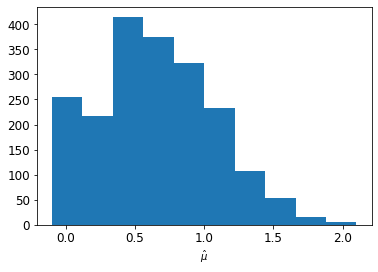

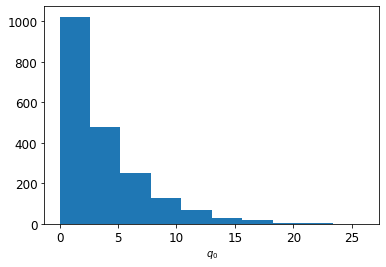

Z BL:(1.9910021098966673, 0.7174138361973786, 0.9985, 1.9913286417415288, 0.7256726801817363)
Z:1.590035602215254
Z_std:1.1741815407361227
Z_1:1.2948501092467453
Z_std_1:2.027587004403913
4
AUC:0.9027323182171788
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

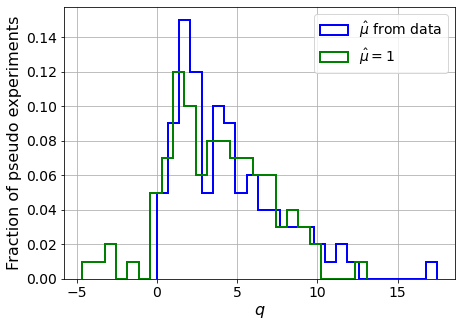

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  6998.53855671  6838.5517049   6639.51787648
  6378.78226148  6055.76400413  5649.88208073  5161.79590037
  4556.77416042  3823.53378805  2931.84494487  1873.53163808
   613.77562792  -894.1475956  -2705.39479151 -5298.78116784]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4308.92974116  4316.05779553


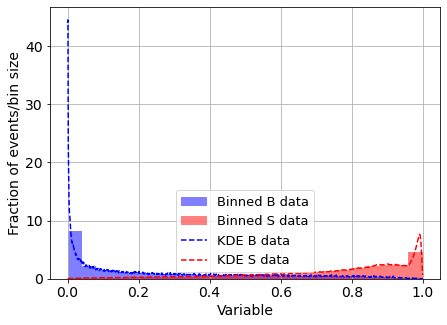

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.021505084600349732
0.021505084600349732
3 done
4 done
0.0
1.050220636450897e-05


  1%|▎                                                                 | 11/2000 [00:03<09:31,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4545409554677813
<p_{s}(Sdata)> = 1.9315399037829841
<p_{b}(Bdata)> = 7.288786452343092
<p_{s}(Bdata)> = 0.42287802984930145


  1%|▌                                                                 | 16/2000 [00:04<09:43,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40212474395151765
<p_{s}(Sdata)> = 2.007995140328084
<p_{b}(Bdata)> = 7.049631860949548
<p_{s}(Bdata)> = 0.4207291762676065


  4%|██▉                                                               | 89/2000 [00:25<06:24,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3877810482366272
<p_{s}(Sdata)> = 1.9876172581605616
<p_{b}(Bdata)> = 7.059691447473253
<p_{s}(Bdata)> = 0.4183950529411414


  5%|███▎                                                             | 102/2000 [00:28<07:27,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4581075332838725
<p_{s}(Sdata)> = 2.4961707856918913
<p_{b}(Bdata)> = 7.035315696556686
<p_{s}(Bdata)> = 0.4315570648048733


  6%|███▉                                                             | 120/2000 [00:33<07:24,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47903084246163663
<p_{s}(Sdata)> = 1.8857878367814425
<p_{b}(Bdata)> = 7.2225700194069065
<p_{s}(Bdata)> = 0.42109366599342485


  6%|███▉                                                             | 123/2000 [00:34<07:46,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42215549823653453
<p_{s}(Sdata)> = 1.8661125990656582
<p_{b}(Bdata)> = 7.135279308437883
<p_{s}(Bdata)> = 0.41791406727445796


  7%|████▌                                                            | 142/2000 [00:41<12:18,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45303114290914115
<p_{s}(Sdata)> = 1.9075771795073235
<p_{b}(Bdata)> = 7.28844852679681
<p_{s}(Bdata)> = 0.41908697546317736


  7%|████▋                                                            | 146/2000 [00:43<10:34,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4276241255928602
<p_{s}(Sdata)> = 2.1165090138495883
<p_{b}(Bdata)> = 7.137967687797128
<p_{s}(Bdata)> = 0.4196523755774335


  9%|█████▊                                                           | 177/2000 [00:58<14:11,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4162664626498785
<p_{s}(Sdata)> = 2.073952790346881
<p_{b}(Bdata)> = 7.2386065292493775
<p_{s}(Bdata)> = 0.4208744045357672


  9%|██████                                                           | 185/2000 [01:02<10:44,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46031682890257064
<p_{s}(Sdata)> = 1.7689214585994977
<p_{b}(Bdata)> = 7.1991317198931535
<p_{s}(Bdata)> = 0.4184924448179316


 10%|██████▌                                                          | 203/2000 [01:13<16:39,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37589926196707735
<p_{s}(Sdata)> = 2.218881903089021
<p_{b}(Bdata)> = 7.255853443129429
<p_{s}(Bdata)> = 0.4182366209677516


 11%|██████▊                                                          | 211/2000 [01:17<11:21,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48588627115254107
<p_{s}(Sdata)> = 1.8788421870540801
<p_{b}(Bdata)> = 7.164599490868484
<p_{s}(Bdata)> = 0.41637378847303197


 12%|███████▉                                                         | 243/2000 [01:33<11:15,  2.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3920476304327082
<p_{s}(Sdata)> = 2.1406699357768257
<p_{b}(Bdata)> = 7.181661745461252
<p_{s}(Bdata)> = 0.4187090192647515


 13%|████████▋                                                        | 266/2000 [01:46<13:52,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5562375310511686
<p_{s}(Sdata)> = 1.5601765270495704
<p_{b}(Bdata)> = 7.115909123804034
<p_{s}(Bdata)> = 0.42288890297164644


 16%|██████████▏                                                      | 315/2000 [02:12<13:25,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4046989886990964
<p_{s}(Sdata)> = 2.1949752497523485
<p_{b}(Bdata)> = 7.078118796271506
<p_{s}(Bdata)> = 0.4316686455650243


 16%|██████████▎                                                      | 317/2000 [02:12<09:53,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48745634690600864
<p_{s}(Sdata)> = 1.978257960900839
<p_{b}(Bdata)> = 7.131911468269608
<p_{s}(Bdata)> = 0.4246975247562505


 18%|███████████▉                                                     | 369/2000 [02:43<09:52,  2.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49006159835375995
<p_{s}(Sdata)> = 1.9277543654649554
<p_{b}(Bdata)> = 7.072942184488329
<p_{s}(Bdata)> = 0.4215575995414732


 20%|█████████████▏                                                   | 406/2000 [03:02<11:55,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5035320450134497
<p_{s}(Sdata)> = 2.1572533185238094
<p_{b}(Bdata)> = 7.224665903539721
<p_{s}(Bdata)> = 0.4140742710653631


 22%|██████████████                                                   | 434/2000 [03:17<12:10,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4125680072007987
<p_{s}(Sdata)> = 2.151067294206293
<p_{b}(Bdata)> = 7.2331913162836186
<p_{s}(Bdata)> = 0.4182918365163701


 23%|██████████████▉                                                  | 459/2000 [03:30<10:58,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4960963395694614
<p_{s}(Sdata)> = 1.8358533115092068
<p_{b}(Bdata)> = 7.213263023341421
<p_{s}(Bdata)> = 0.42433369723217973


 23%|███████████████▏                                                 | 468/2000 [03:35<11:18,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4715215761749838
<p_{s}(Sdata)> = 1.9179544520808
<p_{b}(Bdata)> = 7.1159713275856324
<p_{s}(Bdata)> = 0.41721415643743653


 24%|███████████████▎                                                 | 473/2000 [03:37<09:11,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.428353221096415
<p_{s}(Sdata)> = 2.0004375096253764
<p_{b}(Bdata)> = 7.127528577571204
<p_{s}(Bdata)> = 0.4174504674834951


 27%|█████████████████▍                                               | 537/2000 [04:12<11:10,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4814914860470375
<p_{s}(Sdata)> = 1.676297760095917
<p_{b}(Bdata)> = 7.146012849845789
<p_{s}(Bdata)> = 0.4199042376899421


 27%|█████████████████▋                                               | 545/2000 [04:16<09:23,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3914892752856326
<p_{s}(Sdata)> = 2.2921096239350027
<p_{b}(Bdata)> = 7.138842421634302
<p_{s}(Bdata)> = 0.41639624172176404


 29%|██████████████████▉                                              | 581/2000 [04:35<10:54,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4366850377707607
<p_{s}(Sdata)> = 1.7552737848964568
<p_{b}(Bdata)> = 7.130019939142217
<p_{s}(Bdata)> = 0.42138332254879557


 30%|███████████████████▎                                             | 596/2000 [04:44<10:00,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46178736555419986
<p_{s}(Sdata)> = 1.7478773863525412
<p_{b}(Bdata)> = 7.044814602711331
<p_{s}(Bdata)> = 0.42133641656016924


 31%|███████████████████▉                                             | 614/2000 [04:54<11:23,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43037433684609505
<p_{s}(Sdata)> = 1.8479086063952663
<p_{b}(Bdata)> = 7.047022193062716
<p_{s}(Bdata)> = 0.42525620162795463


 31%|████████████████████▏                                            | 621/2000 [04:57<09:56,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3962019051617181
<p_{s}(Sdata)> = 2.0111636652227096
<p_{b}(Bdata)> = 7.208963728587501
<p_{s}(Bdata)> = 0.4189519026359866


 32%|████████████████████▍                                            | 630/2000 [05:02<08:25,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.557721545763655
<p_{s}(Sdata)> = 2.0042649519068
<p_{b}(Bdata)> = 7.055417891244218
<p_{s}(Bdata)> = 0.4207692906275196


 33%|█████████████████████▍                                           | 658/2000 [05:19<10:02,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46871062579461165
<p_{s}(Sdata)> = 2.074954360534437
<p_{b}(Bdata)> = 7.249129652943627
<p_{s}(Bdata)> = 0.412991917774804


 34%|██████████████████████                                           | 679/2000 [05:30<08:15,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4737603162696495
<p_{s}(Sdata)> = 1.697636592967905
<p_{b}(Bdata)> = 7.273387591079892
<p_{s}(Bdata)> = 0.42097155691410176


 36%|███████████████████████                                          | 711/2000 [05:47<07:16,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43002972593912087
<p_{s}(Sdata)> = 2.0560914784574726
<p_{b}(Bdata)> = 7.2191168373766486
<p_{s}(Bdata)> = 0.41935476261128374
muhat = -0.1
<p_{b}(Sdata)> = 0.4285686440313031
<p_{s}(Sdata)> = 2.0368282891146388
<p_{b}(Bdata)> = 7.098710787791078
<p_{s}(Bdata)> = 0.4190173343845968


 38%|████████████████████████▍                                        | 750/2000 [06:08<08:46,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40547989505518356
<p_{s}(Sdata)> = 2.165096808948193
<p_{b}(Bdata)> = 7.23861860685906
<p_{s}(Bdata)> = 0.41079557124745497


 40%|██████████████████████████▏                                      | 806/2000 [06:38<08:36,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49099228775483206
<p_{s}(Sdata)> = 1.850770522554918
<p_{b}(Bdata)> = 7.14637815662887
<p_{s}(Bdata)> = 0.4156999780863312


 42%|███████████████████████████▌                                     | 847/2000 [07:01<08:36,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41392645113742527
<p_{s}(Sdata)> = 2.1570629264858594
<p_{b}(Bdata)> = 7.229365929863185
<p_{s}(Bdata)> = 0.4162098582392307


 43%|████████████████████████████▏                                    | 866/2000 [07:10<06:15,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4240692951655585
<p_{s}(Sdata)> = 2.0396619693474984
<p_{b}(Bdata)> = 7.120690125735999
<p_{s}(Bdata)> = 0.4177886106841253


 45%|█████████████████████████████▎                                   | 901/2000 [07:32<07:53,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4615076142191177
<p_{s}(Sdata)> = 1.9064040484149865
<p_{b}(Bdata)> = 7.0822997854546585
<p_{s}(Bdata)> = 0.4170883083408081


 46%|█████████████████████████████▉                                   | 921/2000 [07:43<07:04,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3931091183261717
<p_{s}(Sdata)> = 2.102534851195824
<p_{b}(Bdata)> = 7.238196091056528
<p_{s}(Bdata)> = 0.41659077412210876


 47%|██████████████████████████████▋                                  | 944/2000 [07:55<09:37,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44375917943261456
<p_{s}(Sdata)> = 1.8156093707454204
<p_{b}(Bdata)> = 7.013710248415237
<p_{s}(Bdata)> = 0.42674763693995266


 48%|███████████████████████████████▏                                 | 959/2000 [08:00<03:59,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4545080281276146
<p_{s}(Sdata)> = 1.8420578112755857
<p_{b}(Bdata)> = 7.228875842111008
<p_{s}(Bdata)> = 0.41939984284986603


 50%|████████████████████████████████▏                               | 1005/2000 [08:14<04:43,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4192972784129027
<p_{s}(Sdata)> = 2.0148029183941563
<p_{b}(Bdata)> = 7.343596397437143
<p_{s}(Bdata)> = 0.4214004696719819


 51%|████████████████████████████████▍                               | 1012/2000 [08:16<05:52,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36793237950743
<p_{s}(Sdata)> = 2.139970581143781
<p_{b}(Bdata)> = 7.1971328858522865
<p_{s}(Bdata)> = 0.4149922184412617


 52%|█████████████████████████████████▍                              | 1043/2000 [08:25<04:55,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42413401346800295
<p_{s}(Sdata)> = 1.8765389031880753
<p_{b}(Bdata)> = 7.104130094257211
<p_{s}(Bdata)> = 0.4170602009028835


 54%|██████████████████████████████████▎                             | 1071/2000 [08:34<04:43,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4470382301558929
<p_{s}(Sdata)> = 1.8106641127421643
<p_{b}(Bdata)> = 7.188151786966457
<p_{s}(Bdata)> = 0.41879564428033605


 54%|██████████████████████████████████▍                             | 1078/2000 [08:36<05:04,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4161735771682617
<p_{s}(Sdata)> = 2.2418051004138775
<p_{b}(Bdata)> = 7.1532225208534355
<p_{s}(Bdata)> = 0.4222812618498454


 56%|███████████████████████████████████▉                            | 1124/2000 [08:49<03:37,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46069932011385134
<p_{s}(Sdata)> = 1.8690754057726222
<p_{b}(Bdata)> = 7.1778854960749845
<p_{s}(Bdata)> = 0.4242187927953415


 57%|████████████████████████████████████▋                           | 1145/2000 [08:55<04:37,  3.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37919512789741966
<p_{s}(Sdata)> = 2.5873360474041602
<p_{b}(Bdata)> = 7.004626008064648
<p_{s}(Bdata)> = 0.4338650944722869


 59%|█████████████████████████████████████▋                          | 1177/2000 [09:05<04:30,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4046911370500066
<p_{s}(Sdata)> = 2.0656838719814177
<p_{b}(Bdata)> = 7.12397606370277
<p_{s}(Bdata)> = 0.4192248675316212


 59%|█████████████████████████████████████▉                          | 1187/2000 [09:07<03:59,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44322822955305435
<p_{s}(Sdata)> = 1.8066926933115366
<p_{b}(Bdata)> = 7.1443995495184325
<p_{s}(Bdata)> = 0.41347102852308326


 61%|██████████████████████████████████████▉                         | 1215/2000 [09:16<04:24,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4331590160911315
<p_{s}(Sdata)> = 1.7959831046551211
<p_{b}(Bdata)> = 7.101769215908655
<p_{s}(Bdata)> = 0.4226336353325639


 61%|██████████████████████████████████████▉                         | 1218/2000 [09:17<03:34,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5045786947823576
<p_{s}(Sdata)> = 1.516560992403978
<p_{b}(Bdata)> = 7.275935330957529
<p_{s}(Bdata)> = 0.42223787103272276


 63%|████████████████████████████████████████▌                       | 1266/2000 [09:31<04:01,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4166749068981565
<p_{s}(Sdata)> = 1.9865931917783266
<p_{b}(Bdata)> = 7.10747286366026
<p_{s}(Bdata)> = 0.41856772308585605


 64%|████████████████████████████████████████▉                       | 1281/2000 [09:35<02:54,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5033635968772369
<p_{s}(Sdata)> = 2.0350133534370713
<p_{b}(Bdata)> = 7.3094239228992715
<p_{s}(Bdata)> = 0.4168224647556922


 66%|██████████████████████████████████████████▎                     | 1322/2000 [09:47<03:51,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38538059323139634
<p_{s}(Sdata)> = 2.180650967399726
<p_{b}(Bdata)> = 7.1859844354884155
<p_{s}(Bdata)> = 0.4208594461865838


 68%|███████████████████████████████████████████▌                    | 1360/2000 [09:59<03:45,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4206773220322532
<p_{s}(Sdata)> = 2.0816116118700574
<p_{b}(Bdata)> = 7.273876517660417
<p_{s}(Bdata)> = 0.41986263980460364


 68%|███████████████████████████████████████████▌                    | 1363/2000 [09:59<03:21,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46595337067269277
<p_{s}(Sdata)> = 1.949612170648265
<p_{b}(Bdata)> = 7.202628919071135
<p_{s}(Bdata)> = 0.4156620373599221


 70%|████████████████████████████████████████████▊                   | 1399/2000 [10:09<02:14,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5113027846790626
<p_{s}(Sdata)> = 1.718663068110447
<p_{b}(Bdata)> = 7.292857772611681
<p_{s}(Bdata)> = 0.41773449816465924


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [10:24<02:44,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38980904627728363
<p_{s}(Sdata)> = 2.176918785325205
<p_{b}(Bdata)> = 7.259052947623107
<p_{s}(Bdata)> = 0.419075895889459


 76%|████████████████████████████████████████████████▍               | 1515/2000 [10:44<02:40,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4715925040061909
<p_{s}(Sdata)> = 2.1458531411602055
<p_{b}(Bdata)> = 7.152828731882579
<p_{s}(Bdata)> = 0.4148600904846775


 77%|█████████████████████████████████████████████████▌              | 1547/2000 [10:53<01:37,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45408839000487766
<p_{s}(Sdata)> = 1.8059100450653038
<p_{b}(Bdata)> = 6.895457213009903
<p_{s}(Bdata)> = 0.42079173925043145


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [10:54<01:48,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42644252734210375
<p_{s}(Sdata)> = 1.9810124404623495
<p_{b}(Bdata)> = 7.234616672302903
<p_{s}(Bdata)> = 0.41849478734563766


 80%|███████████████████████████████████████████████████▌            | 1610/2000 [11:14<02:04,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4155811479661921
<p_{s}(Sdata)> = 1.984684176547064
<p_{b}(Bdata)> = 7.063791961227553
<p_{s}(Bdata)> = 0.4149563355088686


 85%|██████████████████████████████████████████████████████▎         | 1699/2000 [11:41<01:34,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3895393408413551
<p_{s}(Sdata)> = 2.090038158809477
<p_{b}(Bdata)> = 7.185459806041
<p_{s}(Bdata)> = 0.414807612609785


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [11:52<00:59,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4230656302253723
<p_{s}(Sdata)> = 1.9786433506753978
<p_{b}(Bdata)> = 7.267818199786078
<p_{s}(Bdata)> = 0.4145370551235792


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [12:01<01:12,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42023159918315905
<p_{s}(Sdata)> = 2.105530392298574
<p_{b}(Bdata)> = 7.265376330650879
<p_{s}(Bdata)> = 0.418174792241991


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [12:02<00:51,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5170079593531745
<p_{s}(Sdata)> = 1.914499738607668
<p_{b}(Bdata)> = 7.077230735922308
<p_{s}(Bdata)> = 0.4178628090471236


 90%|█████████████████████████████████████████████████████████▎      | 1792/2000 [12:08<00:41,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.788673129994581
<p_{s}(Sdata)> = 1.9912821652115333
<p_{b}(Bdata)> = 7.053774324114372
<p_{s}(Bdata)> = 0.4214665716039908


 90%|█████████████████████████████████████████████████████████▉      | 1810/2000 [12:13<00:42,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.395171086474138
<p_{s}(Sdata)> = 2.017371094961512
<p_{b}(Bdata)> = 7.151617341235055
<p_{s}(Bdata)> = 0.4248042545506302


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [12:19<00:34,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42234438212730213
<p_{s}(Sdata)> = 1.7824821310662566
<p_{b}(Bdata)> = 7.203526496700635
<p_{s}(Bdata)> = 0.4194870143131614


 92%|██████████████████████████████████████████████████████████▊     | 1836/2000 [12:19<00:42,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4113536844134327
<p_{s}(Sdata)> = 2.200170310294699
<p_{b}(Bdata)> = 7.195599563321268
<p_{s}(Bdata)> = 0.41617591829684597


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [12:21<00:47,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4194135594338626
<p_{s}(Sdata)> = 2.254919859233807
<p_{b}(Bdata)> = 7.016182537228065
<p_{s}(Bdata)> = 0.4253359486849326


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [12:39<00:29,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42688778453048926
<p_{s}(Sdata)> = 1.871256422549429
<p_{b}(Bdata)> = 7.020513179876844
<p_{s}(Bdata)> = 0.4236300880135668


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [12:43<00:22,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41680643851471677
<p_{s}(Sdata)> = 2.1053025858754126
<p_{b}(Bdata)> = 7.150326049748519
<p_{s}(Bdata)> = 0.41890439182599326


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [12:43<00:23,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4153249562794589
<p_{s}(Sdata)> = 2.1268391415536514
<p_{b}(Bdata)> = 7.169736869078914
<p_{s}(Bdata)> = 0.4230018382606091


 99%|███████████████████████████████████████████████████████████████▏| 1975/2000 [13:02<00:07,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4346215765406017
<p_{s}(Sdata)> = 1.765447232765042
<p_{b}(Bdata)> = 7.079496772976323
<p_{s}(Bdata)> = 0.4247895293139453


 99%|███████████████████████████████████████████████████████████████▍| 1981/2000 [13:03<00:04,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4931050239940342
<p_{s}(Sdata)> = 2.0931605983590065
<p_{b}(Bdata)> = 7.205533402989072
<p_{s}(Bdata)> = 0.4190117092359799


 99%|███████████████████████████████████████████████████████████████▌| 1988/2000 [13:05<00:03,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4233383734026036
<p_{s}(Sdata)> = 2.071082710867458
<p_{b}(Bdata)> = 7.2193956928465175
<p_{s}(Bdata)> = 0.41859320643338077


100%|████████████████████████████████████████████████████████████████| 2000/2000 [13:09<00:00,  2.53it/s]


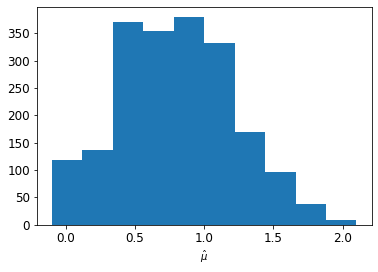

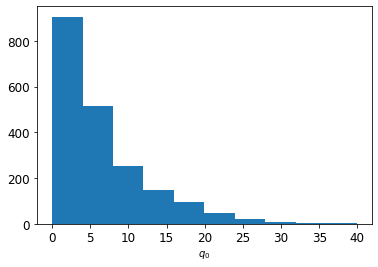

Z BL:(1.9192607983352377, 0.8405849712749577, 0.9865, 1.9192607983352377, 0.8389839850961099)
Z:2.1296223003529495
Z_std:1.4521301996936897
Z_1:2.0754605364979475
Z_std_1:1.6563002202421393


<Figure size 432x288 with 0 Axes>

In [67]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)
num_pseudo = 100

Z_BL        = []

Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(5):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)
    #classifier.load_model('BP-Independent_MET200.json')
    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, 5, linear_bins=True) )

    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    print(np.min(pB_B_data))
    pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
    pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
    print(np.min(pB_B_data))

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(2000)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])


        if np.min(prob_x_given_B) == 0:
            print('There are events with p(s)=0')
            prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    plt.hist(np.asarray(muhat_selected_MLL_list))
    plt.xlabel(r'$\hat{\mu}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '_MET200.pdf')
    plt.show()
    plt.clf()
    
    plt.hist(np.asarray(q_muhat_MLL))
    plt.xlabel(r'$q_{0}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '_MET200.pdf')
    plt.show()
    plt.clf()
    print('Z BL:' + str(Z_BL[iloop]))
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

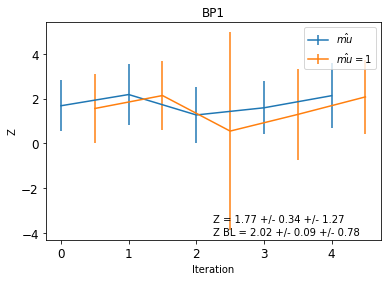

In [68]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_MET200_new.pdf')

In [58]:
Z_MLL

[1.5952752003937312,
 1.969182004549266,
 1.7972219500381041,
 1.5440507060644548,
 1.4322714279465758]

In [59]:
Z_MLL_std

[1.1661102151892757,
 1.4166133665537723,
 1.342131762117268,
 1.1522670247984454,
 1.1570602046280485]

In [60]:
np.asarray(Z_BL)[:,0]

array([2.02188698, 2.02479628, 1.93104001, 1.82456241, 1.9533232 ])

In [61]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

Z = 1.67 +/- 0.19 +/- 1.25
Z BL = 1.95 +/- 0.07 +/- 0.84


In [62]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

AUC : 0.9025280015142535 +/- 0.00036287640006834953
